# AV02 - Previsão de retornos diários de ações do Ibovespa com LSTM e GRU

Respondendo duas perguntas de imediato:
- Por que retornos e não preços? Os preços de uma ação podem ser interpretados como um passeio aleatório, comportamento de dados em que geralmente o melhor modelo para prever o próximo passo é simplesmente repetir o anterior. Random walks tem alta correlação entre a série e a própria série atrasada, indicando que o passado seria útil para prever o futuro, mas a correlação tem mais a ver com a tendência do que com poder preditivo real. Uma série de retornos, estacionária, tem correlação irrelevante com ela mesma, mas tem mais poder preditivo real na decisão de comprar ou vender uma ação baseando-se nos movimentos dela, e melhor ainda se for utilizada uma classificação dos movimentos em vez de uma previsão numérica dos retornos, o que nos leva à paóxima questão.
- Por que classificação e não regressão? Como indicado por (Enke, 2005) https://www.sciencedirect.com/science/article/abs/pii/S0957417405001156, uma estratégia baseada em classificação da direção dos retornos tem um melhor ganho ajustado ao risco. Uma classificação positiva ou negativa em relação a se uma ação terá retorno positivo ou negativo transforma a saída do modelo em uma informação acionável, além de que tentar prever um valor numérico em uma série altamente volátil é mais difícil do que apenas dizer a direção do retorno.

## Importando dados e libs

In [1]:
# system
import os
import pickle

# data
import pandas as pd
import plotly.express as px
from pandas import Timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# math
import numpy as np
import math
from math import floor, ceil
import random

# stats, metrics, model selection
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import kstest, shapiro, pearsonr
from statsmodels.tsa.stattools import adfuller, pacf, acf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer
from sklearn.model_selection import BaseCrossValidator
from sklearn.preprocessing import StandardScaler

# models
# import pmdarima as pm
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Input, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

RANDOM_STATE = 21

np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)


2024-11-11 05:07:27.233091: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
abev3 = pd.read_csv("./av02_lstm/stocks/ABEV3.csv")
bbdc3 = pd.read_csv("./av02_lstm/stocks/BBDC3.csv")
itsa3 = pd.read_csv("./av02_lstm/stocks/ITSA3.csv")
itub3 = pd.read_csv("./av02_lstm/stocks/ITUB3.csv")
wege3 = pd.read_csv("./av02_lstm/stocks/WEGE3.csv")

In [3]:
abev3.head()

Date  Price   Open   High    Low    Vol. Change %
0  10/04/2024  13.28  13.26  13.45  13.17  36.59M   -0.90%
1  10/03/2024  13.40  13.55  13.63  13.40  44.99M   -2.33%
2  10/02/2024  13.72  13.70  13.85  13.61  51.03M    0.88%
3  10/01/2024  13.60  13.20  13.72  13.13  65.79M    3.98%
4  09/30/2024  13.08  12.94  13.17  12.90  31.05M    1.24%

In [4]:
bbdc3.head()

Date  Price   Open   High    Low   Vol. Change %
0  10/04/2024  13.29  13.19  13.42  13.10  5.32M    0.30%
1  10/03/2024  13.25  13.28  13.42  13.14  5.28M   -0.97%
2  10/02/2024  13.38  13.30  13.54  13.27  8.59M    3.22%
3  10/01/2024  12.96  13.04  13.11  12.84  7.16M    0.54%
4  09/30/2024  12.89  13.05  13.08  12.87  5.90M   -1.13%

In [5]:
itsa3.head()

Date  Price   Open   High    Low     Vol. Change %
0  10/04/2024  10.63  10.57  10.68  10.55  114.10K    0.76%
1  10/03/2024  10.55  10.91  10.91  10.55  294.10K   -3.21%
2  10/02/2024  10.90  10.90  11.05  10.90  162.60K    0.46%
3  10/01/2024  10.85  11.07  11.07  10.79  432.30K   -2.08%
4  09/30/2024  11.08  11.12  11.16  11.00  122.70K   -0.63%

In [6]:
itub3.head()

Date  Price   Open   High    Low     Vol. Change %
0  10/04/2024  30.46  30.39  30.60  30.27  310.50K    0.20%
1  10/03/2024  30.40  31.01  31.02  30.30  386.90K   -2.22%
2  10/02/2024  31.09  30.90  31.43  30.90  343.80K    0.65%
3  10/01/2024  30.89  31.41  31.49  30.77  467.50K   -1.66%
4  09/30/2024  31.41  31.86  32.01  31.41  428.40K   -1.50%

In [7]:
wege3.head()

Date  Price   Open   High    Low   Vol. Change %
0  10/04/2024  54.50  54.36  54.98  54.26  4.82M   -0.18%
1  10/03/2024  54.60  54.76  55.00  53.95  4.47M   -1.36%
2  10/02/2024  55.35  56.13  56.37  55.14  5.12M   -0.95%
3  10/01/2024  55.88  55.00  56.22  54.80  8.03M    2.74%
4  09/30/2024  54.39  55.63  56.24  54.39  6.41M   -2.81%

Filtrando dataframes e convertendo data em Index

In [8]:
START_DATE = "2007-10-04" # first register of price for WEGE3 -> latest of series
END_DATE = "2024-10-04"

In [9]:
abev3 = abev3.filter(["Date", "Price"], axis=1)
bbdc3 = bbdc3.filter(["Date", "Price"], axis=1)
itsa3 = itsa3.filter(["Date", "Price"], axis=1)
itub3 = itub3.filter(["Date", "Price"], axis=1)
wege3 = wege3.filter(["Date", "Price"], axis=1)

abev3['Date'] = pd.to_datetime(abev3['Date'], format='%m/%d/%Y')
bbdc3['Date'] = pd.to_datetime(bbdc3['Date'], format='%m/%d/%Y')
itsa3['Date'] = pd.to_datetime(itsa3['Date'], format='%m/%d/%Y')
itub3['Date'] = pd.to_datetime(itub3['Date'], format='%m/%d/%Y')
wege3['Date'] = pd.to_datetime(wege3['Date'], format='%m/%d/%Y')

In [10]:
abev3.head()

Date  Price
0 2024-10-04  13.28
1 2024-10-03  13.40
2 2024-10-02  13.72
3 2024-10-01  13.60
4 2024-09-30  13.08

In [11]:
abev3 = abev3[(abev3["Date"] >= START_DATE) & (abev3["Date"] <= END_DATE)]
abev3.tail()

Date  Price
4210 2007-10-10   3.04
4211 2007-10-09   3.08
4212 2007-10-08   3.06
4213 2007-10-05   3.06
4214 2007-10-04   2.99

In [12]:
bbdc3 = bbdc3[(bbdc3["Date"] >= START_DATE) & (bbdc3["Date"] <= END_DATE)]
bbdc3.tail()

Date  Price
4211 2007-10-10   6.35
4212 2007-10-09   6.38
4213 2007-10-08   6.31
4214 2007-10-05   6.30
4215 2007-10-04   6.00

In [13]:
itsa3 = itsa3[(itsa3["Date"] >= START_DATE) & (itsa3["Date"] <= END_DATE)]
itsa3.tail()

Date  Price
4151 2007-10-10   3.43
4152 2007-10-09   3.44
4153 2007-10-08   3.43
4154 2007-10-05   3.52
4155 2007-10-04   3.48

In [14]:
itub3 = itub3[(itub3["Date"] >= START_DATE) & (itub3["Date"] <= END_DATE)]
itub3.tail()

Date  Price
4210 2007-10-10   8.15
4211 2007-10-09   8.30
4212 2007-10-08   7.95
4213 2007-10-05   7.86
4214 2007-10-04   7.44

In [15]:
wege3 = wege3[(wege3["Date"] >= START_DATE) & (wege3["Date"] <= END_DATE)]
wege3.tail()

Date  Price
4210 2007-10-10   2.43
4211 2007-10-09   2.44
4212 2007-10-08   2.45
4213 2007-10-05   2.43
4214 2007-10-04   2.40

In [16]:
abev3.set_index('Date', inplace=True)
bbdc3.set_index('Date', inplace=True)
itsa3.set_index('Date', inplace=True)
itub3.set_index('Date', inplace=True)
wege3.set_index('Date', inplace=True)

In [17]:
def print_line_series(df: pd.DataFrame, title: str = "Series"):
    plt.figure(figsize=(30, 10))
    plt.title(title)
    plt.plot(df.Price)

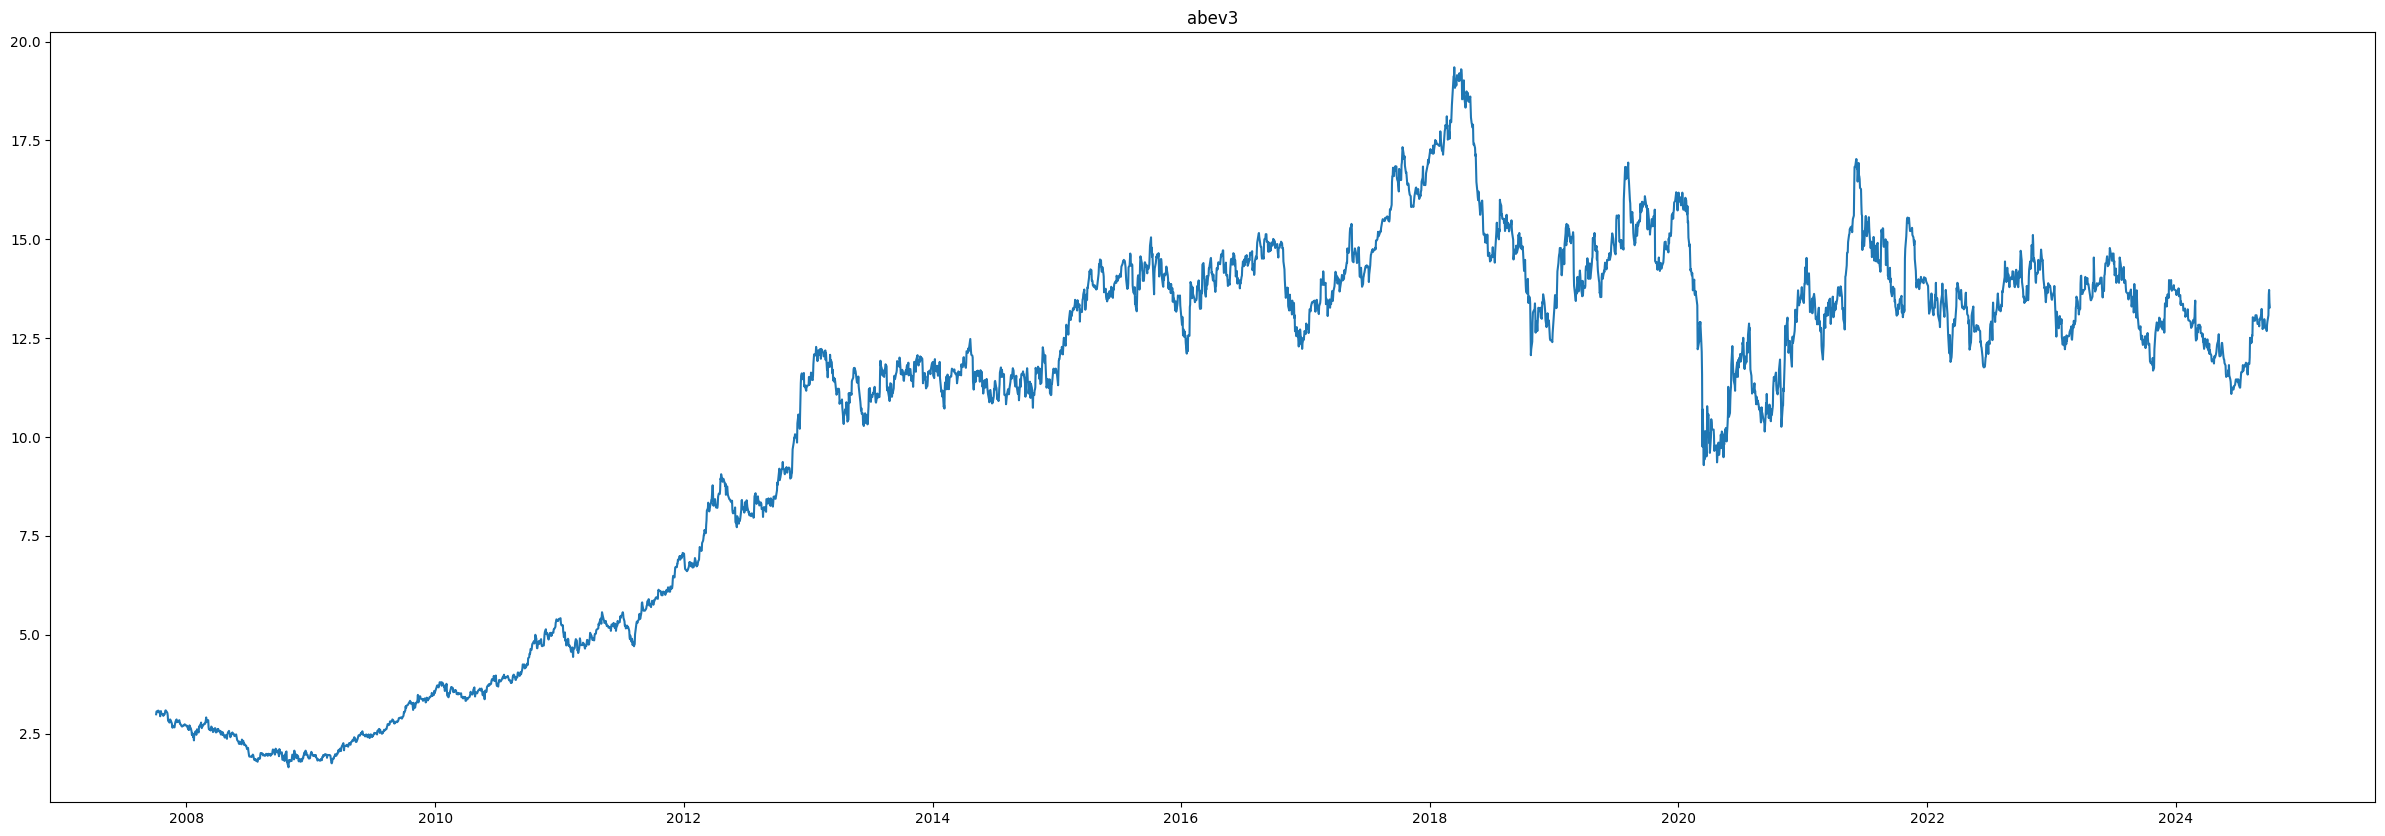

In [18]:
print_line_series(abev3, "abev3")

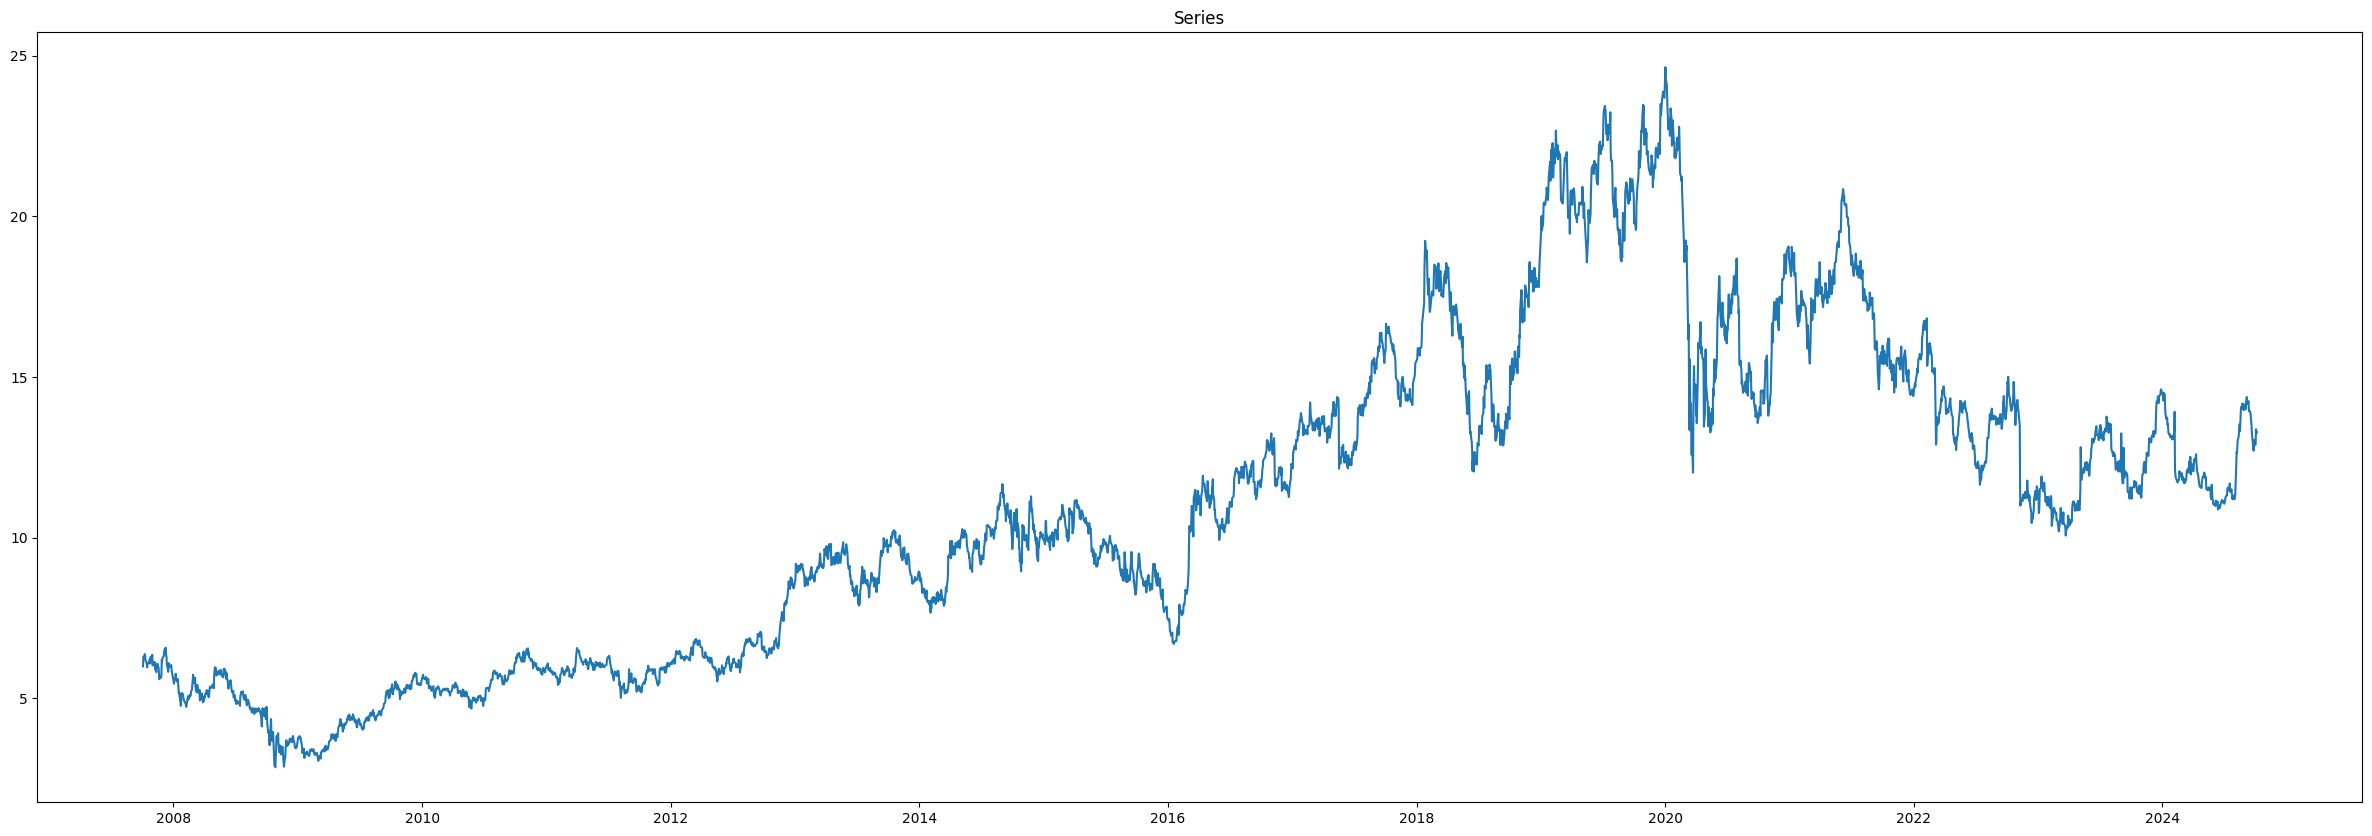

In [19]:
print_line_series(bbdc3)

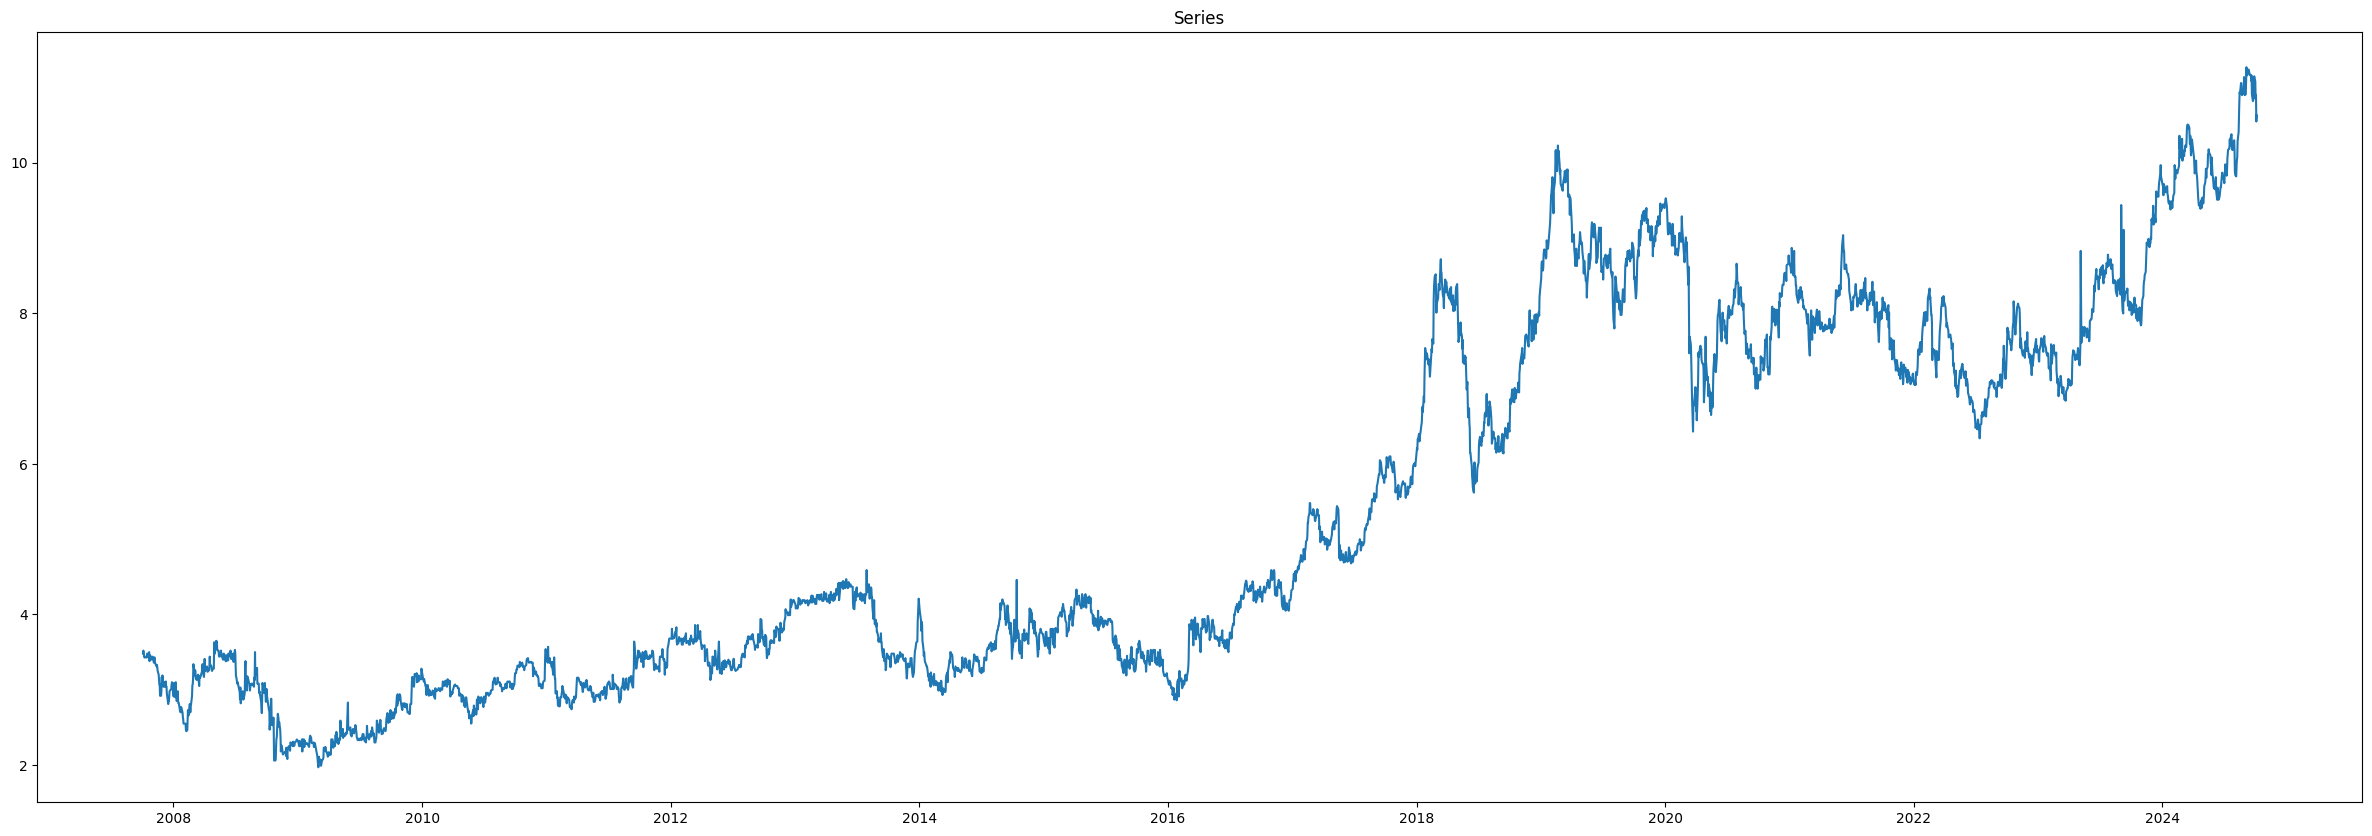

In [20]:
print_line_series(itsa3)

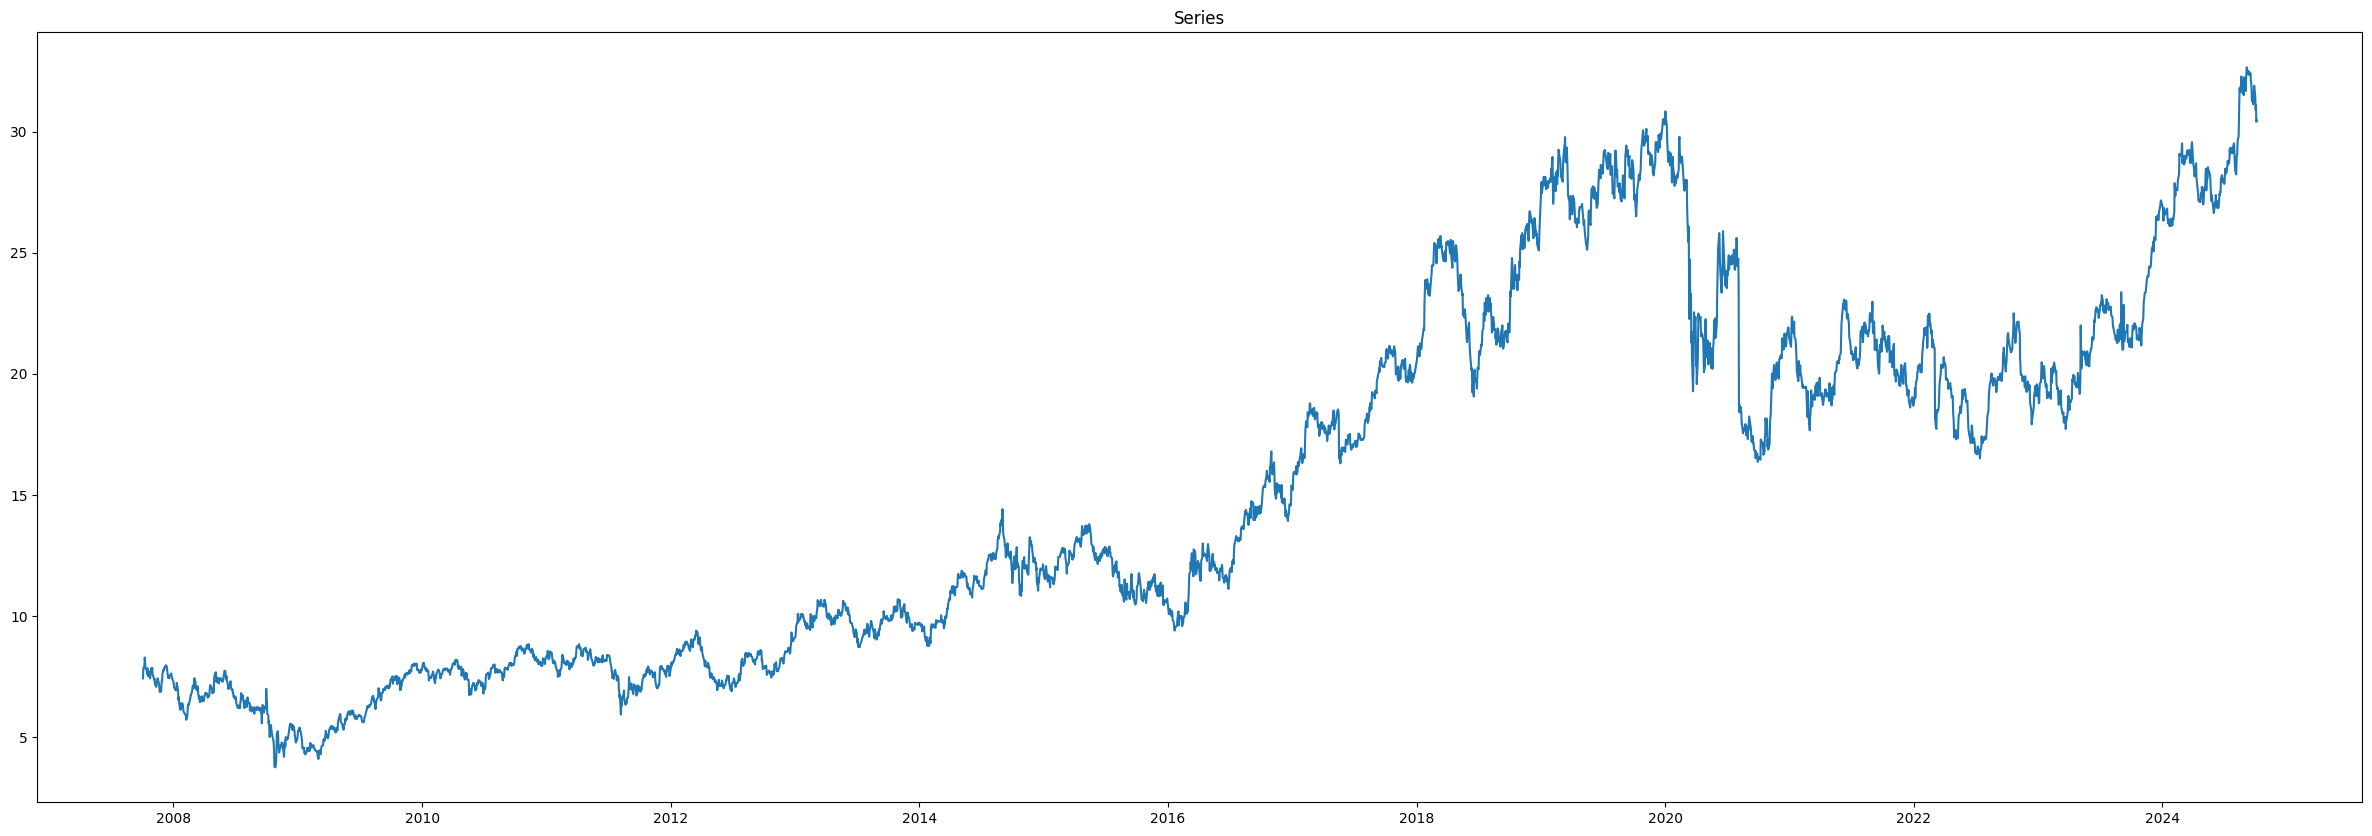

In [21]:
print_line_series(itub3)

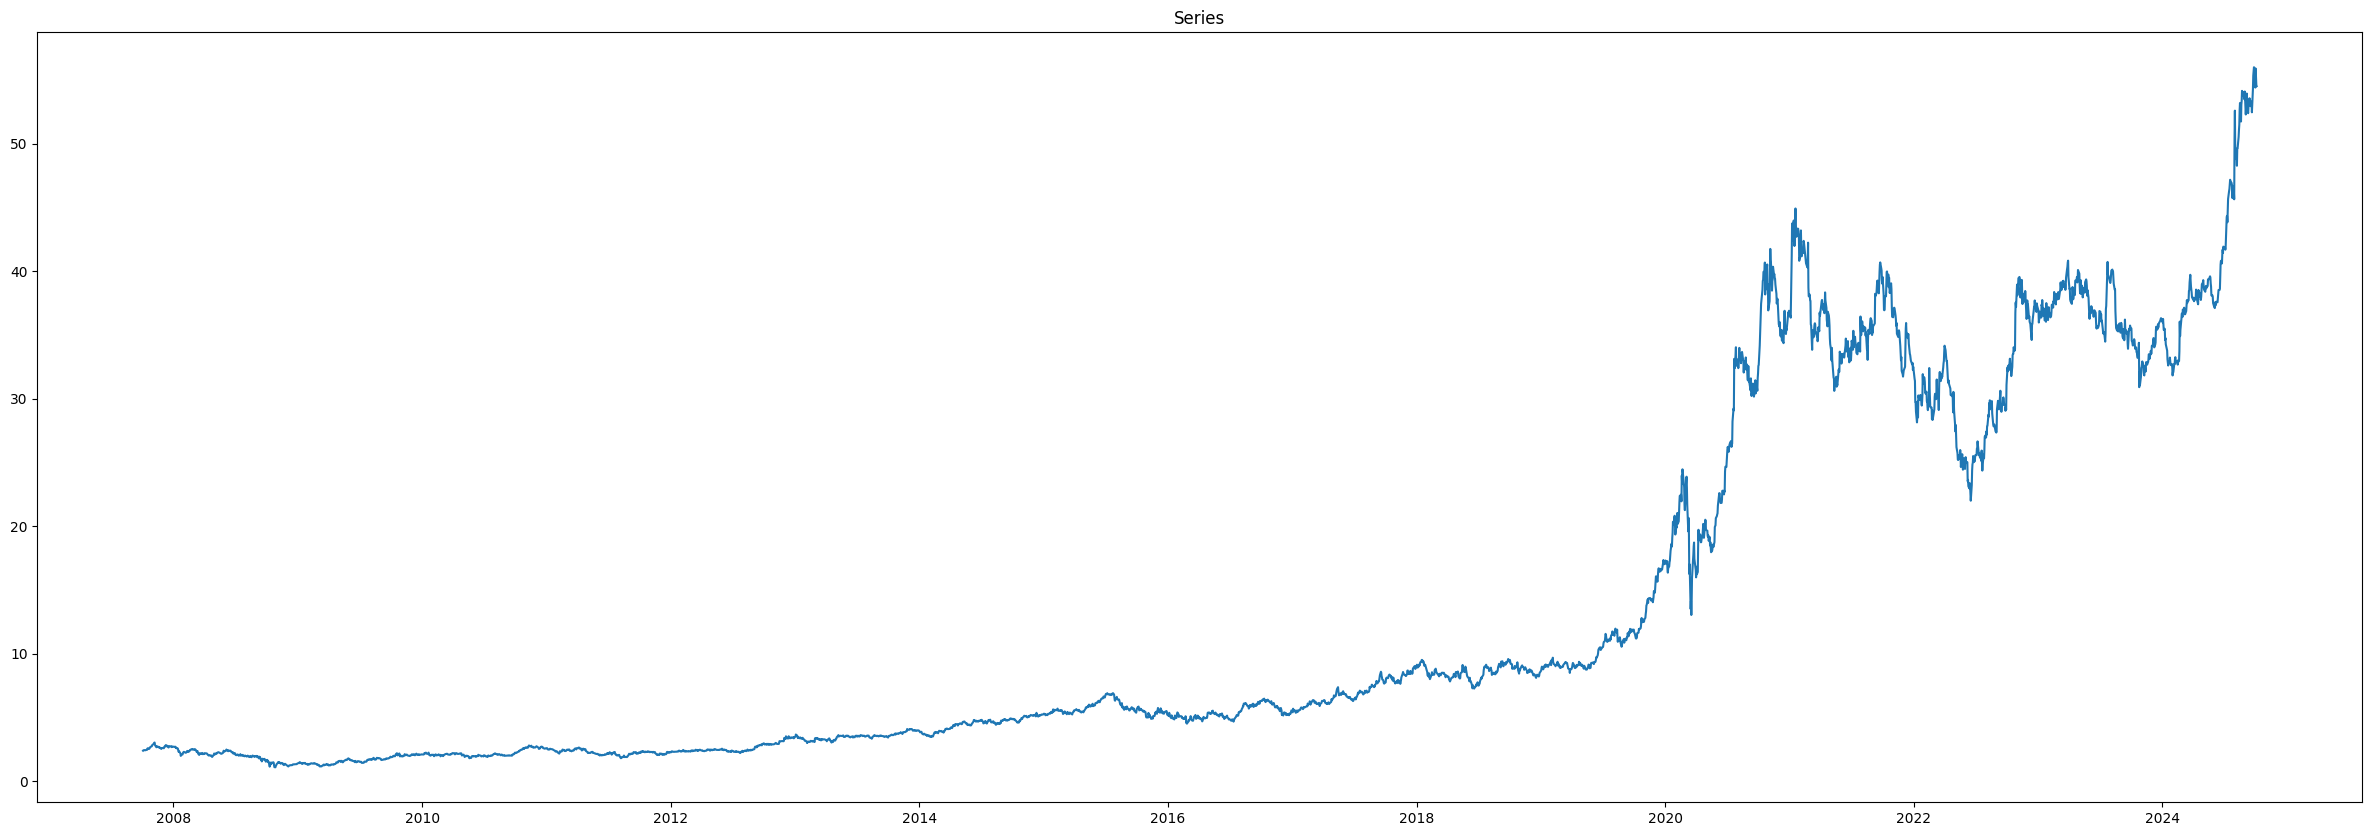

In [22]:
print_line_series(wege3)

## Lidando com dados faltantes

In [23]:
abev3.isna().sum()

Price    0
dtype: int64

In [24]:
bbdc3.isna().sum()

Price    0
dtype: int64

In [25]:
itsa3.isna().sum()

Price    0
dtype: int64

In [26]:
itub3.isna().sum()

Price    0
dtype: int64

In [27]:
wege3.isna().sum()

Price    0
dtype: int64

In [28]:
print(len(abev3))
print(len(bbdc3))
print(len(itub3))
print(len(itsa3))
print(len(wege3))

4215
4216
4215
4156
4215


Não há NaN nas séries, mas há discrepâncias no eixo temporal. Concatenando os DFs irá juntar o eixo temporal de todos eles, e as séries que não houverem registros de dias específicos passaram a ter NaN

In [29]:
stocks_df = pd.concat(
    [
        abev3.add_suffix("_abev3"), 
        bbdc3.add_suffix("_bbdc3"), 
        itub3.add_suffix("_itub3"), 
        itsa3.add_suffix("_itsa3"), 
        wege3.add_suffix("_wege3")
    ], 
    axis=1
)
stocks_df.head(10)

Price_abev3  Price_bbdc3  Price_itub3  Price_itsa3  Price_wege3
Date                                                                       
2007-10-04         2.99         6.00         7.44         3.48         2.40
2007-10-05         3.06         6.30         7.86         3.52         2.43
2007-10-08         3.06         6.31         7.95         3.43         2.45
2007-10-09         3.08         6.38         8.30         3.44         2.44
2007-10-10         3.04         6.35         8.15         3.43         2.43
2007-10-11         3.08         6.20         7.87         3.43         2.44
2007-10-15         3.02         6.09         7.75         3.43         2.47
2007-10-16         2.94         5.97         7.61         3.48         2.47
2007-10-17         3.06         6.09         7.86         3.48         2.57
2007-10-18         3.07         6.09          NaN         3.48         2.59

In [30]:
stocks_df.isna().sum()

Price_abev3     1
Price_bbdc3     0
Price_itub3     1
Price_itsa3    60
Price_wege3     1
dtype: int64

In [31]:
def count_largest_missing_interval(df: pd.DataFrame, column: str):
    # Step 1: Create a mask for missing values in the specified column.
    mask = df[column].isna()

    # Step 2: Identify consecutive groups of NaNs using cumsum on the inverted mask.
    # Use (~mask).cumsum() to create a unique group number for consecutive NaNs.
    groups = (~mask).cumsum()

    # Step 3: Filter only the groups corresponding to NaN values.
    nan_groups = stocks_df[mask].groupby(groups).size()

    # Step 4: Find the maximum size of consecutive NaNs.
    max_nan_sequence_length = nan_groups.max() if not nan_groups.empty else 0

    # Step 5: Get the index range for this sequence if it exists.
    if max_nan_sequence_length > 0:
        longest_nan_group = nan_groups.idxmax()
        start_date = df[mask & (groups == longest_nan_group)].index.min()
        end_date = df[mask & (groups == longest_nan_group)].index.max()
        print(f"The length of the largest consecutive sequence of missing values in {column} is: {max_nan_sequence_length}")
        print(f"The time range for this sequence is from {start_date} to {end_date}")
    else:
        print(f"No missing values found in the {column} time series.")
    print("\n")


In [32]:
for col in [col for col in stocks_df.columns.tolist() if "Price_" in col]:
    count_largest_missing_interval(stocks_df, col)

The length of the largest consecutive sequence of missing values in Price_abev3 is: 1
The time range for this sequence is from 2024-05-25 00:00:00 to 2024-05-25 00:00:00


No missing values found in the Price_bbdc3 time series.


The length of the largest consecutive sequence of missing values in Price_itub3 is: 1
The time range for this sequence is from 2007-10-18 00:00:00 to 2007-10-18 00:00:00


The length of the largest consecutive sequence of missing values in Price_itsa3 is: 3
The time range for this sequence is from 2008-10-03 00:00:00 to 2008-10-07 00:00:00


The length of the largest consecutive sequence of missing values in Price_wege3 is: 1
The time range for this sequence is from 2024-05-25 00:00:00 to 2024-05-25 00:00:00




Considerando que a série de preços de ações se comporta de forma semelhante a passeios aleatórios com inclinação positiva, a suposição de que o melhor modelo para prever o próximo passo é repetir o anterior não se aplica. Nesse caso, será aplicada uma interpolação linear, considerando que os valores ausentes não constituem intervalos maiores que 3 valores sequenciais. https://people.duke.edu/~rnau/Notes_on_the_random_walk_model--Robert_Nau.pdf


In [33]:
stocks_df = stocks_df.interpolate(method="linear")

In [34]:
stocks_df.isna().sum()

Price_abev3    0
Price_bbdc3    0
Price_itub3    0
Price_itsa3    0
Price_wege3    0
dtype: int64

## Exploração

In [35]:
def compute_returns_for_prices(df: pd.DataFrame, column_names: list[str]):
    for column in column_names:
        new_name = column.split("_")[1]
        df[f"Return_{new_name}"] = (df[column] / df[column].shift(1)) - 1
        df.dropna(inplace=True)

In [36]:
def normal_komolgorov_smirnov(array: np.ndarray):
    ks_statistic, p_value = kstest(array, 'norm')

    print(f"KS Statistic: {ks_statistic}")
    print(f"P-Value: {p_value}")

    if p_value < 0.05:
        print("H0 rejected, distribution can't be said Normal")
    else:
        print("H0 is not rejected, possibly normal distribution")
    
    return ks_statistic, p_value

In [37]:
def shapiro_wilk_gaussian_test(array: np.ndarray):
    sw_stat, p_value = shapiro(array)

    print(f"Shapiro-Wilk Statistic: {sw_stat}")
    print(f"P-Value: {p_value}")

    if p_value < 0.05:
        print("H0 rejected, distribution can't be said Normal")
    else:
        print("Fail to reject H0, possibly normal distribution")
    
    return sw_stat, p_value

In [38]:
def adf_test(array: np.ndarray):
    result = adfuller(array)

    adf_stat = result[0]
    p_value = result[1]
    critical_values = result[4]

    print('ADF Statistic:', adf_stat)
    print('p-value:', p_value)
    print('Critical Values:')

    if p_value < 0.05:
        print("H0 rejected. Series is possibly stationary")
    else:
        print("H0 not rejected. Series is possibly non-stationary")

    return adf_stat, p_value

In [39]:
compute_returns_for_prices(stocks_df, stocks_df.columns.tolist())
stocks_df.tail()

Price_abev3  Price_bbdc3  Price_itub3  Price_itsa3  Price_wege3  \
Date                                                                          
2024-09-30        13.08        12.89        31.41        11.08        54.39   
2024-10-01        13.60        12.96        30.89        10.85        55.88   
2024-10-02        13.72        13.38        31.09        10.90        55.35   
2024-10-03        13.40        13.25        30.40        10.55        54.60   
2024-10-04        13.28        13.29        30.46        10.63        54.50   

            Return_abev3  Return_bbdc3  Return_itub3  Return_itsa3  \
Date                                                                 
2024-09-30      0.012384     -0.011503     -0.015052     -0.006278   
2024-10-01      0.039755      0.005431     -0.016555     -0.020758   
2024-10-02      0.008824      0.032407      0.006475      0.004608   
2024-10-03     -0.023324     -0.009716     -0.022194     -0.032110   
2024-10-04     -0.008955      0.003019      0.001974      0.007583   

            Return_wege3  
Date                      
2024-09-30     -0.028056  
2024-10-01      0.027395  
2024-10-02     -0.009485  
2024-10-03     -0.013550  
2024-10-04     -0.001832

ADF Statistic: -11.426433608419805
p-value: 6.677842598959476e-21
Critical Values:
H0 rejected. Series is possibly stationary
ADF Statistic: -28.644695020966108
p-value: 0.0
Critical Values:
H0 rejected. Series is possibly stationary
ADF Statistic: -29.548670457689372
p-value: 0.0
Critical Values:
H0 rejected. Series is possibly stationary
ADF Statistic: -26.054275337285414
p-value: 0.0
Critical Values:
H0 rejected. Series is possibly stationary
ADF Statistic: -13.788318518029193
p-value: 9.02451119835645e-26
Critical Values:
H0 rejected. Series is possibly stationary


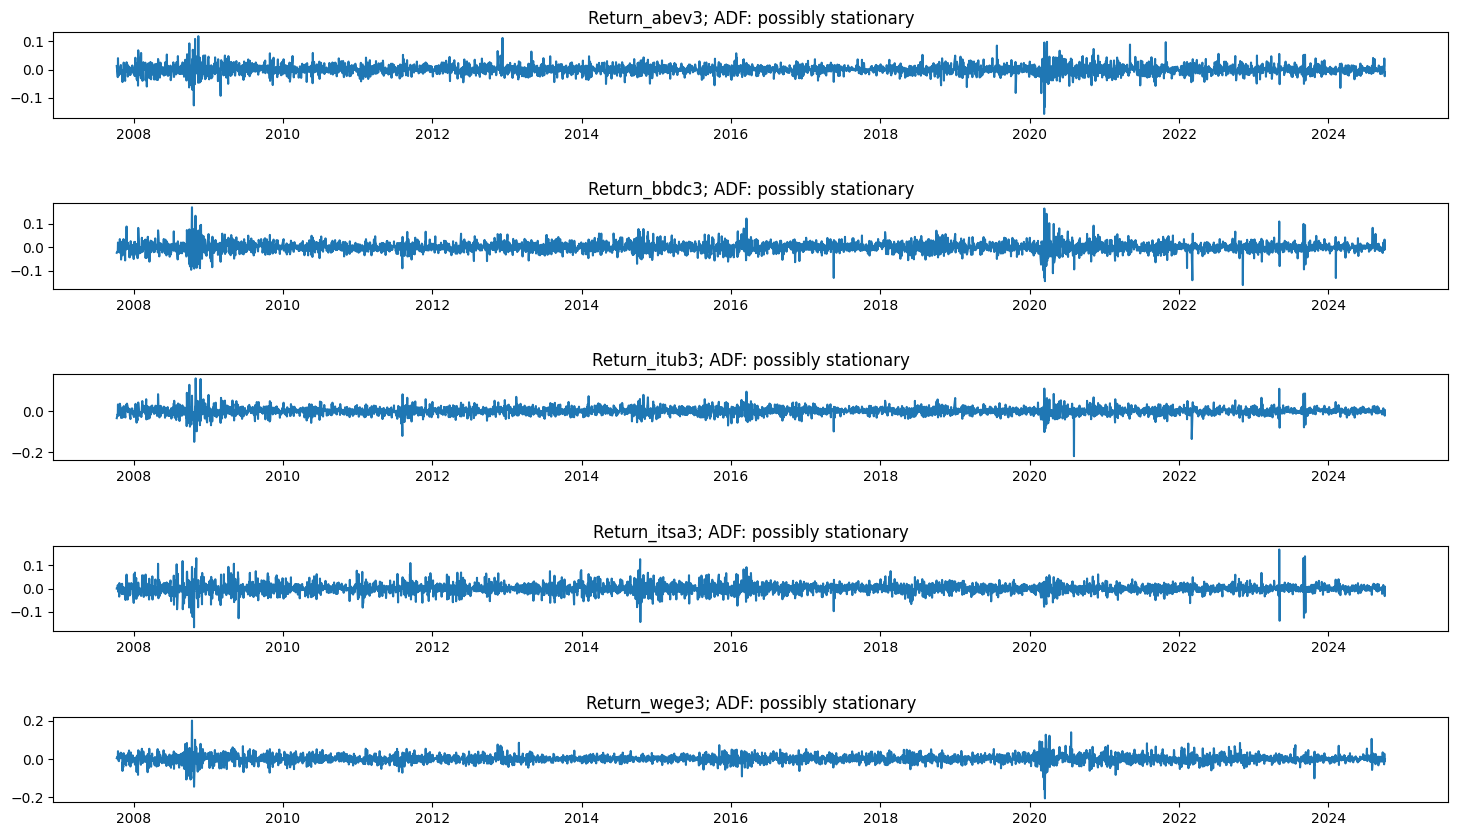

In [40]:
plt.figure(figsize=(18, 10))
for i, col in enumerate([col for col in stocks_df.columns.tolist() if "Return_" in col]):

    _, p_value = adf_test(stocks_df[col])

    plt.subplot(5, 1, i+1)
    plt.axis(True)
    plt.plot(stocks_df[col])
    plt.title(f"{col}; ADF: {'possibly stationary' if p_value < 0.05 else 'possibly non-stationary'}")
    plt.subplots_adjust(wspace=0.2, hspace=1.0)

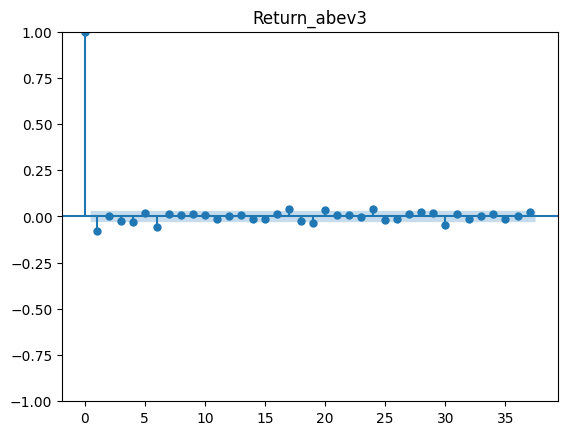

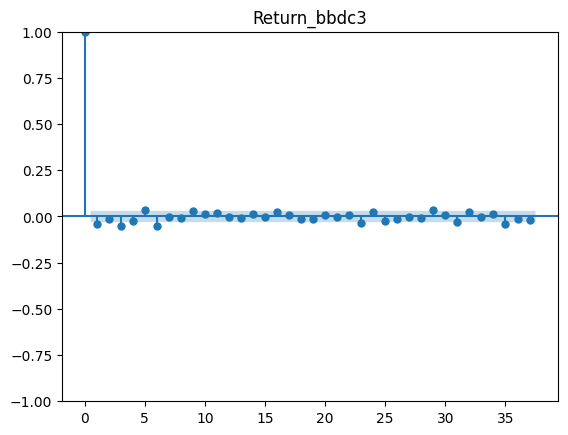

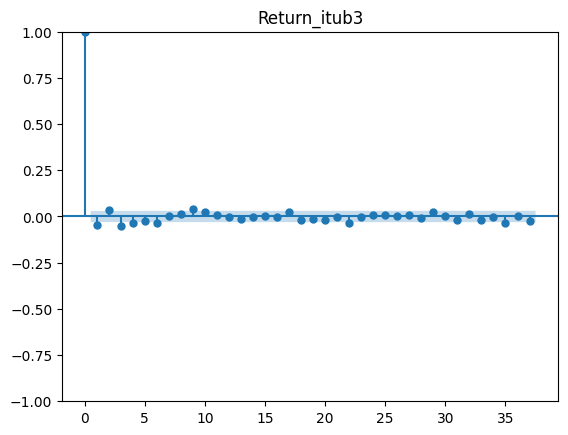

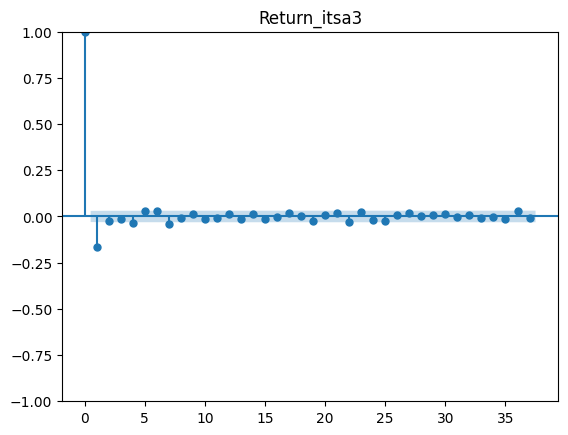

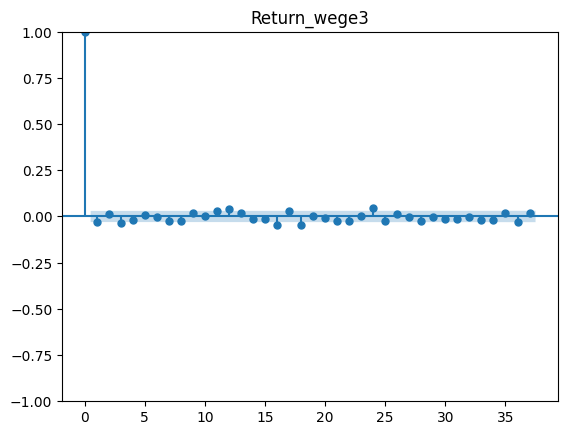

In [41]:
for i, col in enumerate([col for col in stocks_df.columns.tolist() if "Return_" in col]):

    # print(acf(stocks_df[col]))
    plot_acf(stocks_df[col], title=col)
    plt.subplots_adjust(wspace=0.2, hspace=1.0)

Shapiro-Wilk Statistic: 0.9404390537904097
P-Value: 3.4647563709880827e-38
H0 rejected, distribution can't be said Normal
Shapiro-Wilk Statistic: 0.9348584346672091
P-Value: 1.636872547307974e-39
H0 rejected, distribution can't be said Normal
Shapiro-Wilk Statistic: 0.928262637934504
P-Value: 5.755061300774304e-41
H0 rejected, distribution can't be said Normal
Shapiro-Wilk Statistic: 0.9314833558580566
P-Value: 2.8571418135973056e-40
H0 rejected, distribution can't be said Normal
Shapiro-Wilk Statistic: 0.938757809286279
P-Value: 1.349529728620439e-38
H0 rejected, distribution can't be said Normal


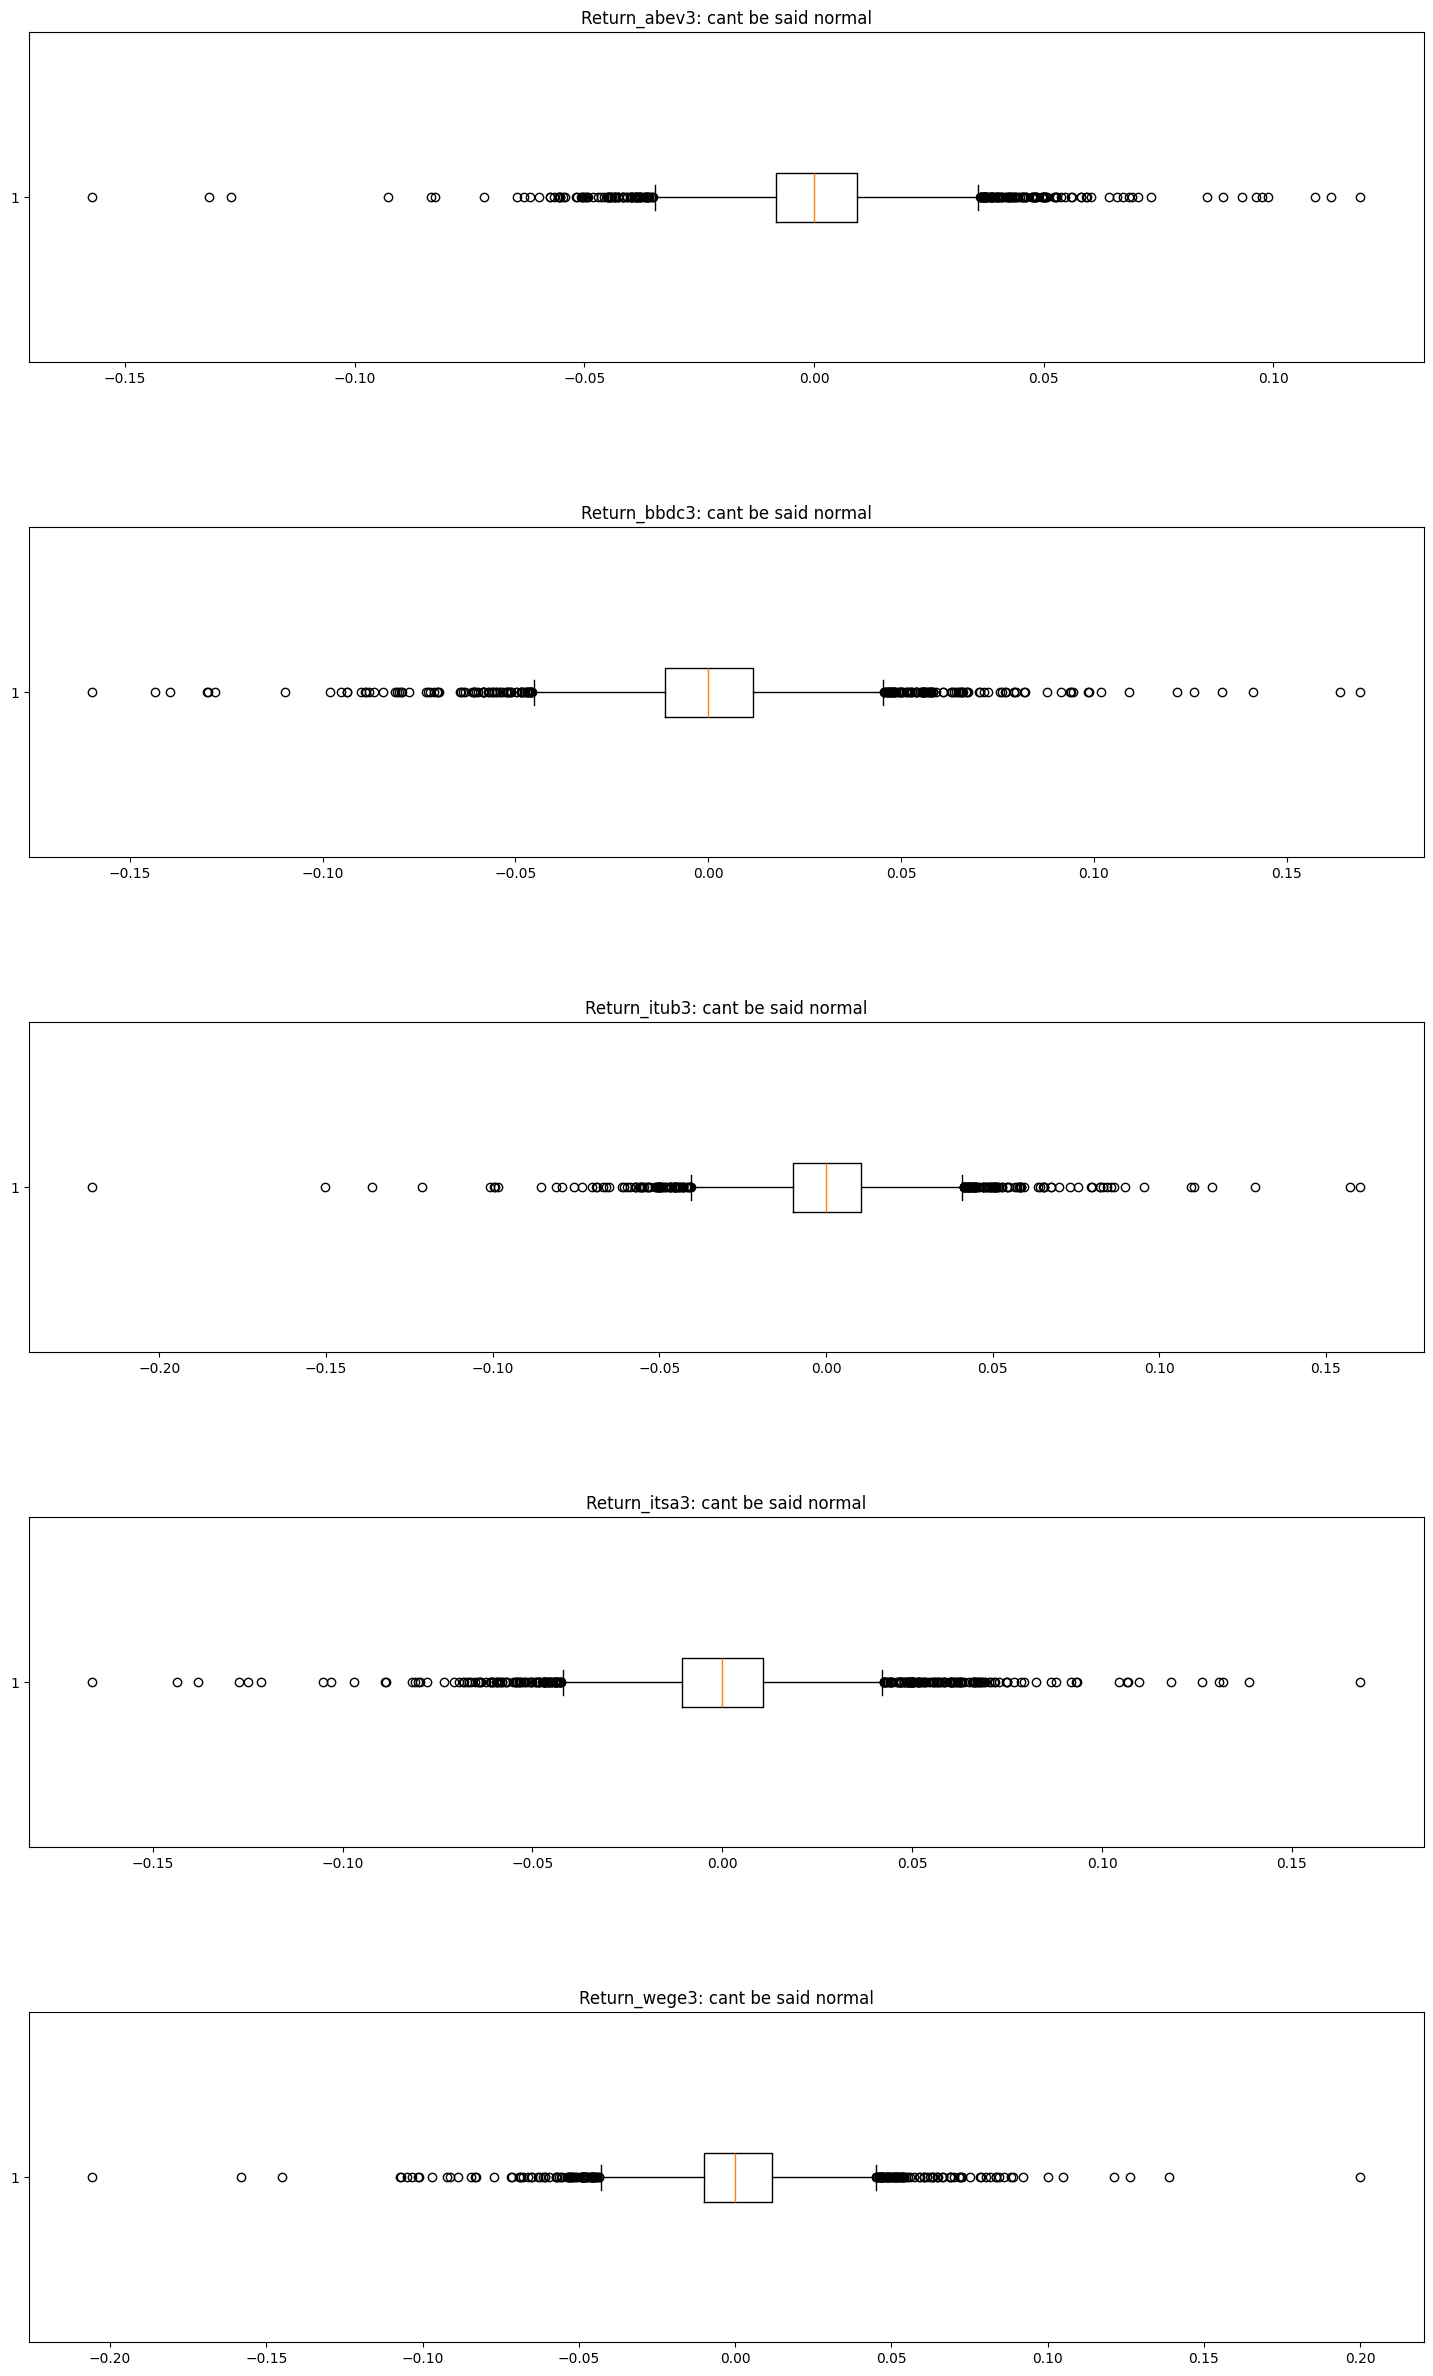

In [42]:
plt.figure(figsize=(18, 30))
for i, col in enumerate([col for col in stocks_df.columns.tolist() if "Return_" in col]):

    _, p_value = shapiro_wilk_gaussian_test(stocks_df[col])

    plt.subplot(5, 1, i+1)
    plt.axis(True)
    plt.boxplot(stocks_df[col], vert=False)
    plt.title(f"{col}: {'cant be said normal' if p_value < 0.05 else 'possibly normal'}")
    plt.subplots_adjust(wspace=0.2, hspace=0.5)

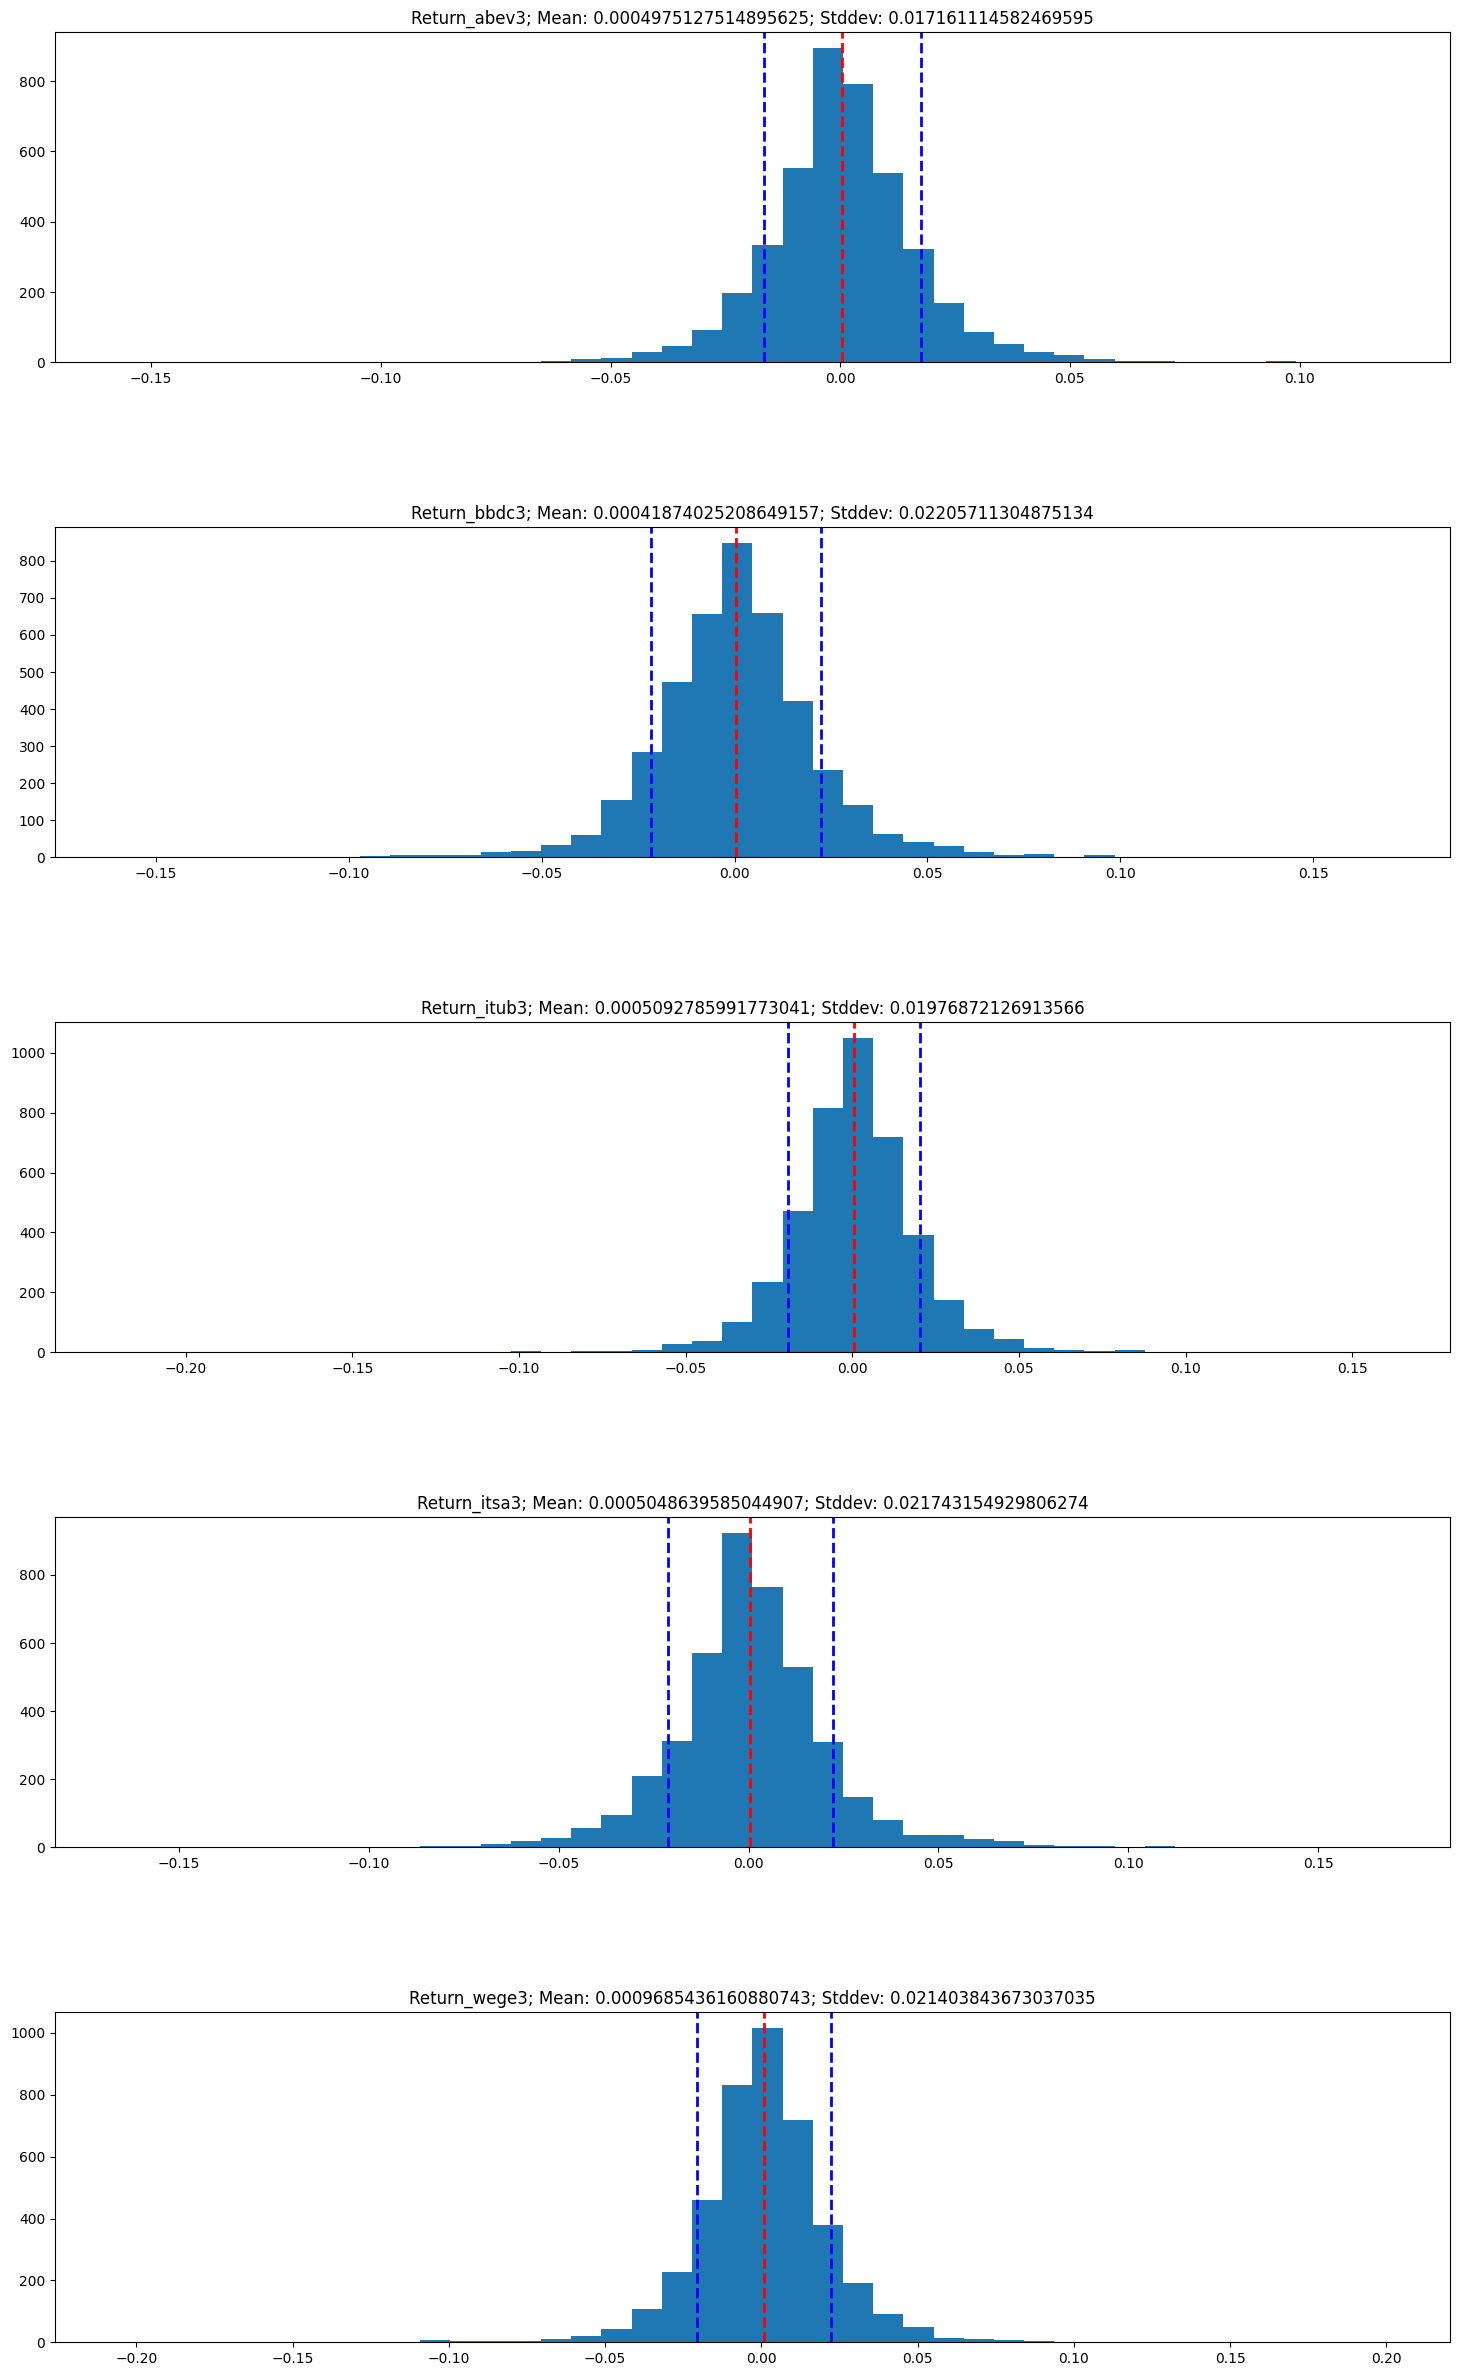

In [43]:
plt.figure(figsize=(18, 30))
for i, col in enumerate([col for col in stocks_df.columns.tolist() if "Return_" in col]):

    mean = np.array(stocks_df[col]).mean()
    std = np.array(stocks_df[col]).std()

    plt.subplot(5, 1, i+1)
    plt.axis(True)
    plt.hist(stocks_df[col], bins=math.floor(len(stocks_df)/100))
    plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
    plt.axvline(mean + std, color='blue', linestyle='dashed', linewidth=2, label=f'Mean + 1 Std Dev: {mean + std:.2f}')
    plt.axvline(mean - std, color='blue', linestyle='dashed', linewidth=2, label=f'Mean - 1 Std Dev: {mean - std:.2f}')
    plt.title(f"{col}; Mean: {mean}; Stddev: {std}")
    plt.subplots_adjust(wspace=0.2, hspace=0.5)

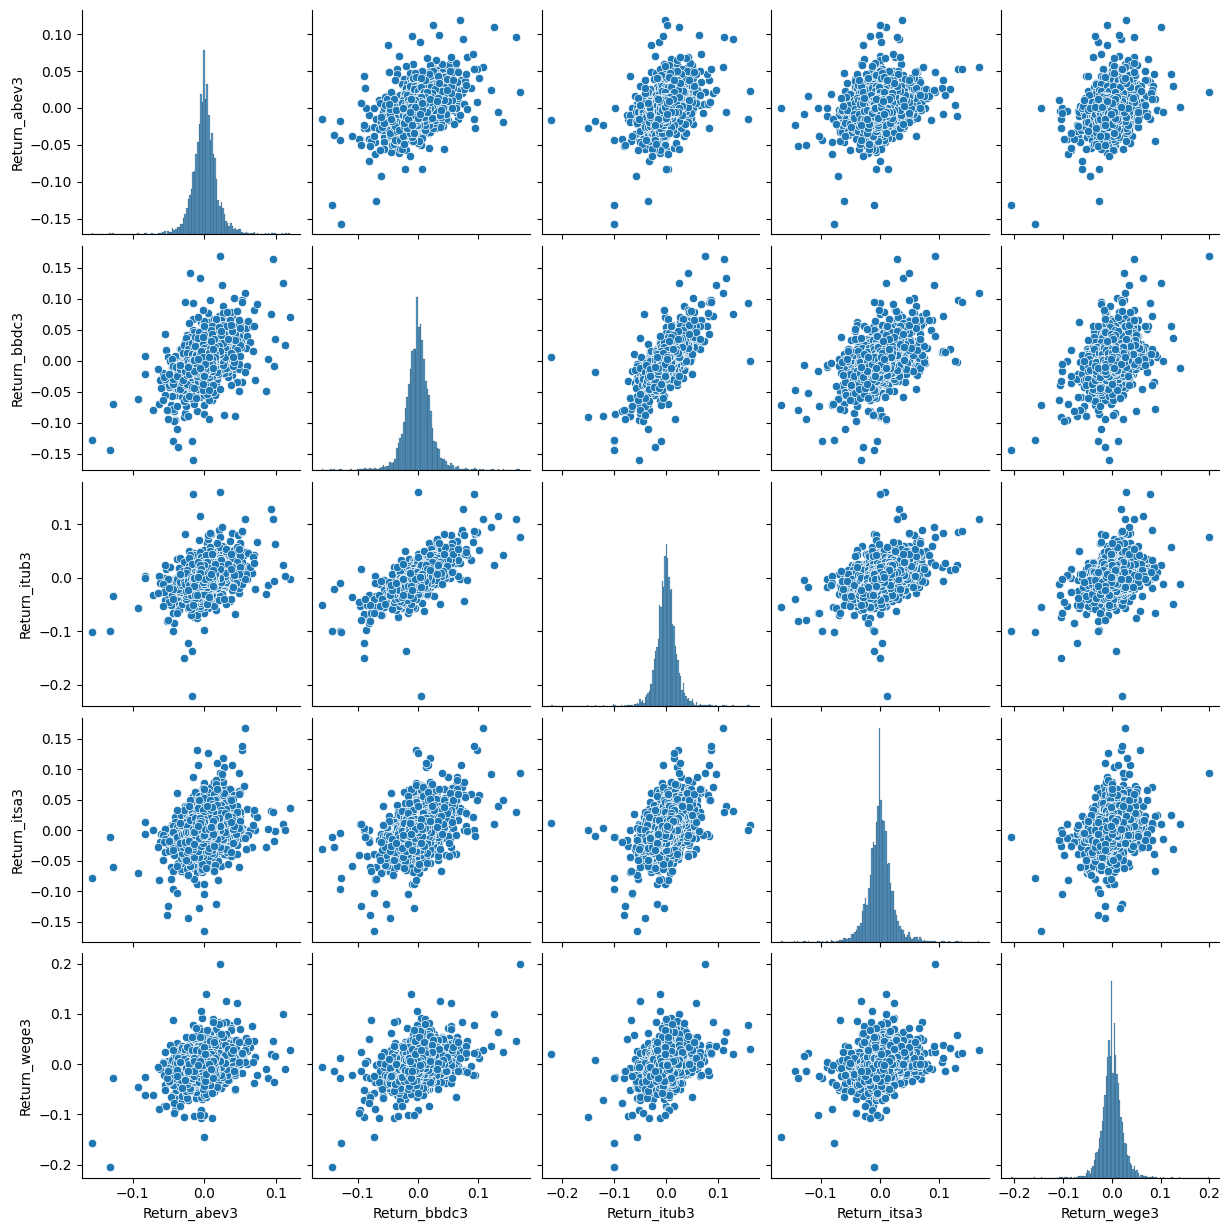

In [44]:
sns.pairplot(stocks_df[[col for col in stocks_df.columns.tolist() if "Return" in col]])

<Axes: >

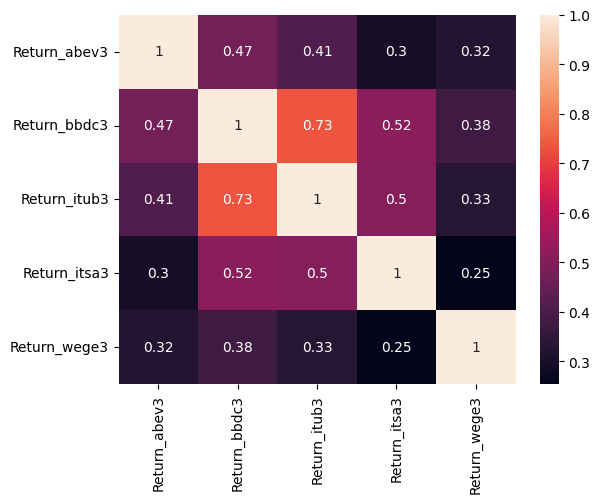

In [45]:
sns.heatmap(stocks_df[[col for col in stocks_df.columns.tolist() if "Return" in col]].corr(), annot=True)

O pairplot e o heatmap de correlação apontam que dificilmente qualquer uma série teria poder preditivo linear sobre as outras por não apresentarem uma correlação de Pearson significativa, exceto itub3 e bbdc3, o que faz sentido pois são duas ações do mesmo setor (bancário).

In [46]:
return_cols_names = filter(lambda x: "Return_" in x, stocks_df.columns.tolist())
stocks_df[return_cols_names].describe()

Return_abev3  Return_bbdc3  Return_itub3  Return_itsa3  Return_wege3
count   4211.000000   4211.000000   4211.000000   4211.000000   4211.000000
mean       0.000498      0.000419      0.000509      0.000505      0.000969
std        0.017163      0.022060      0.019771      0.021746      0.021406
min       -0.157168     -0.159763     -0.220203     -0.165992     -0.205761
25%       -0.008318     -0.011242     -0.009860     -0.010506     -0.010100
50%        0.000000      0.000000      0.000000      0.000000      0.000000
75%        0.009434      0.011498      0.010580      0.010674      0.011955
max        0.118919      0.169014      0.160271      0.167989      0.200000

As séries de retornos são todas estacionárias e não seguem uma distribuição normal, de acordo com o teste ADF e o teste de Shapiro-Wilk, com uma média ligeiramente inclinada para o lado positivo. A média positiva indica que essas séries geraram retornos positivos com mais frequência do que negativos, e comprar e manter essas ações durante esse período resultaria, ao final, em um resultado financeiro positivo. Todas as séries têm outliers bem acima e abaixo dos limites, o que pode estar influenciando o teste de Shapiro-Wilk

In [47]:
price_cols = [col for col in stocks_df.columns.tolist() if "Price" in col]
for col in price_cols:
    new_df = pd.DataFrame()
    new_df[col] = stocks_df[col]
    new_df[f"{col}_shifted"] = stocks_df[col].shift(1)
    new_df.dropna(axis=0, inplace=True)
    print(f"corr between {col} and itself lagged: {pearsonr(new_df[col], new_df[f"{col}_shifted"])}")

SyntaxError: f-string: unmatched '[' (4278593434.py, line 7)

In [48]:
return_cols = [col for col in stocks_df.columns.tolist() if "Return" in col and "lag" not in col]
for col in return_cols:
    new_df = pd.DataFrame()
    new_df[col] = stocks_df[col]
    new_df[f"{col}_shifted"] = stocks_df[col].shift(1)
    new_df.dropna(axis=0, inplace=True)
    print(f"corr between {col} and itself lagged: {pearsonr(new_df[col], new_df[f"{col}_shifted"])}")

SyntaxError: f-string: unmatched '[' (1108843686.py, line 7)

Reforçando o argumento pró-retornos. As séries de preços tem alta correlação entre a série e a série atrasada, enquanto a série de retornos diferenciada não, mas a alta correlação é devido a tendência linear e não devido a poder preditivo real.

## Montando o dataframe

In [49]:
def compute_lags(df: pd.DataFrame, column_names: list[str], lags: int = 5):
    for col in column_names:
        if "Return" in col:
            for i in range(lags - 1):
                df[f"{col}_lag_{i+1}"] = df[f"{col}"].shift(i+1)

In [50]:
stocks_df.head()

Price_abev3  Price_bbdc3  Price_itub3  Price_itsa3  Price_wege3  \
Date                                                                          
2007-10-11         3.08         6.20         7.87         3.43         2.44   
2007-10-15         3.02         6.09         7.75         3.43         2.47   
2007-10-16         2.94         5.97         7.61         3.48         2.47   
2007-10-17         3.06         6.09         7.86         3.48         2.57   
2007-10-18         3.07         6.09         7.69         3.48         2.59   

            Return_abev3  Return_bbdc3  Return_itub3  Return_itsa3  \
Date                                                                 
2007-10-11      0.013158     -0.023622     -0.034356      0.000000   
2007-10-15     -0.019481     -0.017742     -0.015248      0.000000   
2007-10-16     -0.026490     -0.019704     -0.018065      0.014577   
2007-10-17      0.040816      0.020101      0.032852      0.000000   
2007-10-18      0.003268      0.000000     -0.021628      0.000000   

            Return_wege3  
Date                      
2007-10-11      0.004115  
2007-10-15      0.012295  
2007-10-16      0.000000  
2007-10-17      0.040486  
2007-10-18      0.007782

In [51]:
def compute_targets(df: pd.DataFrame, column_names: list[str]):
    df["abev3_y"] = df["Return_abev3"].shift(-1) > 0
    df["bbdc3_y"] = df["Return_bbdc3"].shift(-1) > 0
    df["itsa3_y"] = df["Return_itsa3"].shift(-1) > 0
    df["itub3_y"] = df["Return_itub3"].shift(-1) > 0
    df["wege3_y"] = df["Return_wege3"].shift(-1) > 0

In [52]:
compute_targets(stocks_df, stocks_df.columns.tolist())
stocks_df.head(15)

Price_abev3  Price_bbdc3  Price_itub3  Price_itsa3  Price_wege3  \
Date                                                                          
2007-10-11         3.08         6.20         7.87         3.43         2.44   
2007-10-15         3.02         6.09         7.75         3.43         2.47   
2007-10-16         2.94         5.97         7.61         3.48         2.47   
2007-10-17         3.06         6.09         7.86         3.48         2.57   
2007-10-18         3.07         6.09         7.69         3.48         2.59   
2007-10-19         3.00         6.09         7.52         3.43         2.57   
2007-10-22         3.00         6.13         7.57         3.50         2.54   
2007-10-23         3.00         6.19         7.70         3.38         2.58   
2007-10-24         3.00         6.23         7.59         3.46         2.65   
2007-10-25         2.95         6.09         7.44         3.45         2.66   
2007-10-26         2.97         6.30         7.71         3.45         2.70   
2007-10-29         2.99         6.29         7.87         3.40         2.74   
2007-10-30         3.03         6.21         7.76         3.43         2.75   
2007-10-31         3.08         6.36         7.87         3.43         2.84   
2007-11-01         3.09         6.03         7.61         3.44         2.87   

            Return_abev3  Return_bbdc3  Return_itub3  Return_itsa3  \
Date                                                                 
2007-10-11      0.013158     -0.023622     -0.034356      0.000000   
2007-10-15     -0.019481     -0.017742     -0.015248      0.000000   
2007-10-16     -0.026490     -0.019704     -0.018065      0.014577   
2007-10-17      0.040816      0.020101      0.032852      0.000000   
2007-10-18      0.003268      0.000000     -0.021628      0.000000   
2007-10-19     -0.022801      0.000000     -0.022107     -0.014368   
2007-10-22      0.000000      0.006568      0.006649      0.020408   
2007-10-23      0.000000      0.009788      0.017173     -0.034286   
2007-10-24      0.000000      0.006462     -0.014286      0.023669   
2007-10-25     -0.016667     -0.022472     -0.019763     -0.002890   
2007-10-26      0.006780      0.034483      0.036290      0.000000   
2007-10-29      0.006734     -0.001587      0.020752     -0.014493   
2007-10-30      0.013378     -0.012719     -0.013977      0.008824   
2007-10-31      0.016502      0.024155      0.014175      0.000000   
2007-11-01      0.003247     -0.051887     -0.033037      0.002915   

            Return_wege3  abev3_y  bbdc3_y  itsa3_y  itub3_y  wege3_y  
Date                                                                   
2007-10-11      0.004115    False    False    False    False     True  
2007-10-15      0.012295    False    False     True    False    False  
2007-10-16      0.000000     True     True    False     True     True  
2007-10-17      0.040486     True    False    False    False     True  
2007-10-18      0.007782    False    False    False    False    False  
2007-10-19     -0.007722    False     True     True     True    False  
2007-10-22     -0.011673    False     True    False     True     True  
2007-10-23      0.015748    False     True     True    False     True  
2007-10-24      0.027132    False    False    False    False     True  
2007-10-25      0.003774     True     True    False     True     True  
2007-10-26      0.015038     True    False    False     True     True  
2007-10-29      0.014815     True    False     True    False     True  
2007-10-30      0.003650     True     True    False     True     True  
2007-10-31      0.032727     True    False     True    False     True  
2007-11-01      0.010563    False     True    False    False     True

In [53]:
compute_lags(stocks_df, stocks_df.columns.tolist())

stocks_df.head()

Price_abev3  Price_bbdc3  Price_itub3  Price_itsa3  Price_wege3  \
Date                                                                          
2007-10-11         3.08         6.20         7.87         3.43         2.44   
2007-10-15         3.02         6.09         7.75         3.43         2.47   
2007-10-16         2.94         5.97         7.61         3.48         2.47   
2007-10-17         3.06         6.09         7.86         3.48         2.57   
2007-10-18         3.07         6.09         7.69         3.48         2.59   

            Return_abev3  Return_bbdc3  Return_itub3  Return_itsa3  \
Date                                                                 
2007-10-11      0.013158     -0.023622     -0.034356      0.000000   
2007-10-15     -0.019481     -0.017742     -0.015248      0.000000   
2007-10-16     -0.026490     -0.019704     -0.018065      0.014577   
2007-10-17      0.040816      0.020101      0.032852      0.000000   
2007-10-18      0.003268      0.000000     -0.021628      0.000000   

            Return_wege3  ...  Return_itub3_lag_3  Return_itub3_lag_4  \
Date                      ...                                           
2007-10-11      0.004115  ...                 NaN                 NaN   
2007-10-15      0.012295  ...                 NaN                 NaN   
2007-10-16      0.000000  ...                 NaN                 NaN   
2007-10-17      0.040486  ...           -0.034356                 NaN   
2007-10-18      0.007782  ...           -0.015248           -0.034356   

            Return_itsa3_lag_1  Return_itsa3_lag_2  Return_itsa3_lag_3  \
Date                                                                     
2007-10-11                 NaN                 NaN                 NaN   
2007-10-15            0.000000                 NaN                 NaN   
2007-10-16            0.000000            0.000000                 NaN   
2007-10-17            0.014577            0.000000                 0.0   
2007-10-18            0.000000            0.014577                 0.0   

            Return_itsa3_lag_4  Return_wege3_lag_1  Return_wege3_lag_2  \
Date                                                                     
2007-10-11                 NaN                 NaN                 NaN   
2007-10-15                 NaN            0.004115                 NaN   
2007-10-16                 NaN            0.012295            0.004115   
2007-10-17                 NaN            0.000000            0.012295   
2007-10-18                 0.0            0.040486            0.000000   

            Return_wege3_lag_3  Return_wege3_lag_4  
Date                                                
2007-10-11                 NaN                 NaN  
2007-10-15                 NaN                 NaN  
2007-10-16                 NaN                 NaN  
2007-10-17            0.004115                 NaN  
2007-10-18            0.012295            0.004115  

[5 rows x 35 columns]

In [54]:
stocks_df[[col for col in stocks_df.columns.tolist() if "abev3" in col]].head()

Price_abev3  Return_abev3  abev3_y  Return_abev3_lag_1  \
Date                                                                 
2007-10-11         3.08      0.013158    False                 NaN   
2007-10-15         3.02     -0.019481    False            0.013158   
2007-10-16         2.94     -0.026490     True           -0.019481   
2007-10-17         3.06      0.040816     True           -0.026490   
2007-10-18         3.07      0.003268    False            0.040816   

            Return_abev3_lag_2  Return_abev3_lag_3  Return_abev3_lag_4  
Date                                                                    
2007-10-11                 NaN                 NaN                 NaN  
2007-10-15                 NaN                 NaN                 NaN  
2007-10-16            0.013158                 NaN                 NaN  
2007-10-17           -0.019481            0.013158                 NaN  
2007-10-18           -0.026490           -0.019481            0.013158

In [55]:
stocks_df[[col for col in stocks_df.columns.tolist() if "abev3" in col or "median" in col]].head(10)

Price_abev3  Return_abev3  abev3_y  Return_abev3_lag_1  \
Date                                                                 
2007-10-11         3.08      0.013158    False                 NaN   
2007-10-15         3.02     -0.019481    False            0.013158   
2007-10-16         2.94     -0.026490     True           -0.019481   
2007-10-17         3.06      0.040816     True           -0.026490   
2007-10-18         3.07      0.003268    False            0.040816   
2007-10-19         3.00     -0.022801    False            0.003268   
2007-10-22         3.00      0.000000    False           -0.022801   
2007-10-23         3.00      0.000000    False            0.000000   
2007-10-24         3.00      0.000000    False            0.000000   
2007-10-25         2.95     -0.016667     True            0.000000   

            Return_abev3_lag_2  Return_abev3_lag_3  Return_abev3_lag_4  
Date                                                                    
2007-10-11                 NaN                 NaN                 NaN  
2007-10-15                 NaN                 NaN                 NaN  
2007-10-16            0.013158                 NaN                 NaN  
2007-10-17           -0.019481            0.013158                 NaN  
2007-10-18           -0.026490           -0.019481            0.013158  
2007-10-19            0.040816           -0.026490           -0.019481  
2007-10-22            0.003268            0.040816           -0.026490  
2007-10-23           -0.022801            0.003268            0.040816  
2007-10-24            0.000000           -0.022801            0.003268  
2007-10-25            0.000000            0.000000           -0.022801

In [56]:
def preprocess_data(data: pd.DataFrame, stock_name: str) -> pd.DataFrame:
    # remove na
    # filter stock
    # remove price
    data = data[[col for col in data.columns.tolist() if stock_name in col or "median" in col]].copy()
    data = data.drop(f"Price_{stock_name}", axis=1)
    data = data.dropna(axis=0)

    return data

preprocess_data(stocks_df, "abev3").head()

Return_abev3  abev3_y  Return_abev3_lag_1  Return_abev3_lag_2  \
Date                                                                        
2007-10-18      0.003268    False            0.040816           -0.026490   
2007-10-19     -0.022801    False            0.003268            0.040816   
2007-10-22      0.000000    False           -0.022801            0.003268   
2007-10-23      0.000000    False            0.000000           -0.022801   
2007-10-24      0.000000    False            0.000000            0.000000   

            Return_abev3_lag_3  Return_abev3_lag_4  
Date                                                
2007-10-18           -0.019481            0.013158  
2007-10-19           -0.026490           -0.019481  
2007-10-22            0.040816           -0.026490  
2007-10-23            0.003268            0.040816  
2007-10-24           -0.022801            0.003268

## Definindo o Sliding Window CV

In [57]:
class SlidingWindowExclusiveTestCV(BaseCrossValidator):
    def __init__(self, train_size: int, val_size: int):
        self.train_size = train_size
        self.val_size = val_size

    def get_n_splits(self, X=None, y=None, groups=None):
        """
        On a CV splitter (not an estimator), returns the number of elements one would get if iterating through 
        the return value of split given the same parameters. Takes the same parameters as split.
        """
        n_samples = len(X)
        count = 0
        for _ in range(0, n_samples - self.train_size - self.val_size + 1, self.val_size):
            count += 1
        return count

    def split(self, X=None, y=None, groups=None):
        """
        On a CV splitter (not an estimator), this method accepts parameters (X, y, groups), where all may be optional, 
        and returns an iterator over (train_idx, test_idx) pairs. Each of {train,test}_idx is a 1d integer array, 
        with values from 0 from X.shape[0] - 1 of any length, such that no values appear in both some train_idx and 
        its corresponding test_idx.
        """
        n_samples = len(X)
        for start in range(0, n_samples - self.train_size - self.val_size + 1, self.val_size):
            # print(start)
            train_indices = np.arange(start, start + self.train_size)
            test_indices = np.arange(start + self.train_size, start + self.train_size + self.val_size)
            yield train_indices, test_indices

In [58]:
def check_time_index_overlap(dataframes):
    # Convert each DataFrame's index to a set for faster intersection checking
    index_sets = [set(df.index) for df in dataframes]
    
    # Check each pair of DataFrames for overlap
    for i in range(len(index_sets)):
        for j in range(i + 1, len(index_sets)):
            if index_sets[i].intersection(index_sets[j]):
                print(f"Overlap found between DataFrame {i} and DataFrame {j}")
                return True

    print("No overlap found; all time indices are mutually exclusive.")
    return False

No overlap found; all time indices are mutually exclusive.


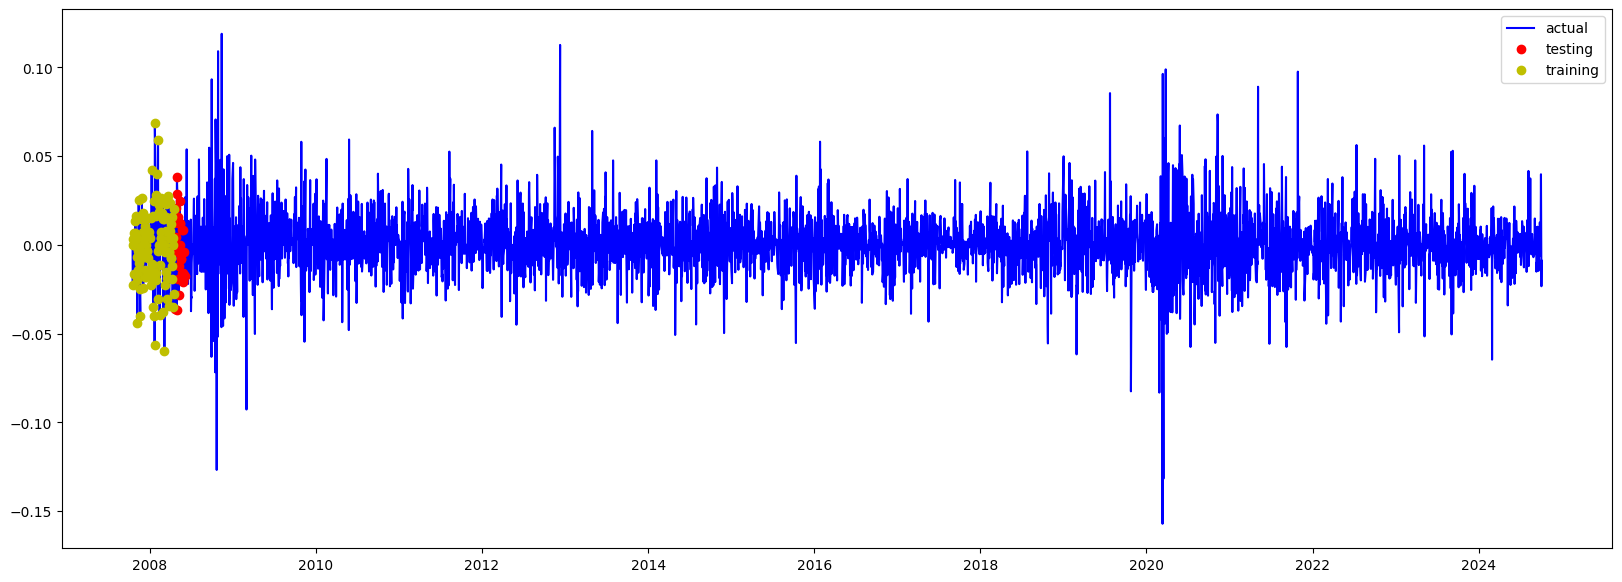

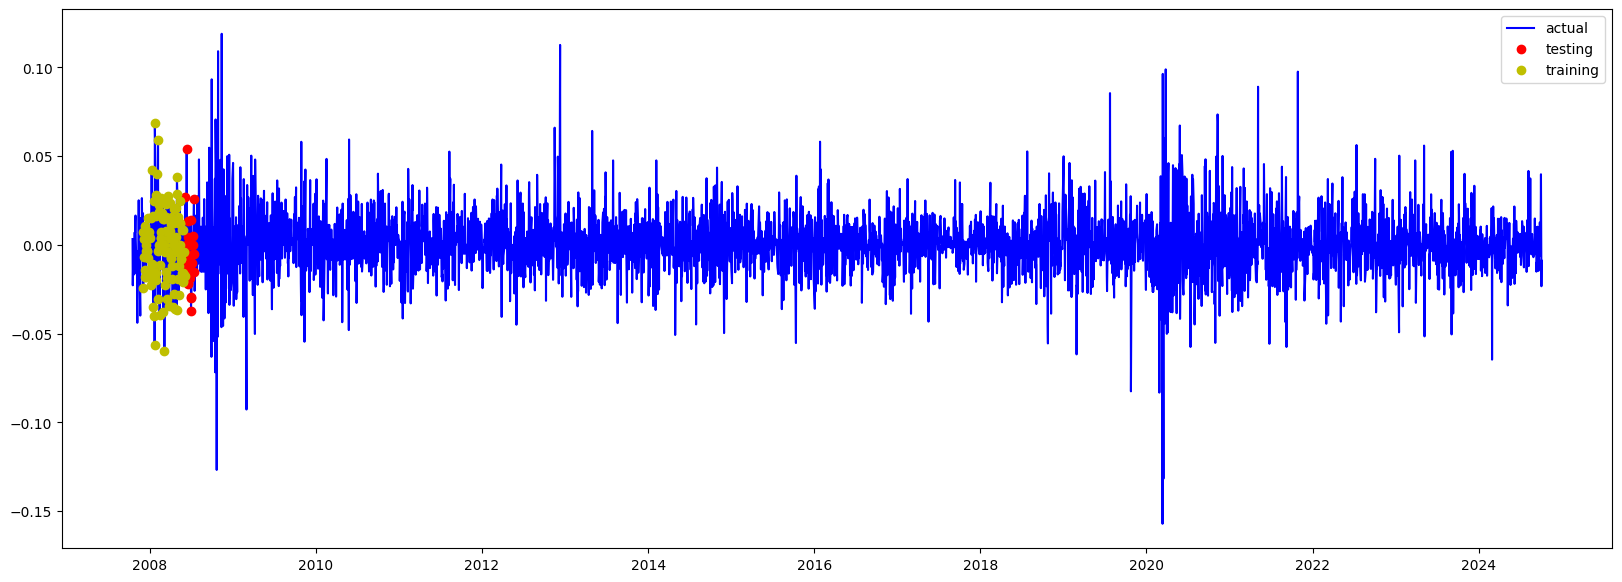

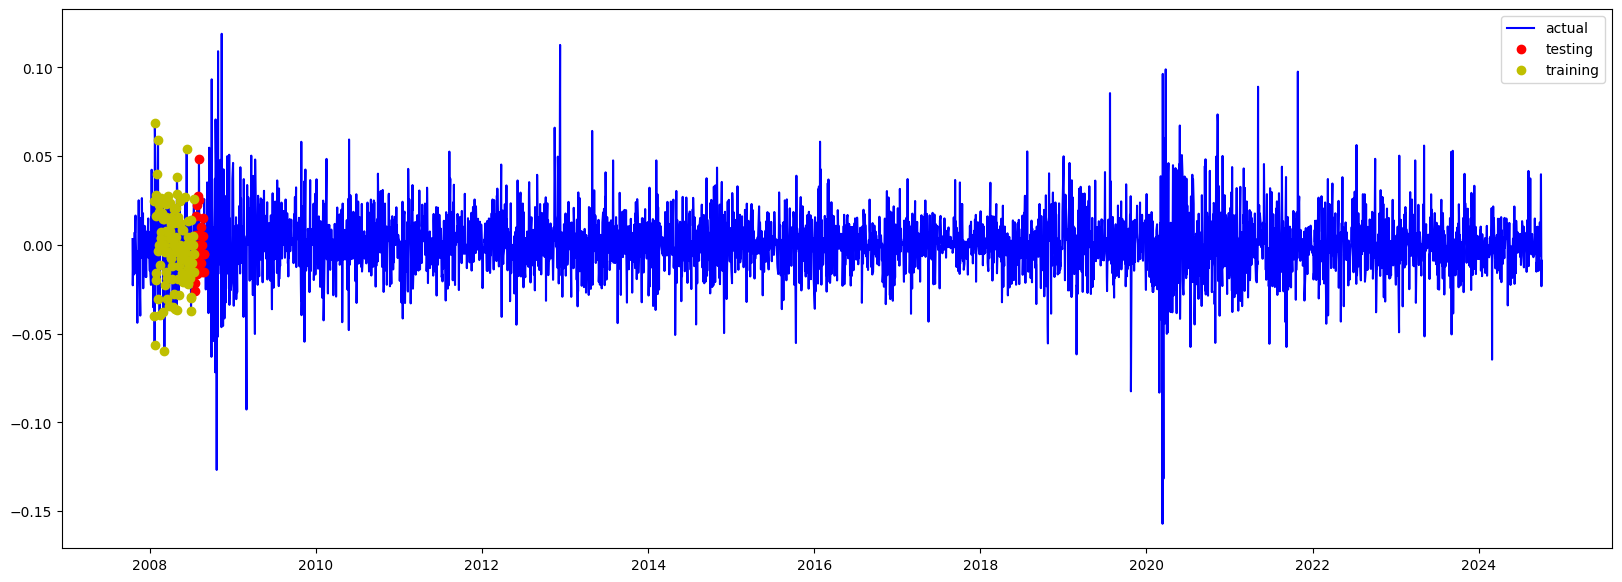

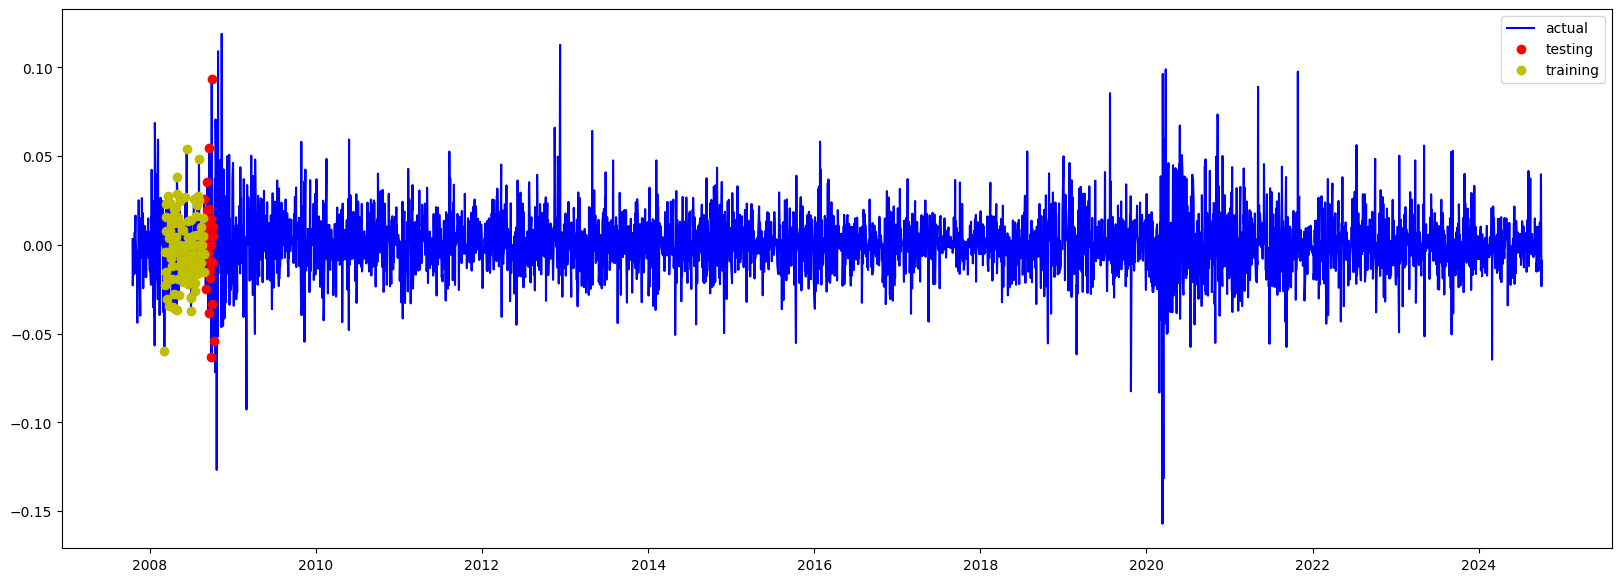

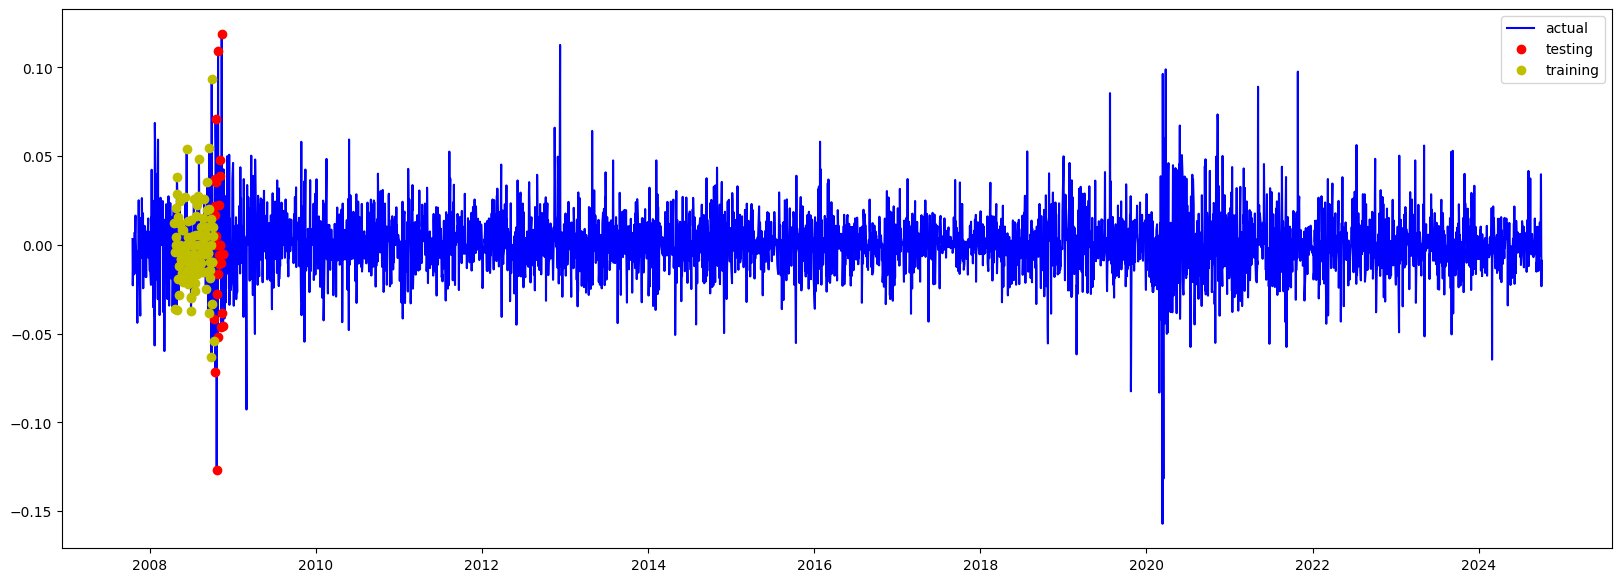

In [59]:
cv = SlidingWindowExclusiveTestCV(120, 30)

count = 0

tests = []
trains = []

df = preprocess_data(stocks_df, "abev3")

for train_index, test_index in cv.split(df["Return_abev3"]):
    X_train, X_test = df["Return_abev3"].iloc[train_index], df["Return_abev3"].iloc[test_index]

    tests.append(X_test)
    trains.append(X_train)

    # if count == 0 or count % 10 == 0:
    if count in range(5):
        plt.figure(figsize=(20, 7))
        # plt.title(regression_metrics(y_test, y_test_pred))
        plt.plot(df.index, df["Return_abev3"], 'b-', label = 'actual')
        plt.plot(X_test.index, X_test, 'ro', label = 'testing')
        plt.plot(X_train.index, X_train, 'yo', label = 'training')
        plt.legend()
        plt.plot()

    count += 1

assert check_time_index_overlap(tests) == False
assert type(tests[0]) == pd.Series
assert trains[0].index[0] == df["Return_abev3"].index[0]

In [60]:
tests[0].index[-1], tests[1].index[0], tests[1].index[-1], tests[2].index[0], tests[2].index[-1], tests[3].index[0]

(Timestamp('2008-06-03 00:00:00'),
 Timestamp('2008-06-04 00:00:00'),
 Timestamp('2008-07-16 00:00:00'),
 Timestamp('2008-07-17 00:00:00'),
 Timestamp('2008-08-27 00:00:00'),
 Timestamp('2008-08-28 00:00:00'))

In [61]:
trains[1].index[-1], tests[1].index[0], trains[2].index[-1], tests[2].index[0], trains[3].index[-1], tests[3].index[0]

(Timestamp('2008-06-03 00:00:00'),
 Timestamp('2008-06-04 00:00:00'),
 Timestamp('2008-07-16 00:00:00'),
 Timestamp('2008-07-17 00:00:00'),
 Timestamp('2008-08-27 00:00:00'),
 Timestamp('2008-08-28 00:00:00'))

treino e teste nao aparentam estar vazando um no outro

In [62]:
def print_simple_metrics(results):
    accs = [i["accuracy"] for i in results]
    print("accuracy: ", np.array(accs).mean())

    f1 = [i["f1"] for i in results]
    print("f1: ", np.array(f1).mean())

    precisions = [i["precision"] for i in results]
    print("precision: ", np.array(precisions).mean())

    recalls = [i["recall"] for i in results]
    print("recall: ", np.array(recalls).mean())

    print("\n")

# LSTM

## Exp 01

In [63]:
TRAINING_EPOCHS = 1
BATCH_SIZE = 16
NUM_EXPERIMENTS = 60

In [64]:
LSTM_HIDDEN_UNITS = 1

TRAIN_SIZE = 120
VAL_SIZE = 30

In [65]:
def define_lstm(data_shape, num_units):
    lstm = Sequential()

    lstm.add(Input(shape=data_shape))
    lstm.add(LSTM(num_units))
    lstm.add(Dense(1, activation="sigmoid"))

    lstm.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    return lstm

In [66]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=25,
    restore_best_weights=True,
	mode='max'
)

def run_lstm_experiment(train_size: int, val_size: int, stock: str, num_units: int, random_seed: int):
    np.random.seed(random_seed)
    random.seed(random_seed)
    tf.random.set_seed(random_seed)

    data = preprocess_data(stocks_df, stock)

    X = data.drop([f"{stock}_y"], axis=1)
    y_ground = data[f"{stock}_y"]

    model = define_lstm((X.shape[1], 1), num_units)
    cv_splitter = SlidingWindowExclusiveTestCV(train_size, val_size)

    tests = []

    for train_index, test_index in cv_splitter.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y_ground.iloc[train_index], y_ground.iloc[test_index]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.fit_transform(X_test)

        model.fit(
            X_train, y_train,
            epochs = TRAINING_EPOCHS,
            batch_size=BATCH_SIZE,
            validation_split=0.2,
            callbacks=[early_stopping],
            shuffle=False,
            verbose=False,
        )

        y_hat = model.predict(X_test, verbose=False)

        y_hat = np.array(y_hat)
        for i in range(len(y_hat)):
            if y_hat[i] > 0.5:
                y_hat[i] = True
            else:
                y_hat[i] = False

        for i, y in enumerate(y_hat):
            tests.append({y_test.index[i]: y})
            
        results = {
            "accuracy": accuracy_score(y_test, y_hat),
            "f1": f1_score(y_test, y_hat),
            "precision": precision_score(y_test, y_hat, zero_division=0),
            "recall": recall_score(y_test, y_hat)
        }

    # all_accs.append(np.array(accs).mean())
    np.random.seed(RANDOM_STATE)
    random.seed(RANDOM_STATE)
    tf.random.set_seed(RANDOM_STATE)

    return results, tests

In [67]:
results_lstm_1_path = "./av02_lstm/results/lstm_01"

if not os.path.isfile(results_lstm_1_path):
    results_lstm_1 = []

    for i in range(NUM_EXPERIMENTS):
        print(f"EXECUTION NUMBER {i+1}")
        abev3_lstm_res, abev3_preds = run_lstm_experiment( 
            TRAIN_SIZE, 
            VAL_SIZE, 
            "abev3", 
            LSTM_HIDDEN_UNITS,
            i
        )
        # print_simple_metrics(abev3_lstm_res)

        bbdc3_lstm_res, bbdc3_preds = run_lstm_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "bbdc3", 
            LSTM_HIDDEN_UNITS,
            i
        )
        # print_simple_metrics(bbdc3_lstm_res)

        itsa3_lstm_res, itsa3_preds = run_lstm_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "itsa3", 
            LSTM_HIDDEN_UNITS,
            i
        )
        # print_simple_metrics(itsa3_lstm_res)

        itub3_lstm_res, itub3_preds = run_lstm_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "itub3", 
            LSTM_HIDDEN_UNITS,
            i
        )
        # print_simple_metrics(itub3_lstm_res)

        wege3_lstm_res, wege3_preds = run_lstm_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "wege3", 
            LSTM_HIDDEN_UNITS,
            i
        )
        # print_simple_metrics(wege3_lstm_res)

        results_lstm_1.append({
            "abev3": (abev3_lstm_res, abev3_preds),
            "bbdc3": (bbdc3_lstm_res, bbdc3_preds),
            "itsa3": (itsa3_lstm_res, itsa3_preds),
            "itub3": (itub3_lstm_res, itub3_preds),
            "wege3": (wege3_lstm_res, wege3_preds)
        })

    !mkdir "./av02_lstm/results/"
    with open(results_lstm_1_path, "wb") as f:
        pickle.dump(results_lstm_1, f)

else:
    with open(results_lstm_1_path, "rb") as f:
        results_lstm_1 = pickle.load(f)

EXECUTION NUMBER 1
EXECUTION NUMBER 2
EXECUTION NUMBER 3
EXECUTION NUMBER 4
EXECUTION NUMBER 5
EXECUTION NUMBER 6
EXECUTION NUMBER 7
EXECUTION NUMBER 8
EXECUTION NUMBER 9
EXECUTION NUMBER 10
EXECUTION NUMBER 11
EXECUTION NUMBER 12
EXECUTION NUMBER 13
EXECUTION NUMBER 14
EXECUTION NUMBER 15
EXECUTION NUMBER 16
EXECUTION NUMBER 17
EXECUTION NUMBER 18
EXECUTION NUMBER 19
EXECUTION NUMBER 20
EXECUTION NUMBER 21
EXECUTION NUMBER 22
EXECUTION NUMBER 23
EXECUTION NUMBER 24
EXECUTION NUMBER 25
EXECUTION NUMBER 26
EXECUTION NUMBER 27
EXECUTION NUMBER 28
EXECUTION NUMBER 29
EXECUTION NUMBER 30
EXECUTION NUMBER 31
EXECUTION NUMBER 32
EXECUTION NUMBER 33
EXECUTION NUMBER 34
EXECUTION NUMBER 35
EXECUTION NUMBER 36
EXECUTION NUMBER 37
EXECUTION NUMBER 38
EXECUTION NUMBER 39
EXECUTION NUMBER 40
EXECUTION NUMBER 41
EXECUTION NUMBER 42
EXECUTION NUMBER 43
EXECUTION NUMBER 44
EXECUTION NUMBER 45
EXECUTION NUMBER 46
EXECUTION NUMBER 47
EXECUTION NUMBER 48
EXECUTION NUMBER 49
EXECUTION NUMBER 50
EXECUTION

In [68]:
results_lstm_1[0]["abev3"]

({'accuracy': 0.6, 'f1': 0.3333333333333333, 'precision': 0.5, 'recall': 0.25},
 [{Timestamp('2008-04-18 00:00:00'): array([0.], dtype=float32)},
  {Timestamp('2008-04-22 00:00:00'): array([0.], dtype=float32)},
  {Timestamp('2008-04-23 00:00:00'): array([0.], dtype=float32)},
  {Timestamp('2008-04-24 00:00:00'): array([1.], dtype=float32)},
  {Timestamp('2008-04-25 00:00:00'): array([0.], dtype=float32)},
  {Timestamp('2008-04-28 00:00:00'): array([1.], dtype=float32)},
  {Timestamp('2008-04-29 00:00:00'): array([0.], dtype=float32)},
  {Timestamp('2008-04-30 00:00:00'): array([0.], dtype=float32)},
  {Timestamp('2008-05-02 00:00:00'): array([0.], dtype=float32)},
  {Timestamp('2008-05-05 00:00:00'): array([0.], dtype=float32)},
  {Timestamp('2008-05-06 00:00:00'): array([0.], dtype=float32)},
  {Timestamp('2008-05-07 00:00:00'): array([0.], dtype=float32)},
  {Timestamp('2008-05-08 00:00:00'): array([0.], dtype=float32)},
  {Timestamp('2008-05-09 00:00:00'): array([0.], dtype=float32

In [69]:
return_cols = [col for col in stocks_df.columns.tolist() if "Return" in col and "lag" not in col]
return_cols

['Return_abev3',
 'Return_bbdc3',
 'Return_itub3',
 'Return_itsa3',
 'Return_wege3']

In [70]:
list(results_lstm_1[0]["abev3"][1][0].keys())[0], list(results_lstm_1[0]["bbdc3"][1][0].keys())[0], list(results_lstm_1[0]["itsa3"][1][0].keys())[0], list(results_lstm_1[0]["wege3"][1][0].keys())[0]

(Timestamp('2008-04-18 00:00:00'),
 Timestamp('2008-04-18 00:00:00'),
 Timestamp('2008-04-18 00:00:00'),
 Timestamp('2008-04-18 00:00:00'))

In [71]:
results_lstm_1[0]["abev3"][1][0].keys()

dict_keys([Timestamp('2008-04-18 00:00:00')])

In [72]:
list(results_lstm_1[0]["abev3"][1][-1].keys())[0], list(results_lstm_1[0]["bbdc3"][1][-1].keys())[0], list(results_lstm_1[0]["itsa3"][1][-1].keys())[0], list(results_lstm_1[0]["wege3"][1][-1].keys())[0]

(Timestamp('2024-09-25 00:00:00'),
 Timestamp('2024-09-25 00:00:00'),
 Timestamp('2024-09-25 00:00:00'),
 Timestamp('2024-09-25 00:00:00'))

Séries começam e terminam no mesmo ponto

In [73]:
start_date1 = list(results_lstm_1[0]["abev3"][1][0].keys())[0]
end_date1 = list(results_lstm_1[0]["abev3"][1][-1].keys())[0]

In [74]:
daily_returns = stocks_df[return_cols].loc[start_date1 : end_date1]
daily_returns

Return_abev3  Return_bbdc3  Return_itub3  Return_itsa3  \
Date                                                                 
2008-04-18      0.012146      0.007505      0.025788     -0.029070   
2008-04-22     -0.036000     -0.007449     -0.009777     -0.008982   
2008-04-23     -0.004149      0.001876     -0.012694     -0.015106   
2008-04-24      0.004167      0.005618     -0.002857     -0.003067   
2008-04-25      0.020747      0.011173     -0.022923      0.006154   
...                  ...           ...           ...           ...   
2024-09-19     -0.002311     -0.010279     -0.007190      0.006312   
2024-09-20     -0.014672     -0.017062     -0.015743     -0.022401   
2024-09-23     -0.000784     -0.024151     -0.001599     -0.008249   
2024-09-24      0.000784     -0.004640     -0.002884      0.001848   
2024-09-25     -0.006270     -0.012432      0.009319      0.011070   

            Return_wege3  
Date                      
2008-04-18     -0.014634  
2008-04-22      0.000000  
2008-04-23     -0.039604  
2008-04-24     -0.015464  
2008-04-25      0.020942  
...                  ...  
2024-09-19     -0.001877  
2024-09-20     -0.013912  
2024-09-23      0.034318  
2024-09-24      0.019724  
2024-09-25      0.005242  

[4080 rows x 5 columns]

In [75]:
def compute_sharpe_ratio(portfolio_daily_returns):
    risk_free_daily_rate = 0.00026115787606784124  # considering SELIC at an arbitrary avg of 10% year

    avg_return = portfolio_daily_returns.mean()
    std_dev_return = portfolio_daily_returns.std()

    return (avg_return - risk_free_daily_rate) / std_dev_return

In [76]:
def compute_buyandhold_cumulative_returns(returns_series):
    # Define portfolio weights (example: equal weights for each stock)
    weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

    # Calculate daily portfolio returns
    portfolio_returns = returns_series.dot(weights)

    # Calculate cumulative returns
    cumulative_returns = (1 + portfolio_returns).cumprod()

    # Convert to DataFrame for plotting
    cumulative_returns_df = pd.DataFrame({'Cumulative Return': cumulative_returns}, index=returns_series.index)

    return cumulative_returns_df, portfolio_returns

In [77]:
def plot_cumulative_returns_line_chart(series, title = "Cumulative Returns over time"):
    plt.figure(figsize=(20, 7))
    plt.plot(series.index, series, 'b-')
    plt.title(title)

    max_idx = np.nanargmax(series)
    min_idx = np.nanargmin(series)

    print(series.to_numpy()[min_idx])

    plt.annotate(
        f"Max: {series.to_numpy()[max_idx]}",
        (series.index[max_idx], series.to_numpy()[max_idx]),
        xytext=(series.index[max_idx], series.to_numpy()[max_idx] + 0.5),
        arrowprops=dict(facecolor='green', arrowstyle='->'),
        color='green',
    )

    plt.annotate(
        f"Min: {series.to_numpy()[min_idx]}",
        (series.index[min_idx], series.to_numpy()[min_idx]),
        xytext=(series.index[min_idx], series.to_numpy()[min_idx] - 2),
        arrowprops=dict(facecolor='red', arrowstyle='->'),
        color='red',
    )
    plt.plot()

[0.5940447]


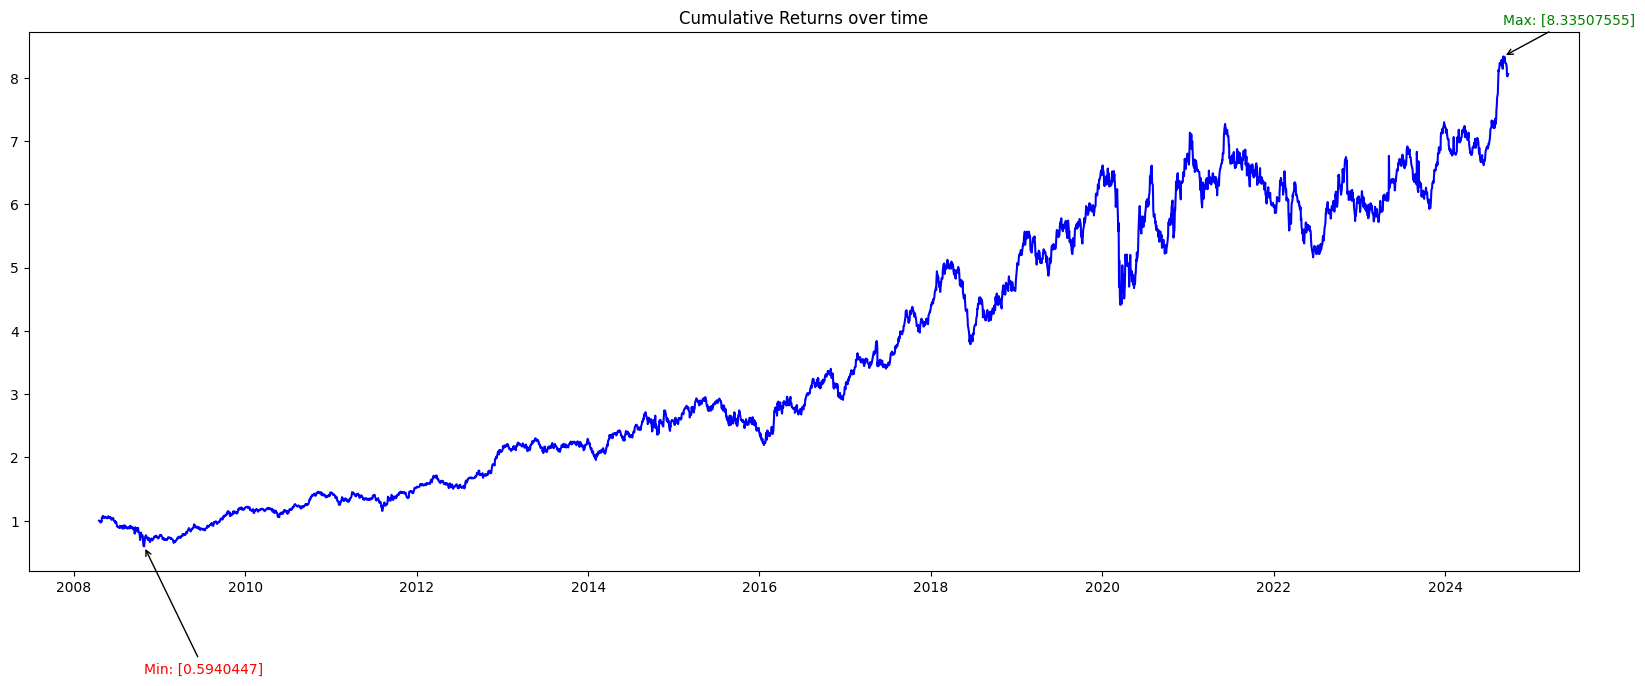

In [78]:
buy_and_hold_cuml_returns, portfolio_returns = compute_buyandhold_cumulative_returns(daily_returns)
plot_cumulative_returns_line_chart(buy_and_hold_cuml_returns)

In [79]:
buy_and_hold_sharpe = compute_sharpe_ratio(portfolio_returns)
buy_and_hold_sharpe

0.024224349918021783

In [80]:
def compute_cumulative_returns_pred(abev3_preds, bbdc3_preds, itsa3_preds, itub3_preds, wege3_preds):
    inclusion_mask = pd.DataFrame({
    'Return_abev3': pd.Series([list(val.values())[0][0] for val in abev3_preds], index=[list(val.keys())[0] for val in abev3_preds]),
    'Return_bbdc3': pd.Series([list(val.values())[0][0] for val in bbdc3_preds], index=[list(val.keys())[0] for val in bbdc3_preds]),
    'Return_itsa3': pd.Series([list(val.values())[0][0] for val in itsa3_preds], index=[list(val.keys())[0] for val in itsa3_preds]),
    'Return_itub3': pd.Series([list(val.values())[0][0] for val in itub3_preds], index=[list(val.keys())[0] for val in itub3_preds]),
    'Return_wege3': pd.Series([list(val.values())[0][0] for val in wege3_preds], index=[list(val.keys())[0] for val in wege3_preds]),
    })

    # Apply mask to daily returns
    adjusted_returns = daily_returns * inclusion_mask.shift(1)
    adjusted_returns = adjusted_returns.dropna(axis=0)

    weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
    # Adjust weights based on inclusion mask
    effective_weights = inclusion_mask * weights  # Set weight to 0 for excluded stocks

    # # Normalize weights so they sum up to 1 for each day
    normalized_weights = effective_weights.div(effective_weights.sum(axis=1), axis=0).fillna(0)

    # Calculate daily portfolio returns with adjusted weights
    portfolio_returns = (adjusted_returns * normalized_weights).sum(axis=1)

    # # Step 6: Calculate cumulative returns
    cumulative_returns_pred = (1 + portfolio_returns).cumprod()

    # # Convert to DataFrame for plotting
    cumulative_returns_pred_df = pd.DataFrame({'Cumulative Return': cumulative_returns_pred}, index=daily_returns.index)

    return cumulative_returns_pred_df, portfolio_returns

In [81]:
def find_best_experiment(experiments):
    max_sharpe = float("-inf")
    best_results = None
    best_cuml_performance = None
    best_idx = -1

    for i, experiment in enumerate(experiments):
        cuml_pred_df, exp_portfolio_returns = compute_cumulative_returns_pred(
            experiment["abev3"][1],
            experiment["bbdc3"][1],
            experiment["itsa3"][1],
            experiment["itub3"][1],
            experiment["wege3"][1]
        )

        sharpe = compute_sharpe_ratio(exp_portfolio_returns)
        if sharpe > max_sharpe:
            max_sharpe = sharpe
            best_results = experiment
            best_cuml_performance = cuml_pred_df
            best_idx = i

    print(f"Selected exp number {best_idx+1}")

    return best_results, best_cuml_performance, max_sharpe

In [82]:
best_results_lstm_01, cuml_perf_lstm_01, max_sharpe_lstm_01 = find_best_experiment(results_lstm_1)
best_results_lstm_01, cuml_perf_lstm_01, max_sharpe_lstm_01

Selected exp number 28


({'abev3': ({'accuracy': 0.6, 'f1': 0.0, 'precision': 0.0, 'recall': 0.0},
   [{Timestamp('2008-04-18 00:00:00'): array([0.], dtype=float32)},
    {Timestamp('2008-04-22 00:00:00'): array([0.], dtype=float32)},
    {Timestamp('2008-04-23 00:00:00'): array([0.], dtype=float32)},
    {Timestamp('2008-04-24 00:00:00'): array([0.], dtype=float32)},
    {Timestamp('2008-04-25 00:00:00'): array([0.], dtype=float32)},
    {Timestamp('2008-04-28 00:00:00'): array([0.], dtype=float32)},
    {Timestamp('2008-04-29 00:00:00'): array([0.], dtype=float32)},
    {Timestamp('2008-04-30 00:00:00'): array([0.], dtype=float32)},
    {Timestamp('2008-05-02 00:00:00'): array([0.], dtype=float32)},
    {Timestamp('2008-05-05 00:00:00'): array([0.], dtype=float32)},
    {Timestamp('2008-05-06 00:00:00'): array([0.], dtype=float32)},
    {Timestamp('2008-05-07 00:00:00'): array([1.], dtype=float32)},
    {Timestamp('2008-05-08 00:00:00'): array([0.], dtype=float32)},
    {Timestamp('2008-05-09 00:00:00'): ar

[0.9375277]


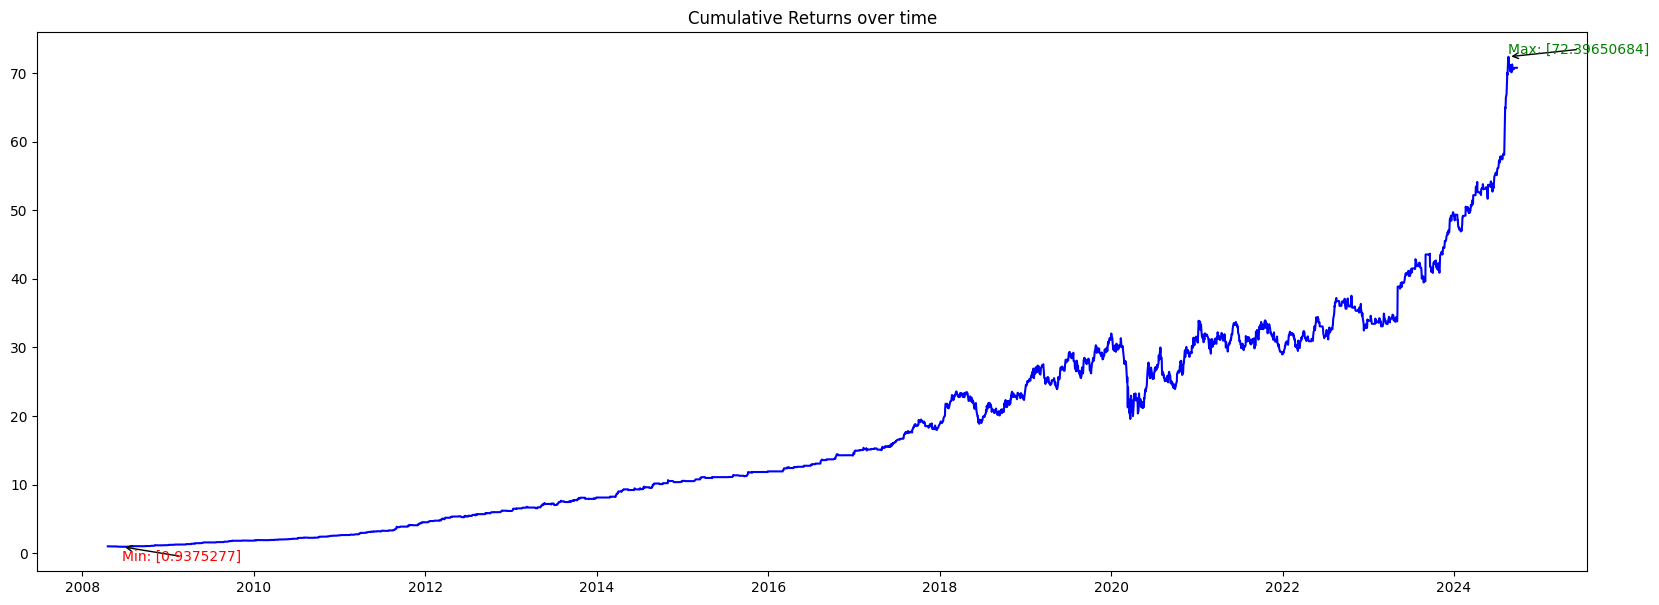

In [83]:
plot_cumulative_returns_line_chart(cuml_perf_lstm_01)

In [84]:
def plot_two_returns_series(series1, series2, label1, label2, index, title="Portfolio Comparison between Buy & Hold and Model"):
    plt.figure(figsize=(20, 7))
    plt.plot(index, series1, 'b-', label = label1)
    plt.plot(index, series2, 'r-', label = label2)
    plt.title(title)
    plt.legend()

    for i, series in enumerate([series1, series2]):
        max_idx = np.nanargmax(series)
        min_idx = np.nanargmin(series)

        print(series.to_numpy()[min_idx])

        plt.annotate(
            f"Max: {series.to_numpy()[max_idx]}",
            (series.index[max_idx], series.to_numpy()[max_idx]),
            xytext=(series.index[max_idx], series.to_numpy()[max_idx] + 0.5),
            arrowprops=dict(facecolor='green', arrowstyle='->'),
            color='green',
        )

        plt.annotate(
            f"Min: {series.to_numpy()[min_idx]}",
            (series.index[min_idx], series.to_numpy()[min_idx]),
            xytext=(series.index[min_idx], series.to_numpy()[min_idx] - (i+1)*2),
            arrowprops=dict(facecolor='red', arrowstyle='->'),
            color='red',
        )

    plt.plot()

[0.9375277]
[0.5940447]


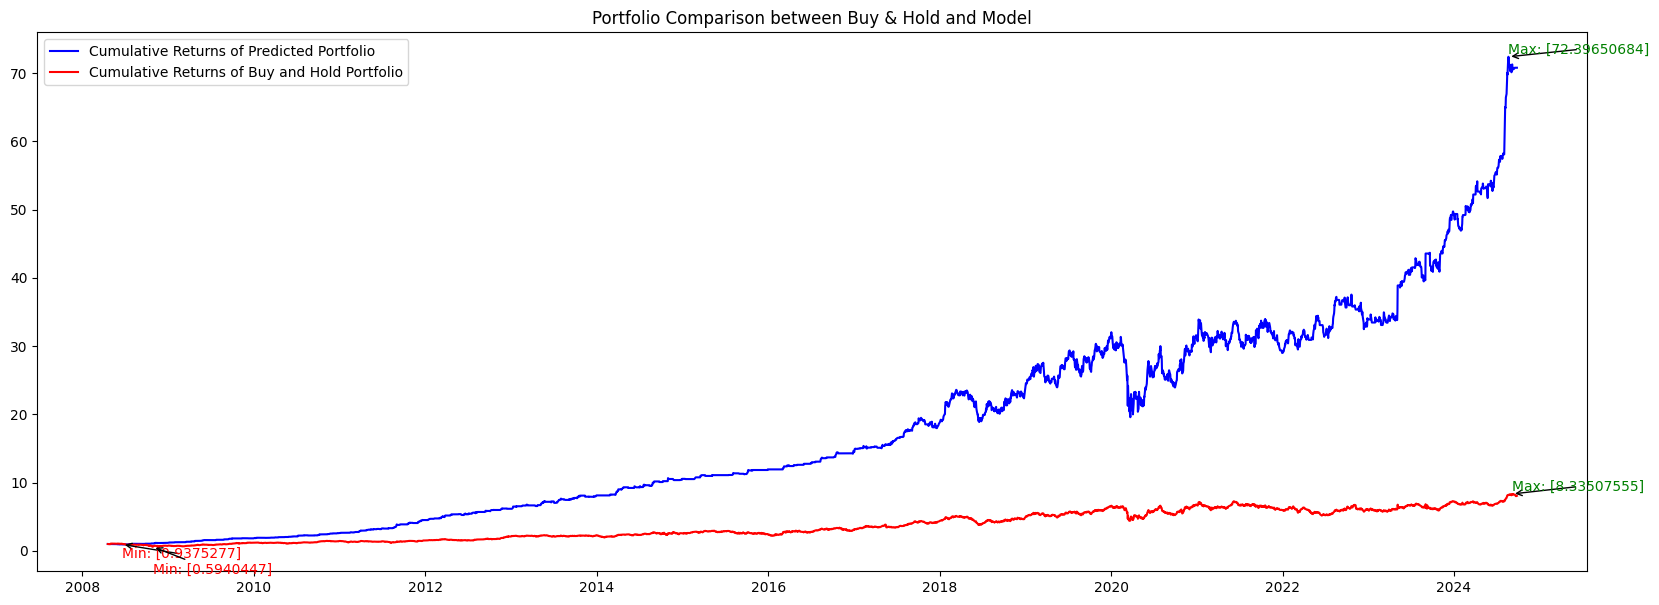

In [85]:
buy_and_hold1, _ = compute_buyandhold_cumulative_returns(stocks_df[return_cols].loc[start_date1 : end_date1])

plot_two_returns_series(
    cuml_perf_lstm_01, 
    buy_and_hold1,
    "Cumulative Returns of Predicted Portfolio", 
    "Cumulative Returns of Buy and Hold Portfolio", 
    daily_returns.index
)

In [86]:
max_sharpe_lstm_01, buy_and_hold_sharpe

(0.07377056156339154, 0.024224349918021783)

## Exp 2

In [87]:
LSTM_HIDDEN_UNITS_2 = 4

In [89]:
results_lstm_2_path = "./av02_lstm/results/lstm_02"

if not os.path.isfile(results_lstm_2_path):
    results_lstm_2 = []

    for i in range(NUM_EXPERIMENTS):
        print(f"Experiment {i+1}")
        abev3_lstm_res2, abev3_preds2 = run_lstm_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "abev3",
            LSTM_HIDDEN_UNITS_2,
            i
        )

        bbdc3_lstm_res2, bbdc3_preds2 = run_lstm_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "bbdc3", 
            LSTM_HIDDEN_UNITS_2,
            i
        )

        itsa3_lstm_res2, itsa3_preds2 = run_lstm_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "itsa3", 
            LSTM_HIDDEN_UNITS_2,
            i
        )

        itub3_lstm_res2, itub3_preds2 = run_lstm_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "itub3", 
            LSTM_HIDDEN_UNITS_2,
            i
        )

        wege3_lstm_res2, wege3_preds2 = run_lstm_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "wege3", 
            LSTM_HIDDEN_UNITS_2,
            i
        )

        results_lstm_2.append({
            "abev3": (abev3_lstm_res2, abev3_preds2),
            "bbdc3": (bbdc3_lstm_res2, bbdc3_preds2),
            "itsa3": (itsa3_lstm_res2, itsa3_preds2),
            "itub3": (itub3_lstm_res2, itub3_preds2),
            "wege3": (wege3_lstm_res2, wege3_preds2)
        })

    !mkdir "./av02_lstm/results/"
    with open(results_lstm_2_path, "wb") as f:
        pickle.dump(results_lstm_2, f)

else:
    with open(results_lstm_2_path, "rb") as f:
        results_lstm_2 = pickle.load(f)

Experiment 1


KeyboardInterrupt: 

In [ ]:
results_lstm_2

[{'abev3': ({'accuracy': 0.6333333333333333,
    'f1': 0.15384615384615385,
    'precision': 1.0,
    'recall': 0.08333333333333333},
   [{Timestamp('2008-04-18 00:00:00'): array([0.], dtype=float32)},
    {Timestamp('2008-04-22 00:00:00'): array([0.], dtype=float32)},
    {Timestamp('2008-04-23 00:00:00'): array([0.], dtype=float32)},
    {Timestamp('2008-04-24 00:00:00'): array([1.], dtype=float32)},
    {Timestamp('2008-04-25 00:00:00'): array([1.], dtype=float32)},
    {Timestamp('2008-04-28 00:00:00'): array([1.], dtype=float32)},
    {Timestamp('2008-04-29 00:00:00'): array([0.], dtype=float32)},
    {Timestamp('2008-04-30 00:00:00'): array([0.], dtype=float32)},
    {Timestamp('2008-05-02 00:00:00'): array([0.], dtype=float32)},
    {Timestamp('2008-05-05 00:00:00'): array([1.], dtype=float32)},
    {Timestamp('2008-05-06 00:00:00'): array([0.], dtype=float32)},
    {Timestamp('2008-05-07 00:00:00'): array([0.], dtype=float32)},
    {Timestamp('2008-05-08 00:00:00'): array([0.],

Selected exp number 1
[0.82999933]


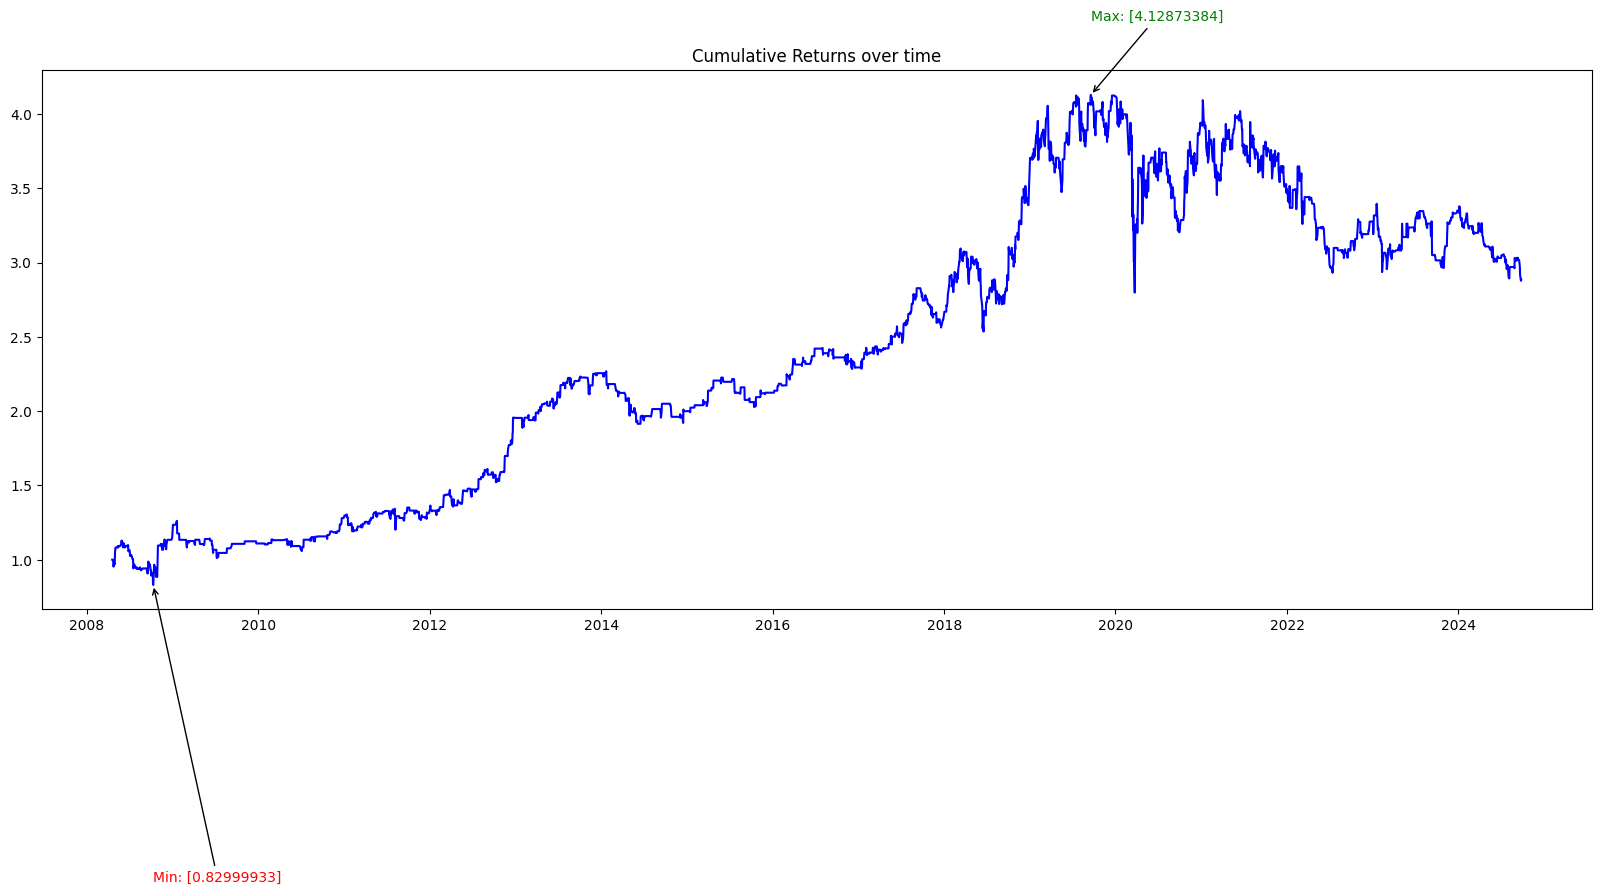

In [ ]:
best_results_lstm_02, cuml_perf_lstm_02, max_sharpe_lstm_02 = find_best_experiment(results_lstm_2)
plot_cumulative_returns_line_chart(cuml_perf_lstm_02)

[0.82999933]
[0.5940447]


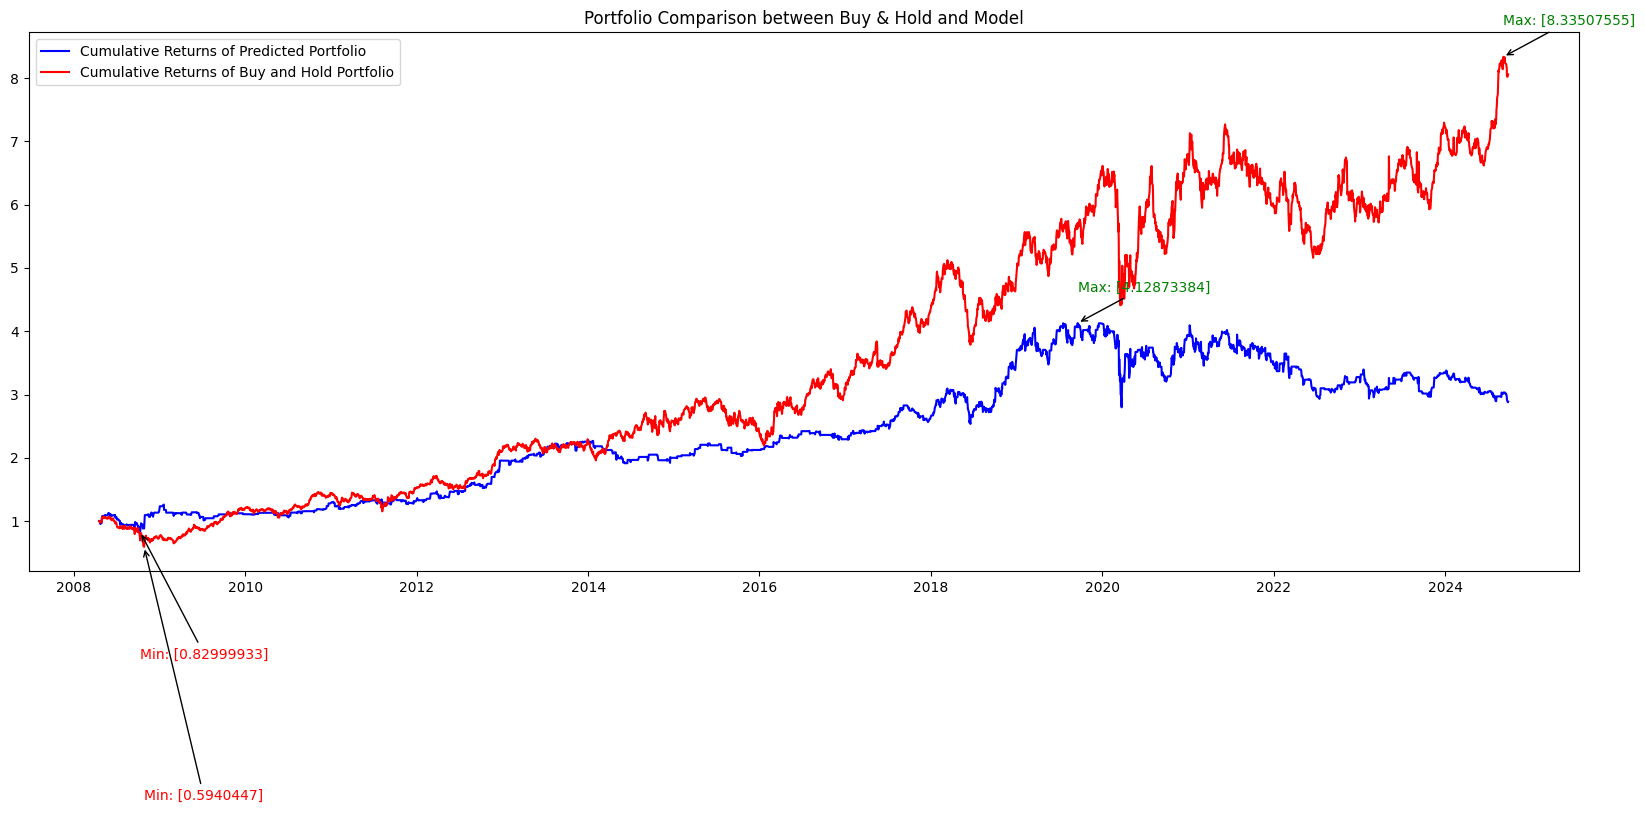

In [ ]:
plot_two_returns_series(
    cuml_perf_lstm_02,
    buy_and_hold1,
    "Cumulative Returns of Predicted Portfolio", 
    "Cumulative Returns of Buy and Hold Portfolio", 
    daily_returns.index
)

In [ ]:
max_sharpe_lstm_02, buy_and_hold_sharpe

(0.005565373843473352, 0.02422434991802179)

## Exp 3

In [ ]:
LSTM_HIDDEN_UNITS_3 = 8

In [ ]:
results_lstm_3_path = "./av02_lstm/results/lstm_03"

if not os.path.isfile(results_lstm_3_path):
    results_lstm_3 = []

    for i in range(NUM_EXPERIMENTS):
        print(f"Experiment {i+1}")
        abev3_lstm_res3, abev3_preds3 = run_lstm_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "abev3",
            LSTM_HIDDEN_UNITS_3,
            i
        )

        bbdc3_lstm_res3, bbdc3_preds3 = run_lstm_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "bbdc3", 
            LSTM_HIDDEN_UNITS_3,
            i
        )

        itsa3_lstm_res3, itsa3_preds3 = run_lstm_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "itsa3", 
            LSTM_HIDDEN_UNITS_3,
            i
        )

        itub3_lstm_res3, itub3_preds3 = run_lstm_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "itub3", 
            LSTM_HIDDEN_UNITS_3,
            i
        )

        wege3_lstm_res3, wege3_preds3 = run_lstm_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "wege3", 
            LSTM_HIDDEN_UNITS_3,
            i
        )

        results_lstm_3.append({
            "abev3": (abev3_lstm_res3, abev3_preds3),
            "bbdc3": (bbdc3_lstm_res3, bbdc3_preds3),
            "itsa3": (itsa3_lstm_res3, itsa3_preds3),
            "itub3": (itub3_lstm_res3, itub3_preds3),
            "wege3": (wege3_lstm_res3, wege3_preds3)
        })

    !mkdir "./av02_lstm/results/"
    with open(results_lstm_3_path, "wb") as f:
        pickle.dump(results_lstm_3, f)

else:
    with open(results_lstm_3_path, "rb") as f:
        results_lstm_3 = pickle.load(f)

Experiment 1
mkdir: cannot create directory ‘./av02_lstm/results/’: File exists


Selected exp number 1
[0.17904007]


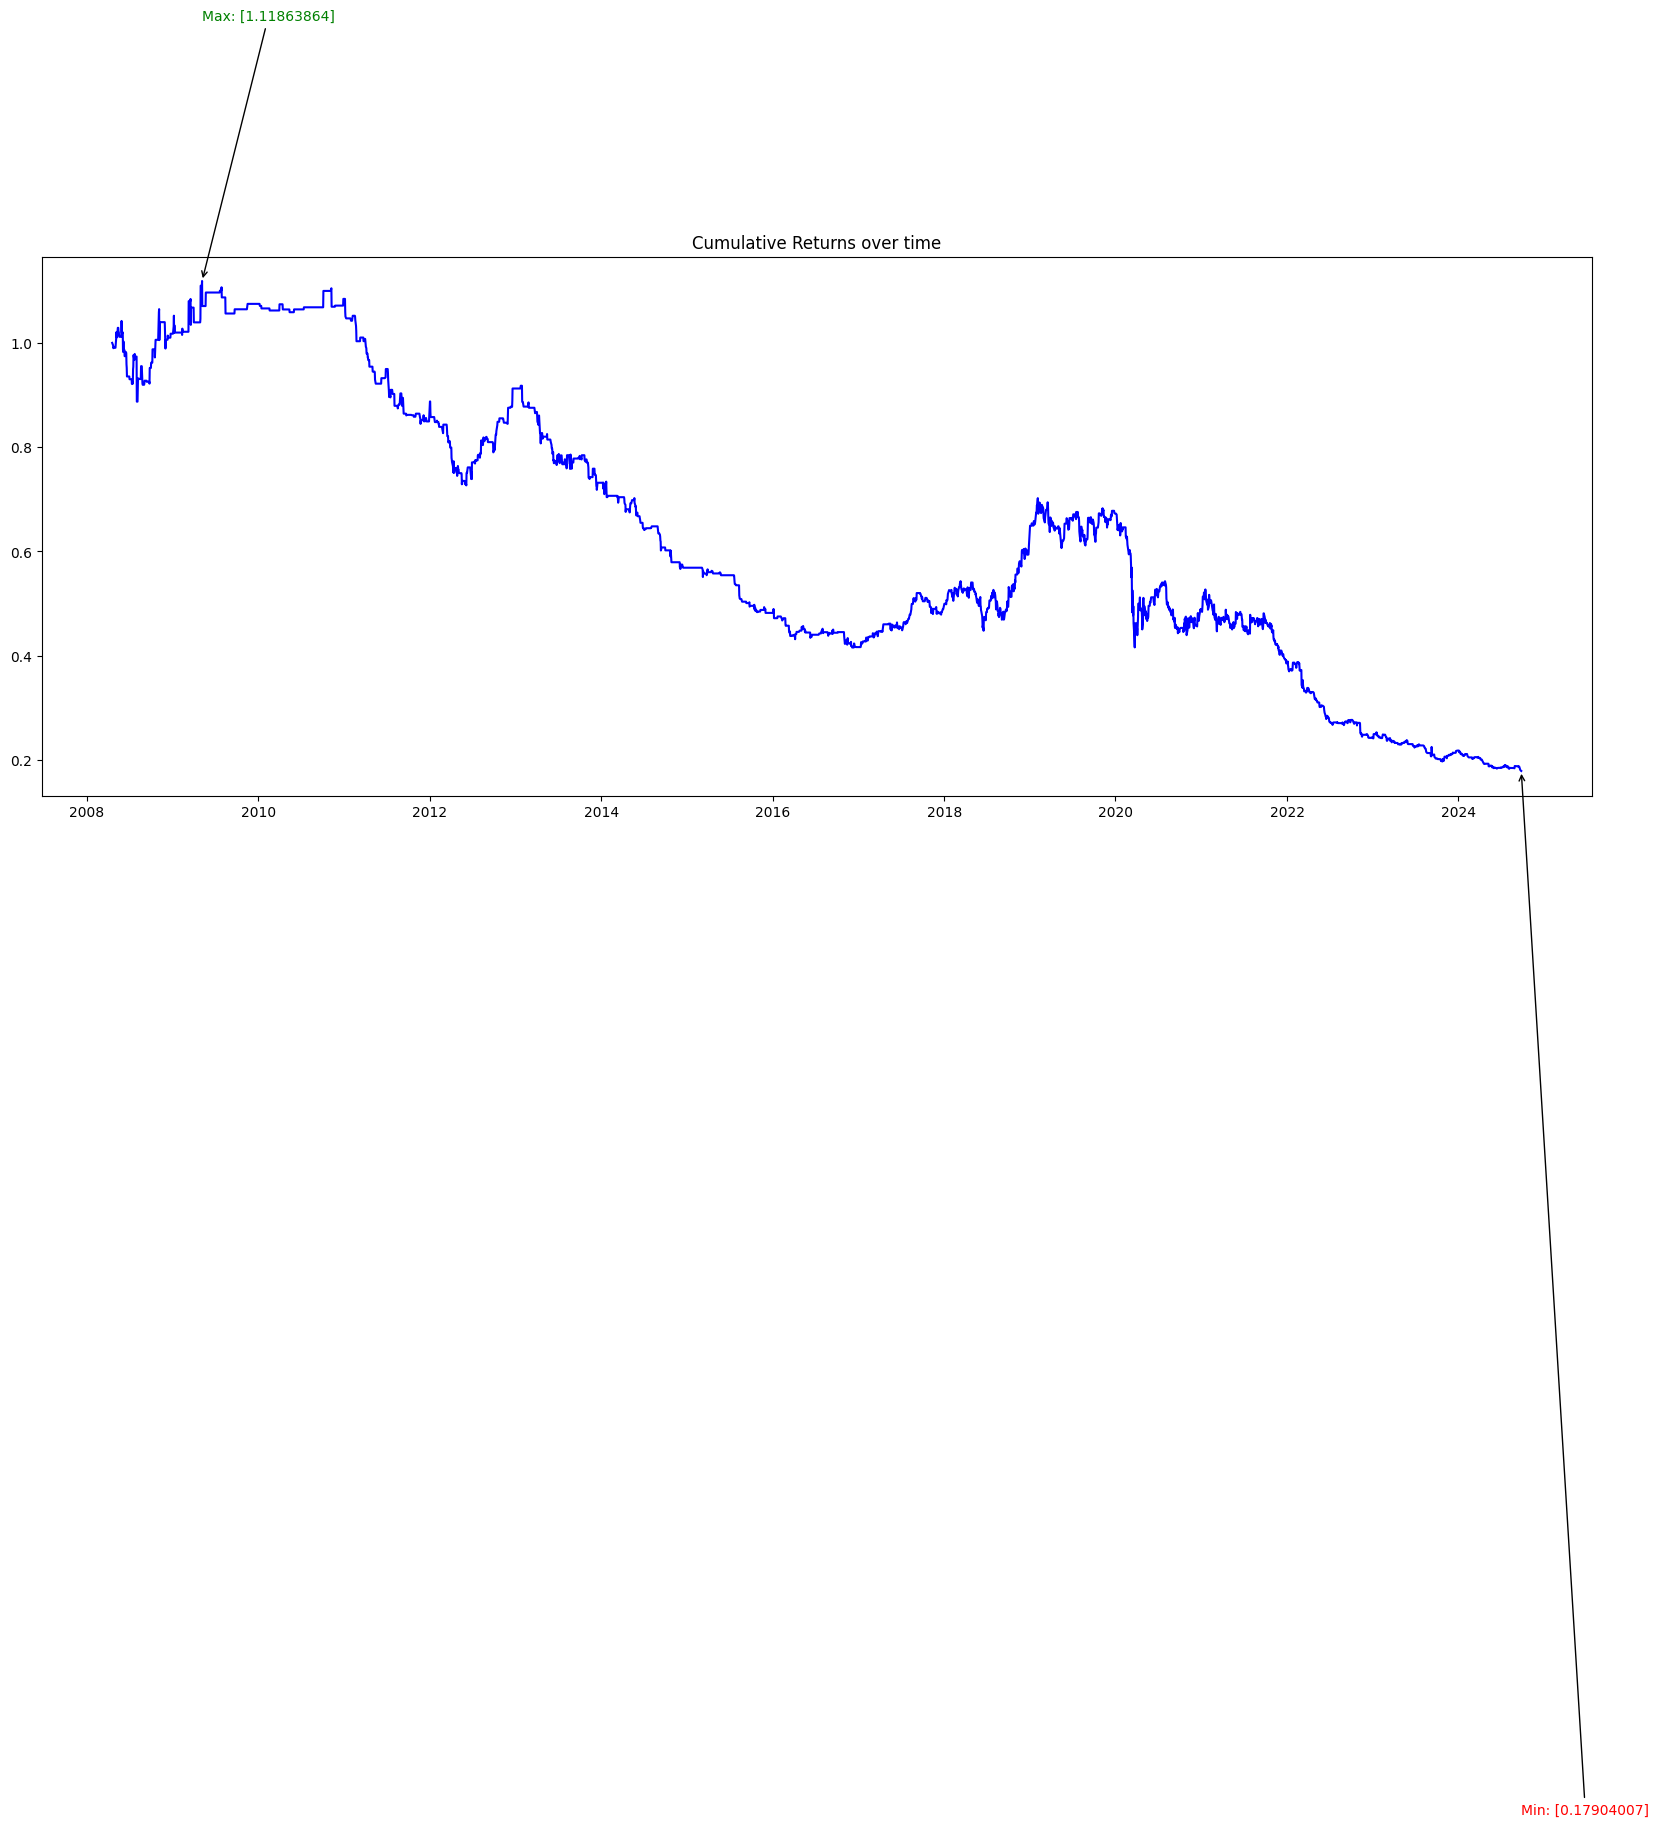

In [ ]:
best_results_lstm_03, cuml_perf_lstm_03, max_sharpe_lstm_03 = find_best_experiment(results_lstm_3)
plot_cumulative_returns_line_chart(cuml_perf_lstm_03)

[0.17904007]
[0.5940447]


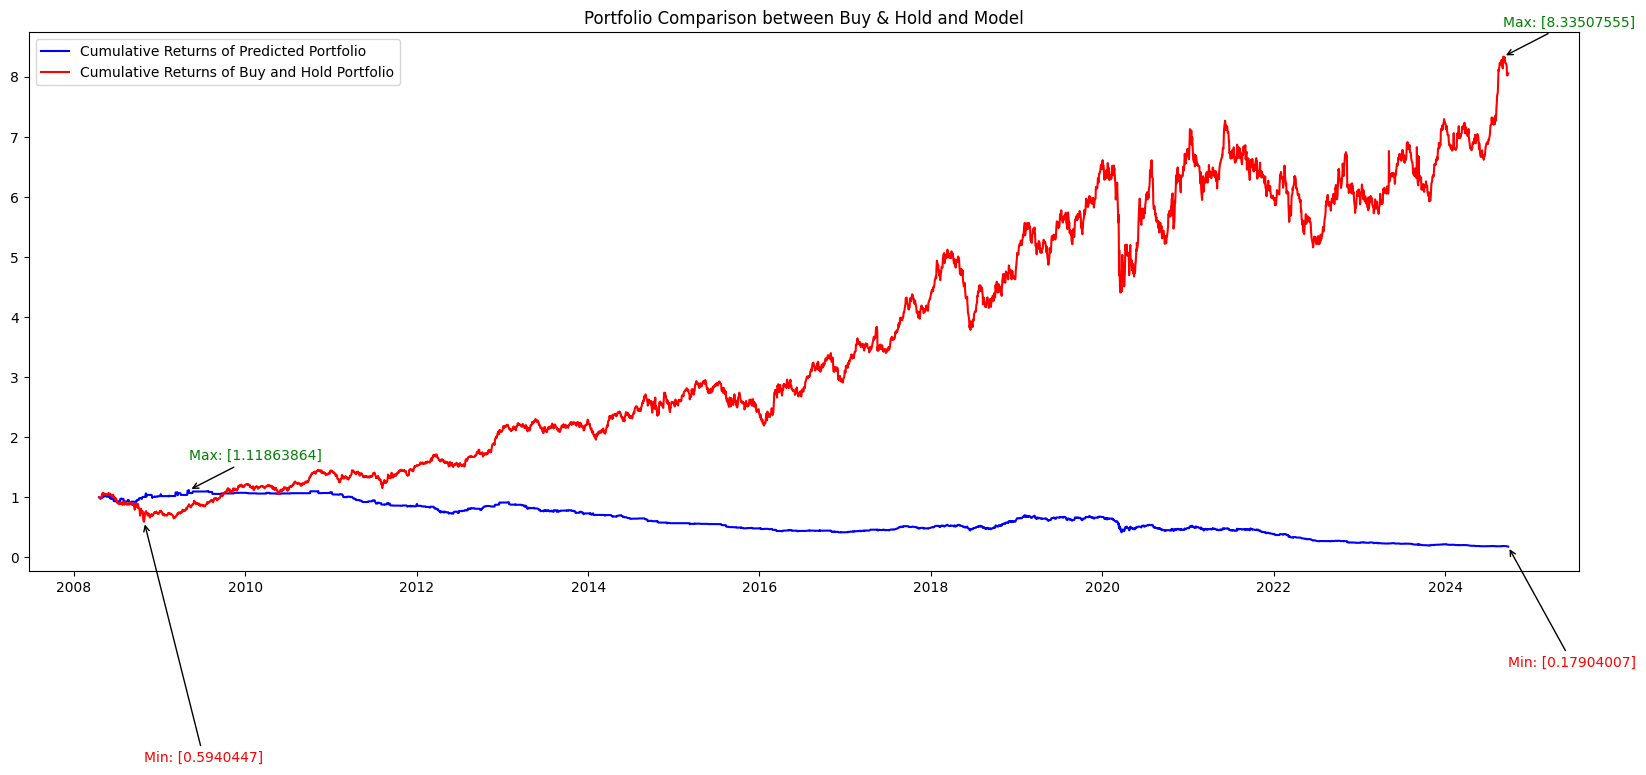

In [ ]:
plot_two_returns_series(
    cuml_perf_lstm_03,
    buy_and_hold1,
    "Cumulative Returns of Predicted Portfolio", 
    "Cumulative Returns of Buy and Hold Portfolio", 
    daily_returns.index
)

In [ ]:
max_sharpe_lstm_03, buy_and_hold_sharpe

(-0.06192839064929908, 0.02422434991802179)

## Discussão

A LSTM não é capaz de superar o Buy & Hold em nenhuma ocasião, fato confirmado pelo Sharpe Ratio inferior ao Buy & Hold, inclusive gerando prejuízos quando se usa 8 unidades escondidas. Existe um argumento que LSTMs não são ideais para séries temporais, especialmente séries univariadas. https://machinelearningmastery.com/suitability-long-short-term-memory-networks-time-series-forecasting/

Além disso, cabe ressaltar que o Sharpe Ratio não é ideal nem para o Buy & Hold, que encontra-se abaixo de 1. Isso indica que a volatilidade da carteira é alta demais para o retorno dela se comparada a um ativo de baixo risco como o Tesouro SELIC, rendendo a uma média arbitrária de 10% a.a. no mesmo período.

# GRU

In [ ]:
def define_gru(data_shape, num_units):
    gru = Sequential()

    gru.add(Input(shape=data_shape))
    gru.add(GRU(num_units))
    gru.add(Dense(1, activation="sigmoid"))

    gru.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    return gru

In [ ]:
def run_gru_experiment(train_size: int, val_size: int, stock: str, num_units: int, random_seed: int):
    np.random.seed(random_seed)
    random.seed(random_seed)
    tf.random.set_seed(random_seed)

    data = preprocess_data(stocks_df, stock)

    X = data.drop([f"{stock}_y"], axis=1)
    y_ground = data[f"{stock}_y"]

    model = define_gru((X.shape[1], 1), num_units)
    cv_splitter = SlidingWindowExclusiveTestCV(train_size, val_size)

    tests = []

    for train_index, test_index in cv_splitter.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y_ground.iloc[train_index], y_ground.iloc[test_index]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.fit_transform(X_test)

        model.fit(
            X_train, y_train,
            epochs = TRAINING_EPOCHS,
            batch_size=BATCH_SIZE,
            validation_split=0.2,
            callbacks=[early_stopping],
            shuffle=False,
            verbose=False,
        )

        y_hat = model.predict(X_test, verbose=False)

        y_hat = np.array(y_hat)
        for i in range(len(y_hat)):
            if y_hat[i] > 0.5:
                y_hat[i] = True
            else:
                y_hat[i] = False

        for i, y in enumerate(y_hat):
            tests.append({y_test.index[i]: y})
            
        results = {
            "accuracy": accuracy_score(y_test, y_hat),
            "f1": f1_score(y_test, y_hat),
            "precision": precision_score(y_test, y_hat, zero_division=0),
            "recall": recall_score(y_test, y_hat)
        }

    np.random.seed(RANDOM_STATE)
    random.seed(RANDOM_STATE)
    tf.random.set_seed(RANDOM_STATE)

    return results, tests

## Exp 01

In [ ]:
GRU_HIDDEN_UNITS = 1

In [ ]:
results_gru_1_path = "./av02_lstm/results/gru_01"

if not os.path.isfile(results_gru_1_path):
    results_gru_1 = []

    for i in range(NUM_EXPERIMENTS):
        print(f"Experiment {i+1}")
        abev3_gru_res, abev3_gru_preds = run_gru_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "abev3",
            GRU_HIDDEN_UNITS,
            i
        )

        bbdc3_gru_res, bbdc3_gru_preds = run_gru_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "bbdc3", 
            GRU_HIDDEN_UNITS,
            i
        )

        itsa3_gru_res, itsa3_gru_preds = run_gru_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "itsa3", 
            GRU_HIDDEN_UNITS,
            i
        )

        itub3_gru_res, itub3_gru_preds = run_gru_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "itub3", 
            GRU_HIDDEN_UNITS,
            i
        )

        wege3_gru_res, wege3_gru_preds = run_gru_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "wege3", 
            GRU_HIDDEN_UNITS,
            i
        )

        results_gru_1.append({
            "abev3": (abev3_gru_res, abev3_gru_preds),
            "bbdc3": (bbdc3_gru_res, bbdc3_gru_preds),
            "itsa3": (itsa3_gru_res, itsa3_gru_preds),
            "itub3": (itub3_gru_res, itub3_gru_preds),
            "wege3": (wege3_gru_res, wege3_gru_preds)
        })

    !mkdir "./av02_lstm/results/"
    with open(results_gru_1_path, "wb") as f:
        pickle.dump(results_gru_1, f)

else:
    with open(results_gru_1_path, "rb") as f:
        results_gru_1 = pickle.load(f)

Experiment 1
mkdir: cannot create directory ‘./av02_lstm/results/’: File exists


Selected exp number 1
[0.68939256]


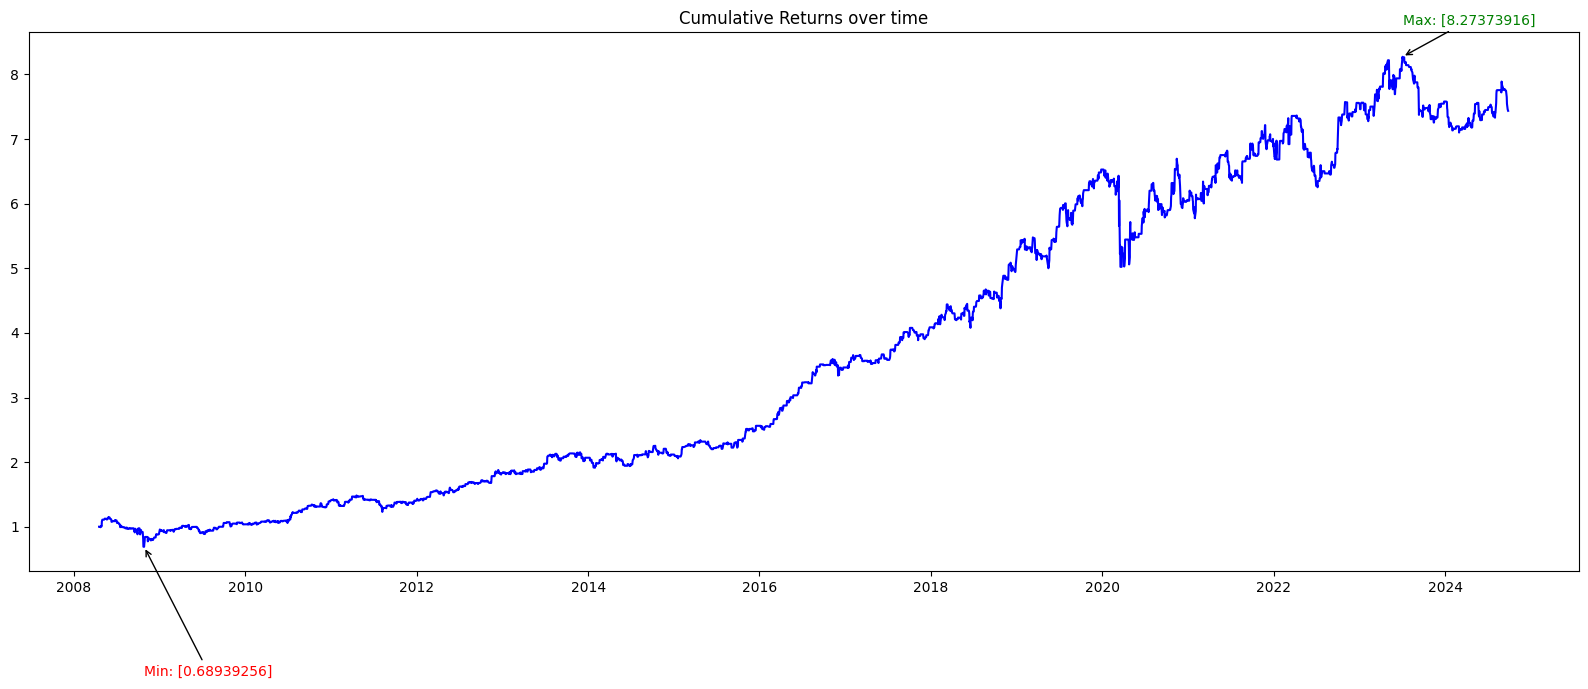

In [ ]:
best_results_gru_1, cuml_perf_gru_1, max_sharpe_gru_1 = find_best_experiment(results_gru_1)
plot_cumulative_returns_line_chart(cuml_perf_gru_1)

[0.68939256]
[0.5940447]


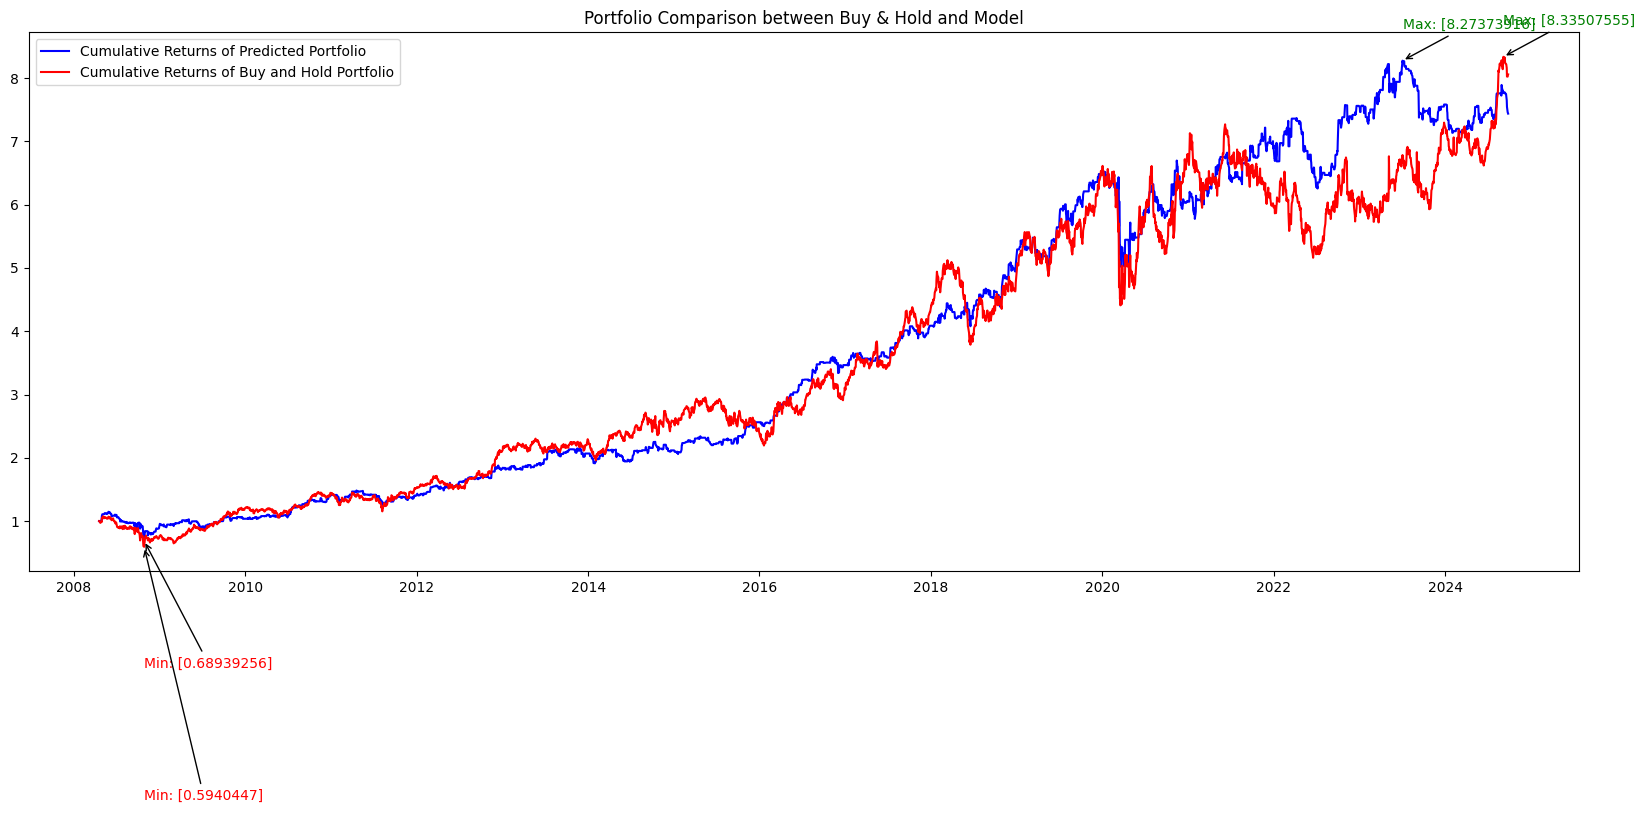

In [ ]:
plot_two_returns_series(
    cuml_perf_gru_1, 
    buy_and_hold1,
    "Cumulative Returns of Predicted Portfolio", 
    "Cumulative Returns of Buy and Hold Portfolio", 
    daily_returns.index
)

In [ ]:
max_sharpe_gru_1, buy_and_hold_sharpe

(0.02734561364266745, 0.02422434991802179)

## Exp 02

In [ ]:
GRU_HIDDEN_UNITS_2 = 4

In [ ]:
results_gru_2_path = "./av02_lstm/results/gru_02"

if not os.path.isfile(results_gru_2_path):
    results_gru_2 = []

    for i in range(NUM_EXPERIMENTS):
        print(f"Experiment {i+1}")
        abev3_gru_res2, abev3_gru_preds2 = run_gru_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "abev3",
            GRU_HIDDEN_UNITS_2,
            i
        )

        bbdc3_gru_res2, bbdc3_gru_preds2 = run_gru_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "bbdc3", 
            GRU_HIDDEN_UNITS_2,
            i
        )

        itsa3_gru_res2, itsa3_gru_preds2 = run_gru_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "itsa3", 
            GRU_HIDDEN_UNITS_2,
            i
        )

        itub3_gru_res2, itub3_gru_preds2 = run_gru_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "itub3", 
            GRU_HIDDEN_UNITS_2,
            i
        )

        wege3_gru_res2, wege3_gru_preds2 = run_gru_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "wege3", 
            GRU_HIDDEN_UNITS_2,
            i
        )

        results_gru_2.append({
            "abev3": (abev3_gru_res2, abev3_gru_preds2),
            "bbdc3": (bbdc3_gru_res2, bbdc3_gru_preds2),
            "itsa3": (itsa3_gru_res2, itsa3_gru_preds2),
            "itub3": (itub3_gru_res2, itub3_gru_preds2),
            "wege3": (wege3_gru_res2, wege3_gru_preds2)
        })

    !mkdir "./av02_lstm/results/"
    with open(results_gru_2_path, "wb") as f:
        pickle.dump(results_gru_2, f)

else:
    with open(results_gru_2_path, "rb") as f:
        results_gru_2 = pickle.load(f)

Experiment 1
mkdir: cannot create directory ‘./av02_lstm/results/’: File exists


Selected exp number 1
[0.85299732]


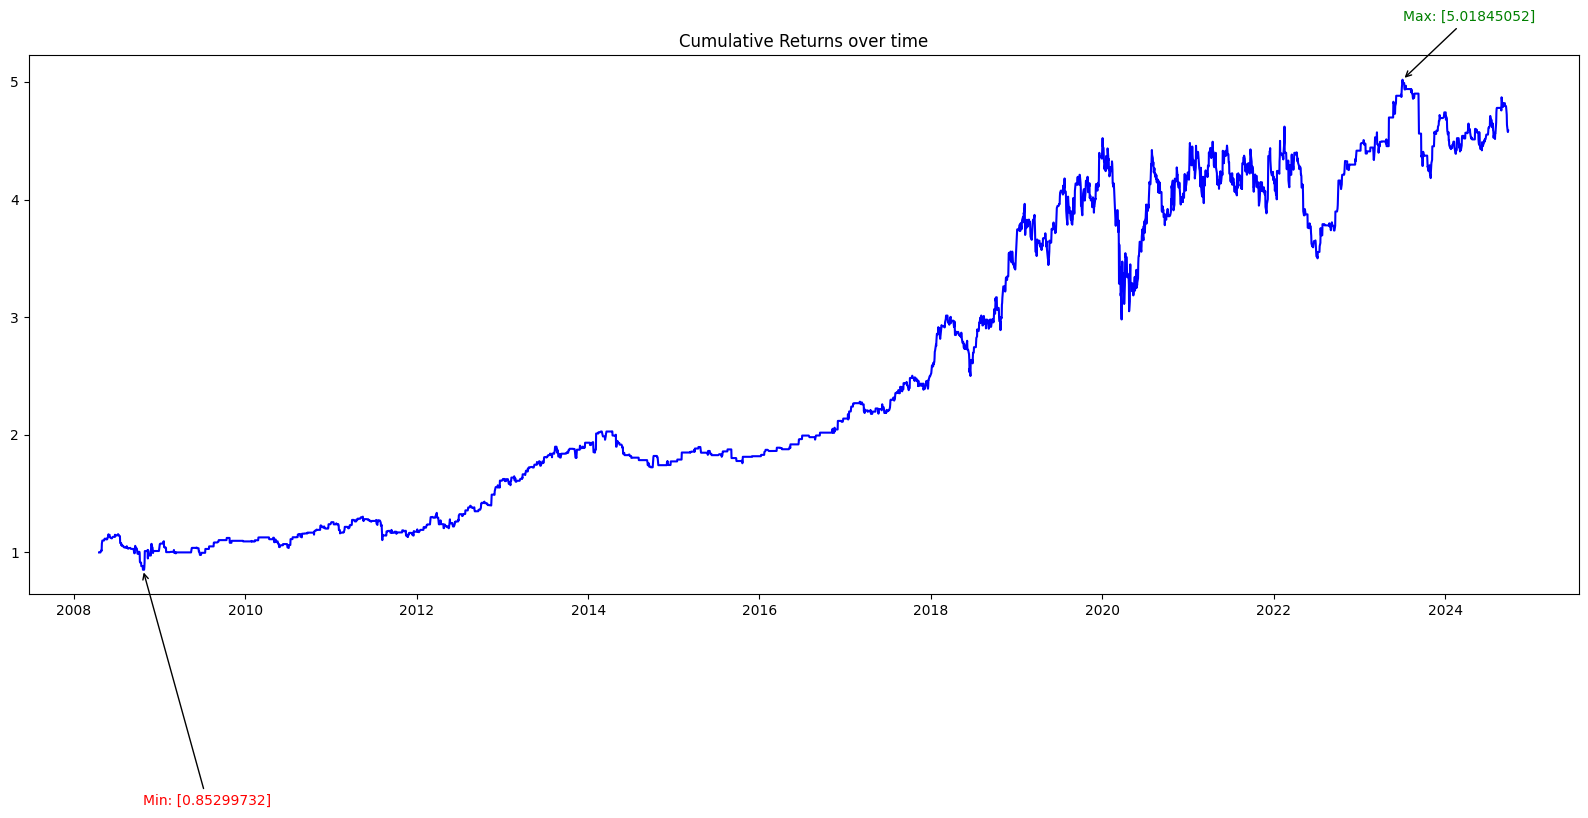

In [ ]:
best_results_gru_2, cuml_perf_gru_2, max_sharpe_gru_2 = find_best_experiment(results_gru_2)
plot_cumulative_returns_line_chart(cuml_perf_gru_2)

[0.85299732]
[0.5940447]


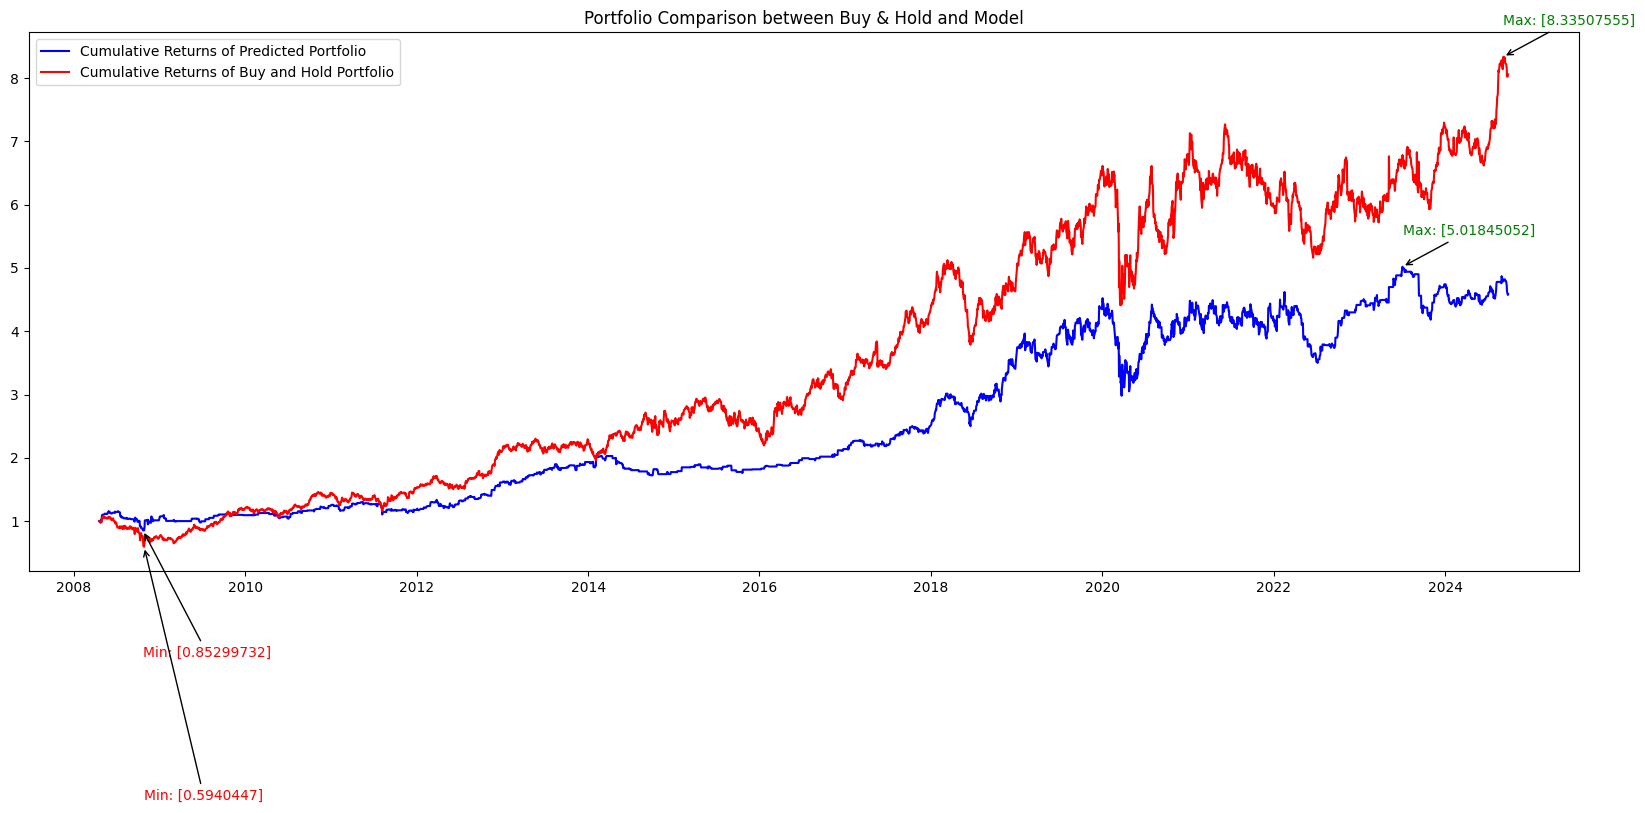

In [ ]:
plot_two_returns_series(
    cuml_perf_gru_2,
    buy_and_hold1,
    "Cumulative Returns of Predicted Portfolio", 
    "Cumulative Returns of Buy and Hold Portfolio", 
    daily_returns.index
)

In [ ]:
max_sharpe_gru_2, buy_and_hold_sharpe

(0.0156046795546831, 0.02422434991802179)

## Exp 03

In [ ]:
GRU_HIDDEN_UNITS_3 = 8

In [ ]:
results_gru_3_path = "./av02_lstm/results/gru_03"

if not os.path.isfile(results_gru_3_path):
    results_gru_3 = []

    for i in range(NUM_EXPERIMENTS):
        print(f"Experiment {i+1}")
        abev3_gru_res3, abev3_gru_preds3 = run_gru_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "abev3",
            GRU_HIDDEN_UNITS_3,
            i
        )

        bbdc3_gru_res3, bbdc3_gru_preds3 = run_gru_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "bbdc3", 
            GRU_HIDDEN_UNITS_3,
            i
        )

        itsa3_gru_res3, itsa3_gru_preds3 = run_gru_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "itsa3", 
            GRU_HIDDEN_UNITS_3,
            i
        )

        itub3_gru_res3, itub3_gru_preds3 = run_gru_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "itub3", 
            GRU_HIDDEN_UNITS_3,
            i
        )

        wege3_gru_res3, wege3_gru_preds3 = run_gru_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "wege3", 
            GRU_HIDDEN_UNITS_3,
            i
        )

        results_gru_3.append({
            "abev3": (abev3_gru_res3, abev3_gru_preds3),
            "bbdc3": (bbdc3_gru_res3, bbdc3_gru_preds3),
            "itsa3": (itsa3_gru_res3, itsa3_gru_preds3),
            "itub3": (itub3_gru_res3, itub3_gru_preds3),
            "wege3": (wege3_gru_res3, wege3_gru_preds3)
        })

    !mkdir "./av02_lstm/results/"
    with open(results_gru_3_path, "wb") as f:
        pickle.dump(results_gru_3, f)

else:
    with open(results_gru_3_path, "rb") as f:
        results_gru_3 = pickle.load(f)

Experiment 1
mkdir: cannot create directory ‘./av02_lstm/results/’: File exists


Selected exp number 1
[0.48258421]


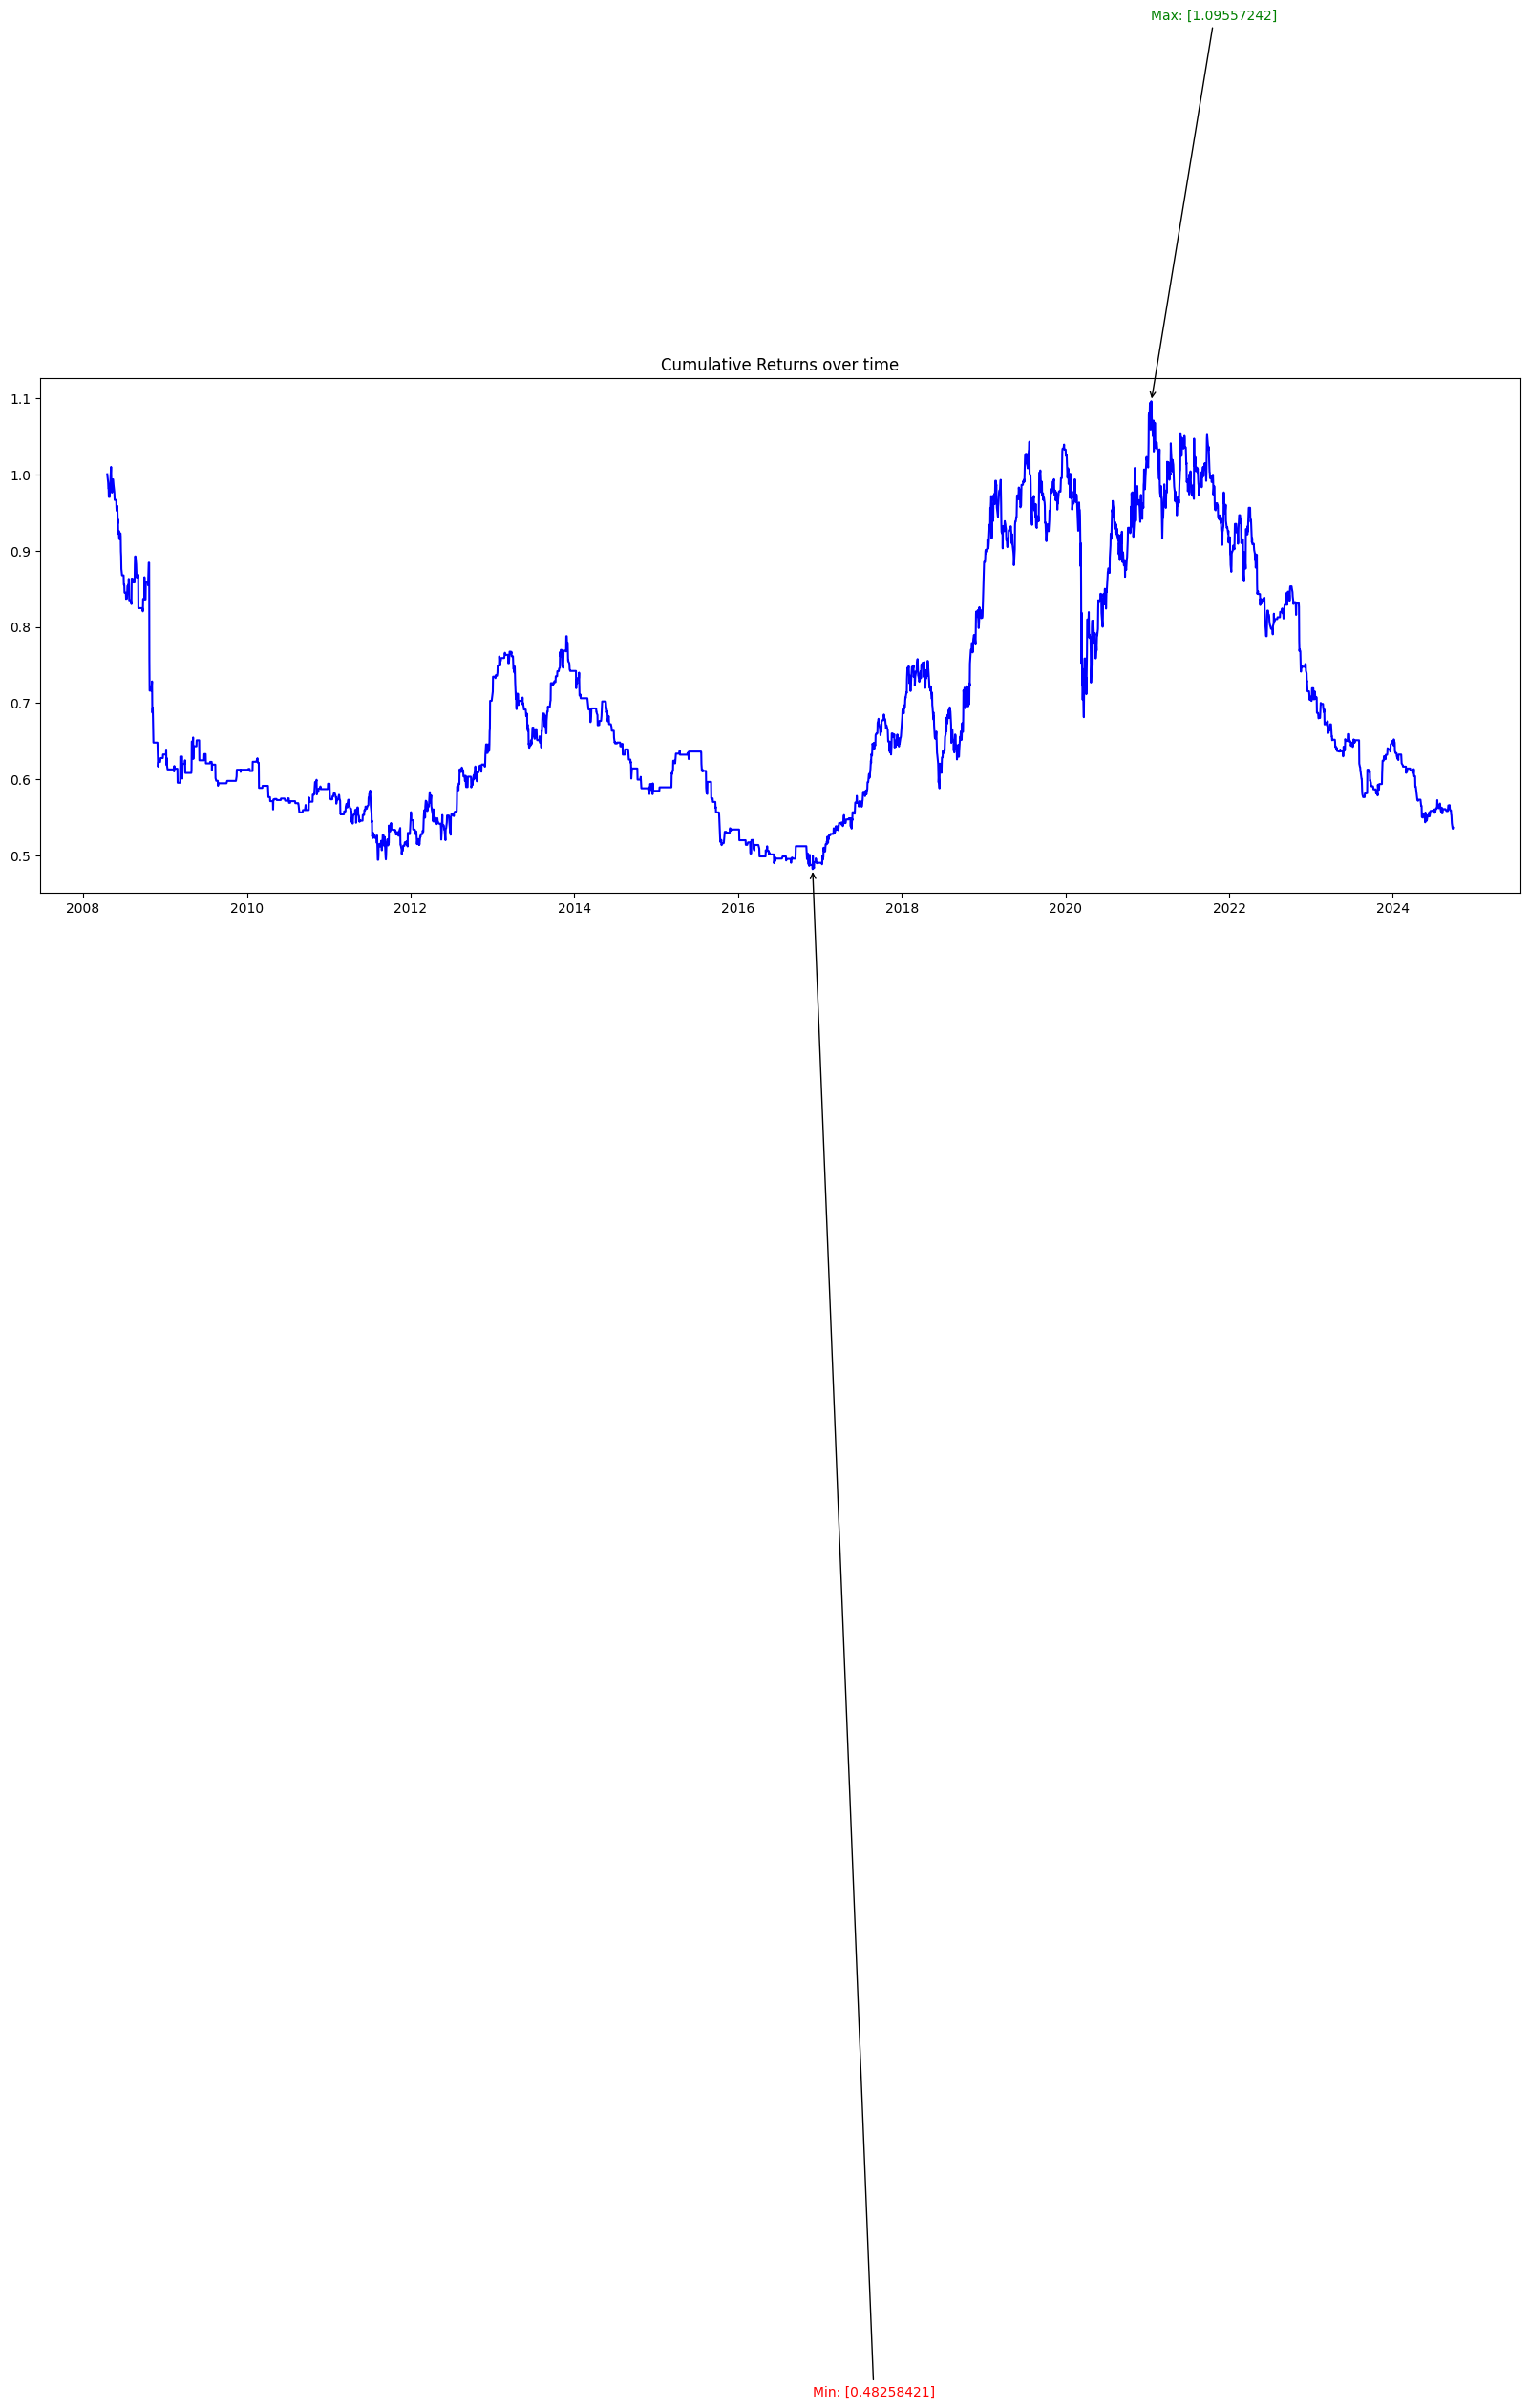

In [ ]:
best_results_gru_3, cuml_perf_gru_3, max_sharpe_gru_3 = find_best_experiment(results_gru_3)
plot_cumulative_returns_line_chart(cuml_perf_gru_3)

[0.48258421]
[0.5940447]


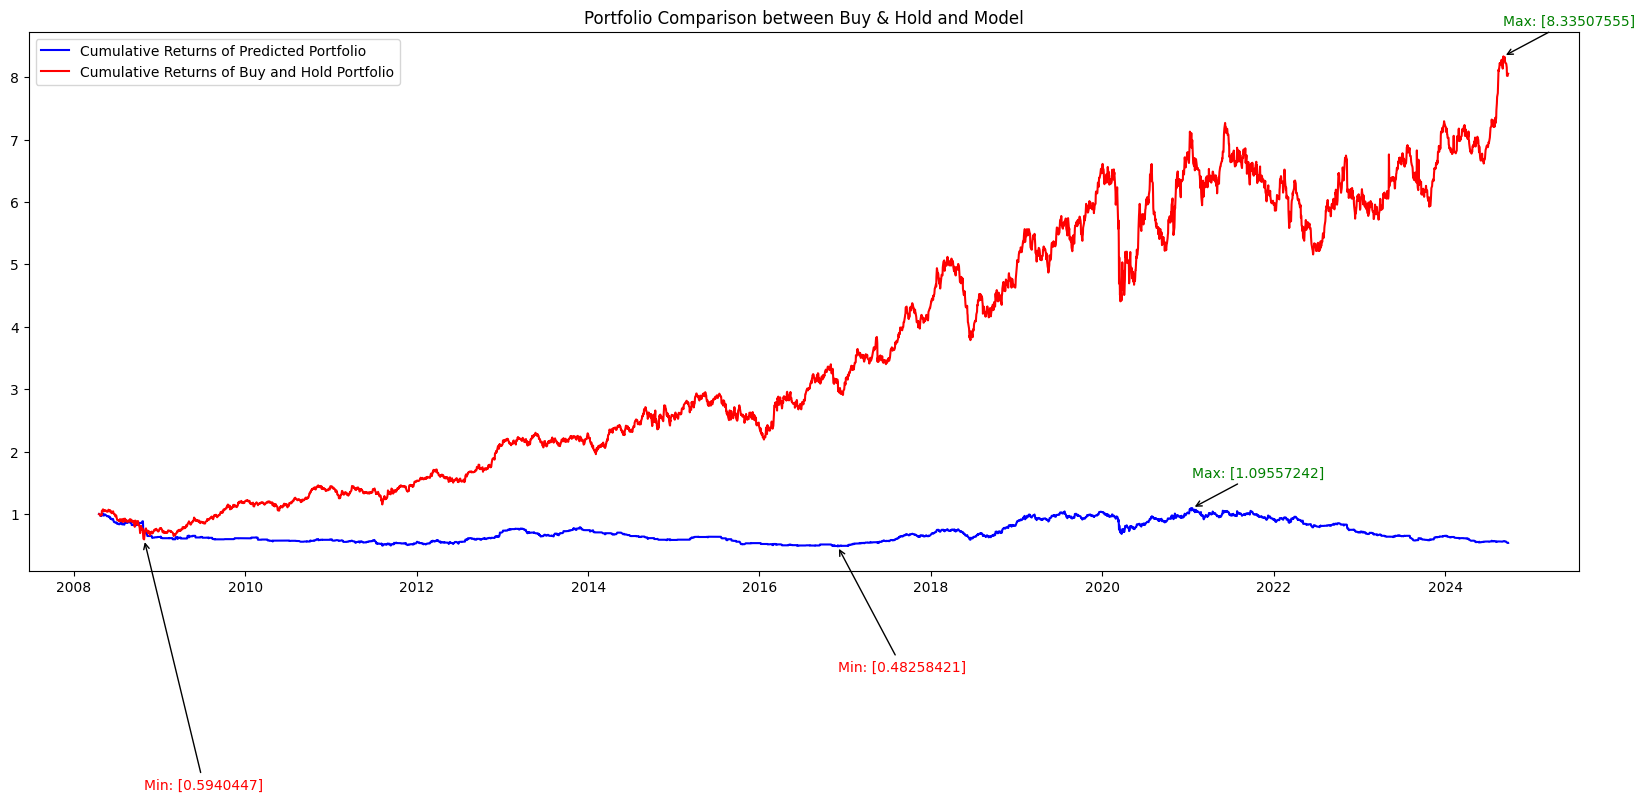

In [ ]:
plot_two_returns_series(
    cuml_perf_gru_3, 
    buy_and_hold1,
    "Cumulative Returns of Predicted Portfolio", 
    "Cumulative Returns of Buy and Hold Portfolio", 
    daily_returns.index
)

In [ ]:
max_sharpe_gru_3, buy_and_hold_sharpe

(-0.031524525624813, 0.02422434991802179)

## Discussão

A rede GRU é imediatamente melhor que a LSTM para esse caso em todos os experimentos. Essa arquitetura, mais simples que a LSTM, funciona melhor para essa série univariada de sequências curtas e supera o Buy & Hold em todos os casos, especialmente com apenas 1 unidade na camada escondida. O Sharpe Ratio de qualquer portfolio da GRU supera o do Buy & Hold e todos da LSTM também. Os resultados obtidos com a GRU são promissores.

TODO:
- rodar n experimentos e plotar accs/sharpe ratios e std
- padronizar os dados no preprocessamento
- Avaliar sharpe ratio de diversas execuções ao invés de acurácia???? -> nem faz sentido avaliar acurácia: maior acurácia nao quer dizer melhor performanc
- colocar sharpes em uma tabela
- avaliar cada modelo por melhor, pior e mediana sharpe ratio